In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
# Define directories and file paths
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# List all .tif and .shp files
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    return (match.group(1), match.group(2)) if match else (None, None)

# Pair image and shapefile paths
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island and date:
            matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
            if matching_shapefiles:
                file_pairs[image_path] = matching_shapefiles[0]
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus files
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island and date:
            matching_images = [image for image in image_paths if island in image and date in image]
            if matching_images:
                file_pairs[matching_images[0]] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

In [3]:
# Add band ratios based on your previous information
def add_band_ratios(df):
    df['NIR_Green_ratio'] = df['NIR'] / df['Green']  # Walrus vs Ice
    df['NIR_Red_ratio'] = df['NIR'] / df['Red']  # Walrus vs Ocean
    df['NIR_Blue_ratio'] = df['NIR'] / df['Blue']  # Walrus vs Rock and Freshwater
    return df

dataset = add_band_ratios(dataset)

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    stratify_labels = df['encoded_labels'].astype(str) + '_' + islands.astype(str)
    
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, stratify_labels):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        if all(cls in train_df['encoded_labels'].values for cls in le.transform(['walrus_pure', 'walrus_mixed'])):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)

# Prepare features and labels
X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name'])
y_train = train_df['encoded_labels']
X_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name'])
y_test = test_df['encoded_labels']

# Balance the training data
def balanced_sampler(X, y):
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_under, y_under = rus.fit_resample(X, y)
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_under, y_under)
    
    return X_balanced, y_balanced

In [4]:
X_train_balanced, y_train_balanced = balanced_sampler(X_train, y_train)

rf = RandomForestClassifier(random_state=42)

# Step 1: Coarse search
param_dist_coarse = {
    'n_estimators': [100, 500],
    'max_depth': [5, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt']
}

rf_random_coarse = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_coarse, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, error_score='raise')

try:
    rf_random_coarse.fit(X_train_balanced, y_train_balanced)
    best_params = rf_random_coarse.best_params_
    
    # Fine-tuned search around best parameters
    param_dist_fine = {
        'n_estimators': [max(100, best_params['n_estimators'] - 100), best_params['n_estimators'], min(500, best_params['n_estimators'] + 100)],
        'max_depth': [max(10, best_params['max_depth'] - 5) if best_params['max_depth'] is not None else None, 
                      best_params['max_depth'], 
                      min(30, best_params['max_depth'] + 5) if best_params['max_depth'] is not None else None],
        'min_samples_split': [max(2, best_params['min_samples_split'] - 1), best_params['min_samples_split'], min(10, best_params['min_samples_split'] + 1)],
        'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1), best_params['min_samples_leaf'], min(4, best_params['min_samples_leaf'] + 1)],
        'max_features': [best_params['max_features']]
    }
    
    rf_random_fine = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_fine, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, error_score='raise')
    rf_random_fine.fit(X_train_balanced, y_train_balanced)
    best_rf_model = rf_random_fine.best_estimator_

except Exception as e:
    print(f"An error occurred during model fitting: {e}")
    best_rf_model = RandomForestClassifier(random_state=42)  # Fallback to default model

# Save the model
model_filename = "RF_all_0407.joblib"
joblib.dump(best_rf_model, model_filename)

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 81 candidates, totalling 243 fits


['RF_all_0407.joblib']

In [5]:
# Model evaluation
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.58      0.84      0.69      6489
         ice       0.94      0.79      0.86     47189
       ocean       0.99      0.97      0.98    106449
        rock       0.89      0.86      0.87     18076
walrus_mixed       0.02      0.72      0.05       205
 walrus_pure       0.02      0.88      0.04        40

    accuracy                           0.91    178448
   macro avg       0.57      0.84      0.58    178448
weighted avg       0.95      0.91      0.93    178448


RF Model
Accuracy: 0.9068468125168117
Precision: 0.9524822224250246
Recall: 0.9068468125168117
F1 Score: 0.9264452645185707
Cohen's Kappa: 0.8398676764753754

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.58      0.84      0.69      6489
         ice       0.94      0.79      0.86     47189
       ocean       0.99      0.97      0.98    106449
        rock       0.89      0.86      0.87     18076
walrus_mixed       0.02      0.72      0.05       205
 walrus_pure       0.02      0.88      0.04        40

    accuracy                           0.91    178448
   macro avg       0.57      0.84      0.58    178448
weighted avg       0.95      0.91      0.93    178448


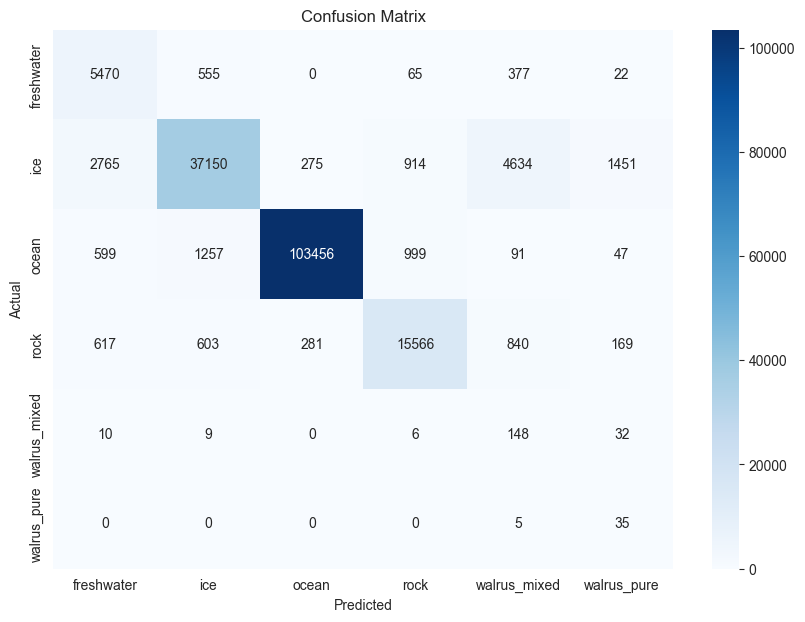

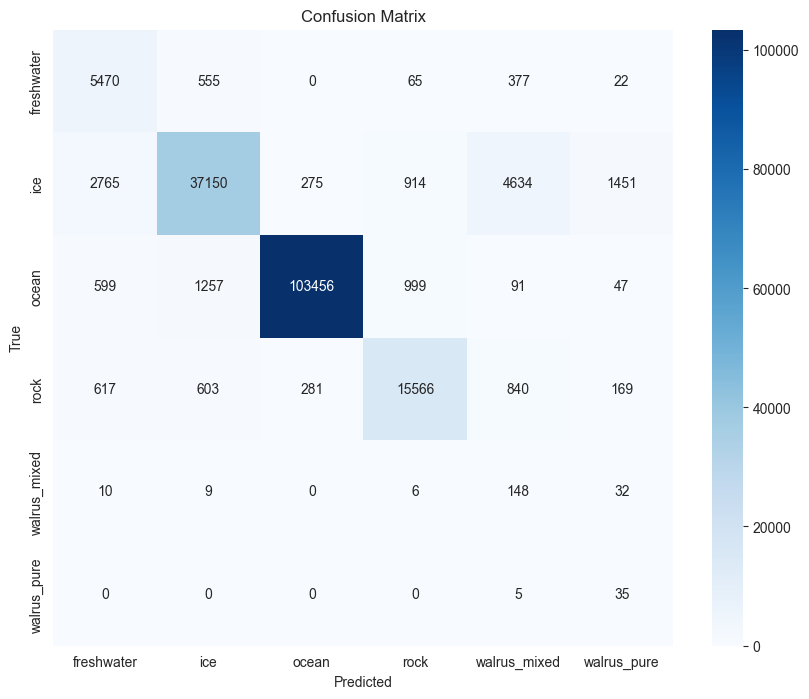

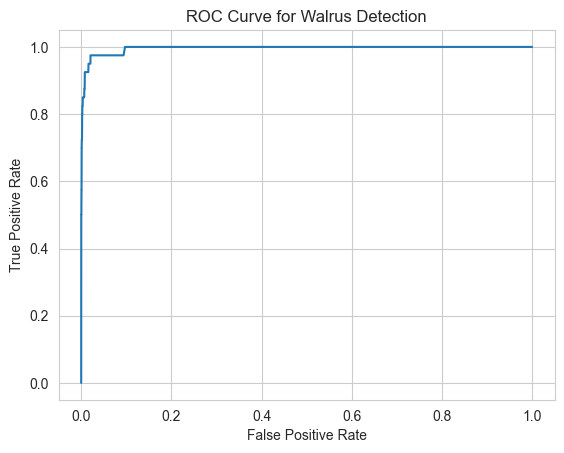

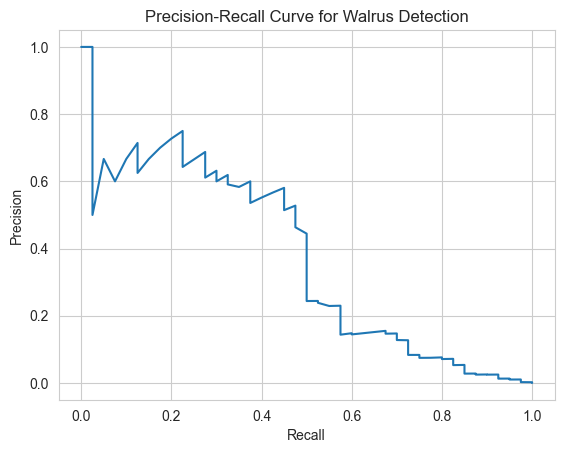

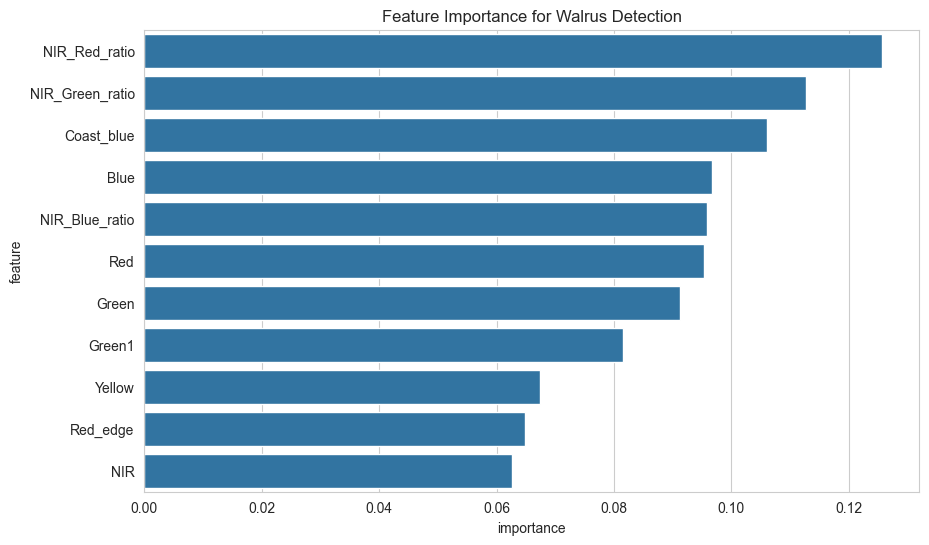

In [7]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print Metrics
print("RF Model")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()






# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve for walrus class
walrus_index = list(le.classes_).index('walrus_pure')  # Adjust if necessary
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, walrus_index], pos_label=walrus_index)
plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC Curve for Walrus Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Precision-Recall curve for walrus class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, walrus_index], pos_label=walrus_index)
plt.figure()
plt.plot(recall, precision)
plt.title('Precision-Recall Curve for Walrus Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Feature Importance
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Walrus Detection')
plt.show()


In [14]:

# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        
        # Add band ratios
        image_df = pd.DataFrame(image_reshaped, columns=['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR'])
        image_df = add_band_ratios(image_df)
        
        predictions = model.predict(image_df)
        return predictions.reshape((src.height, src.width))



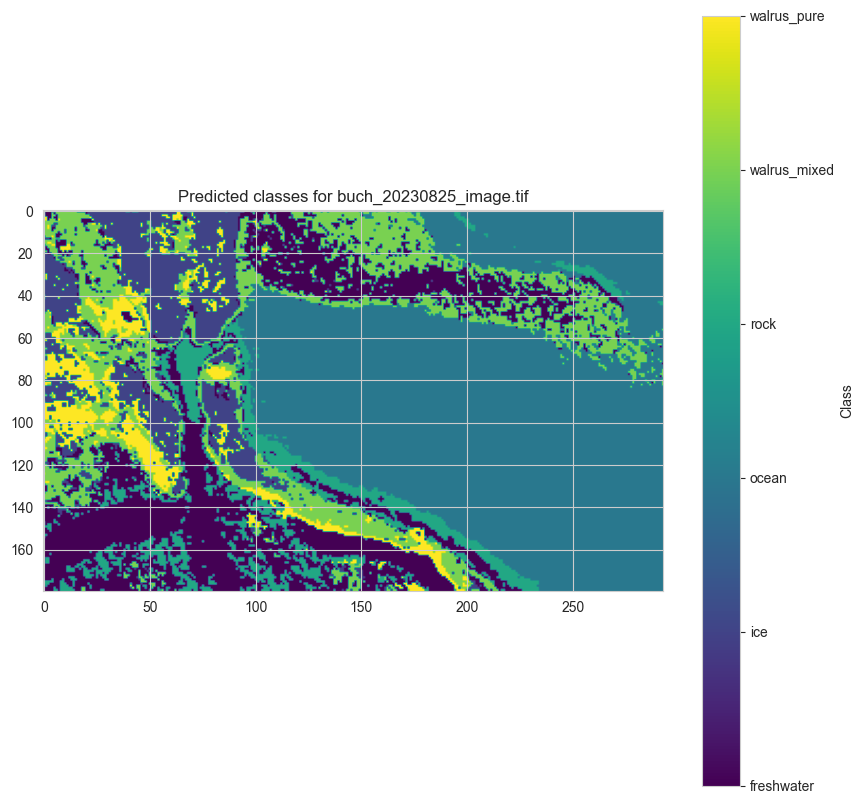

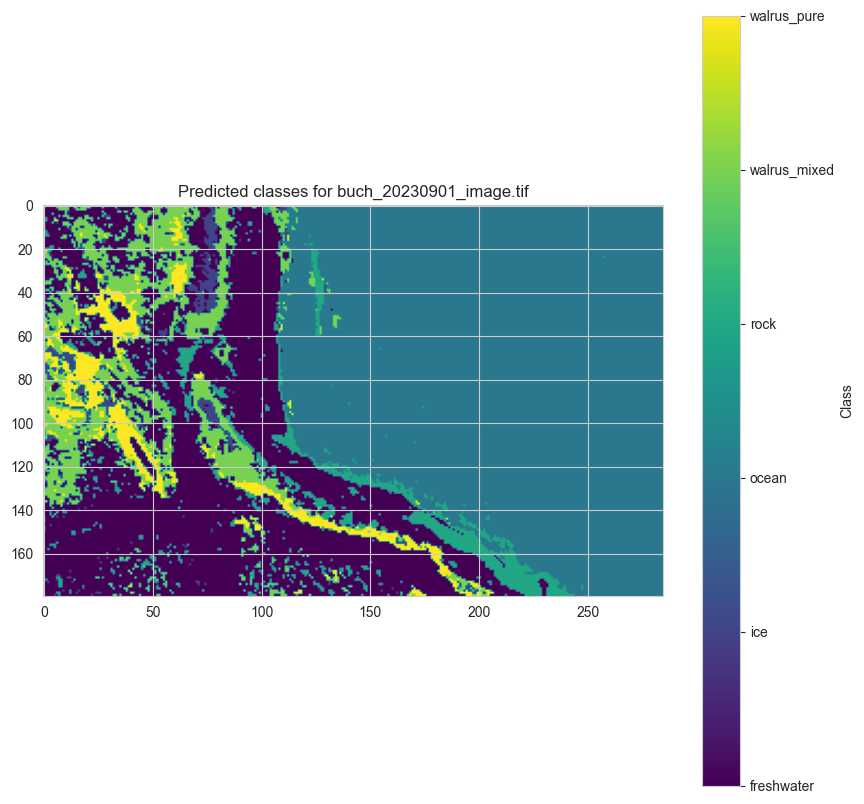

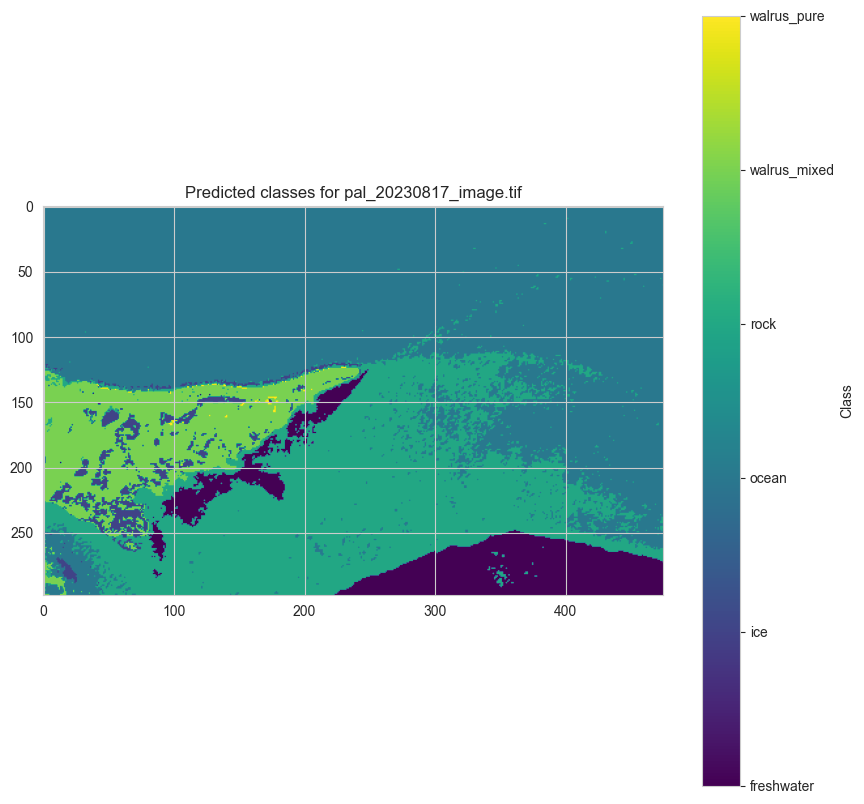

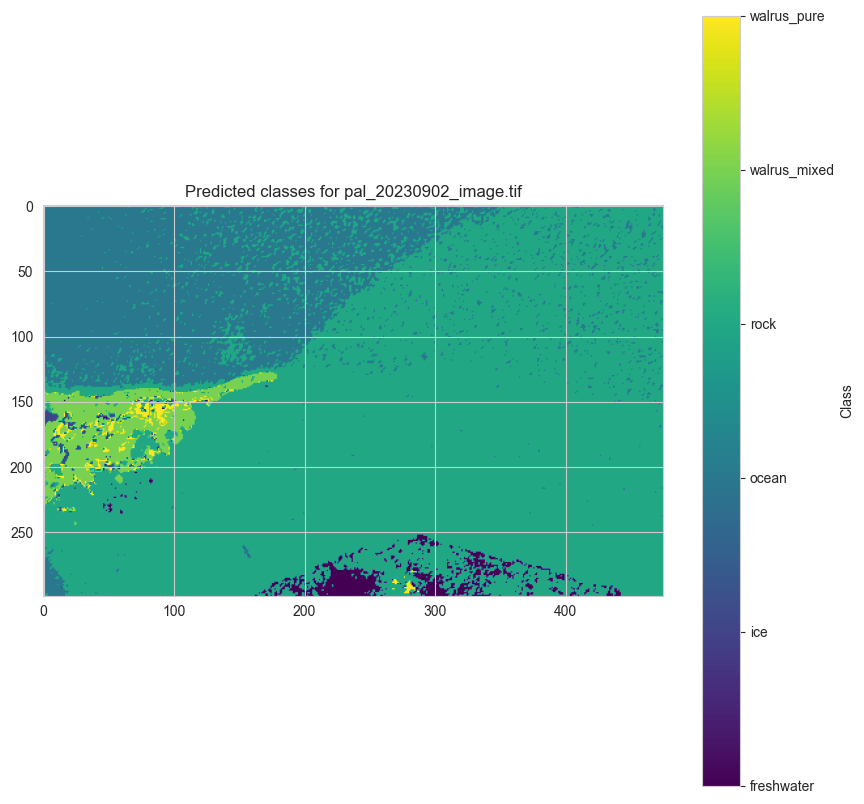

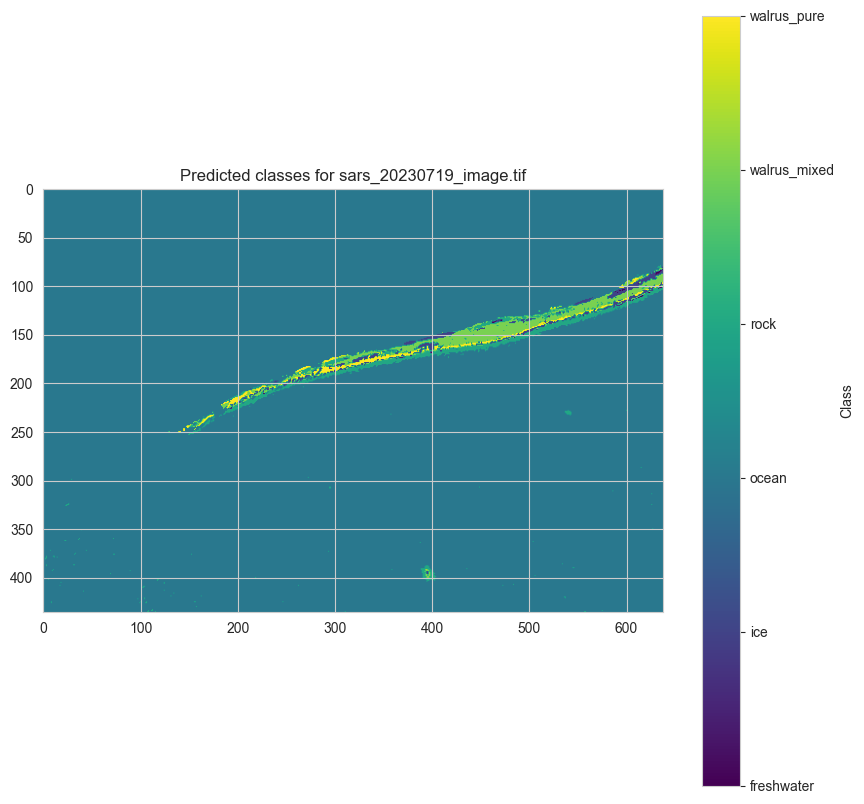

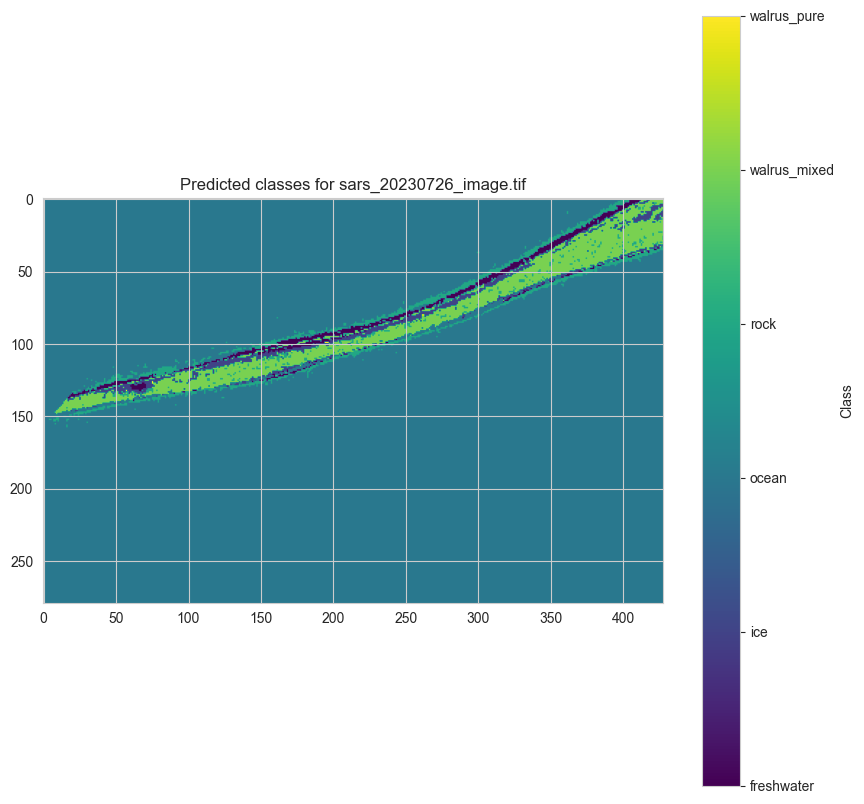

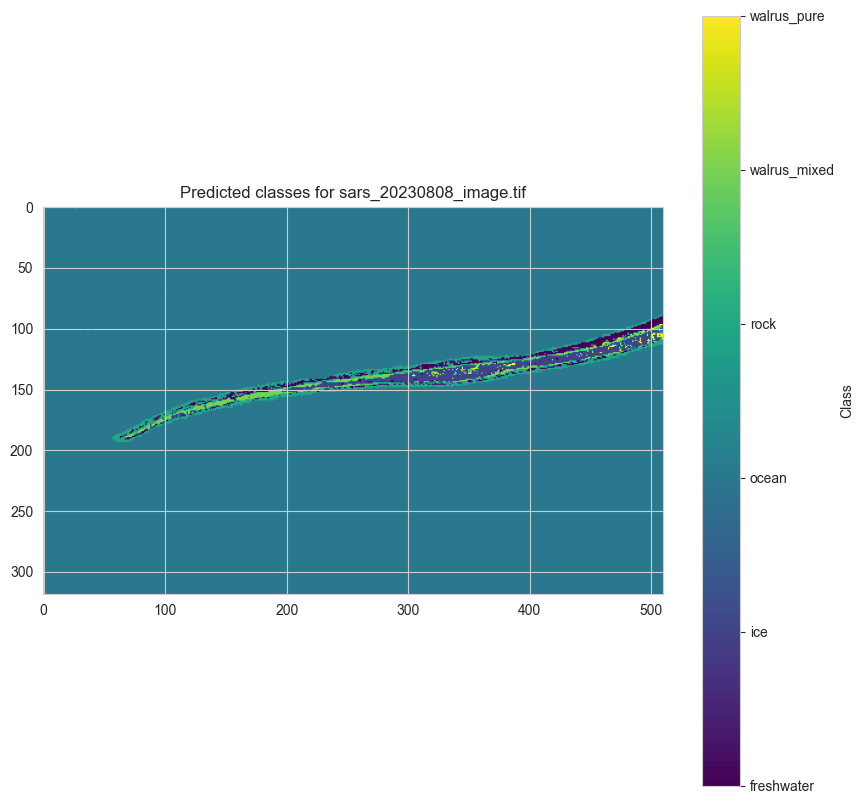

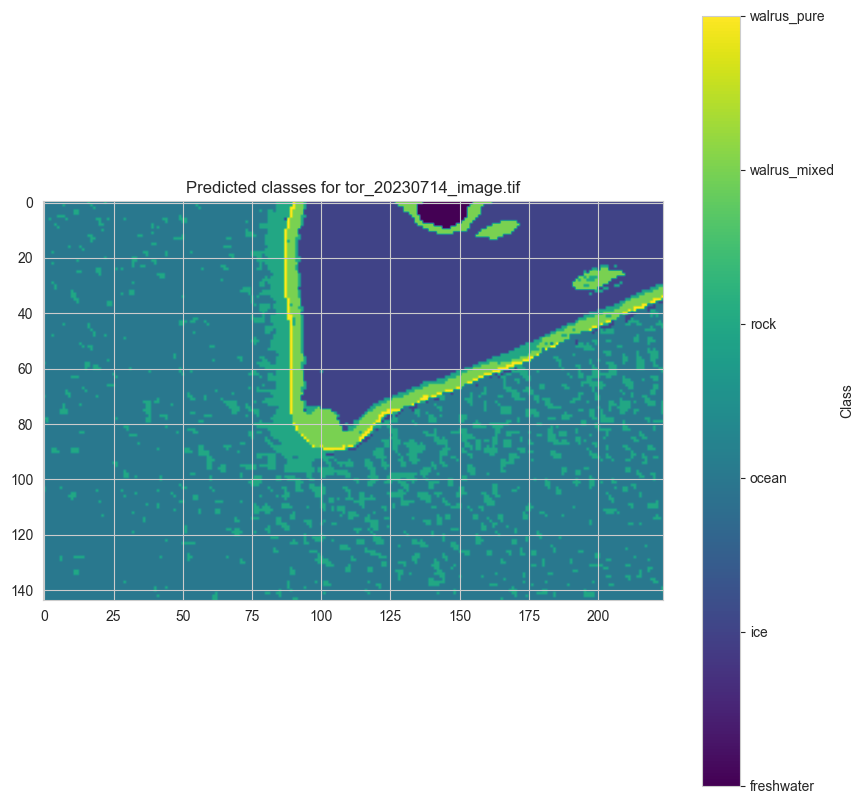

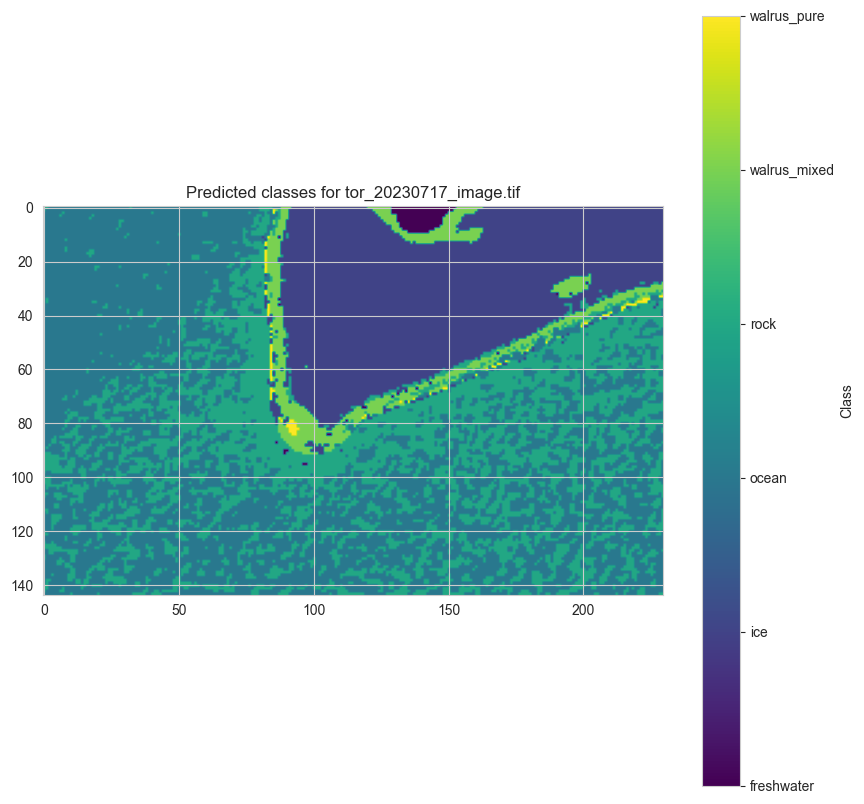

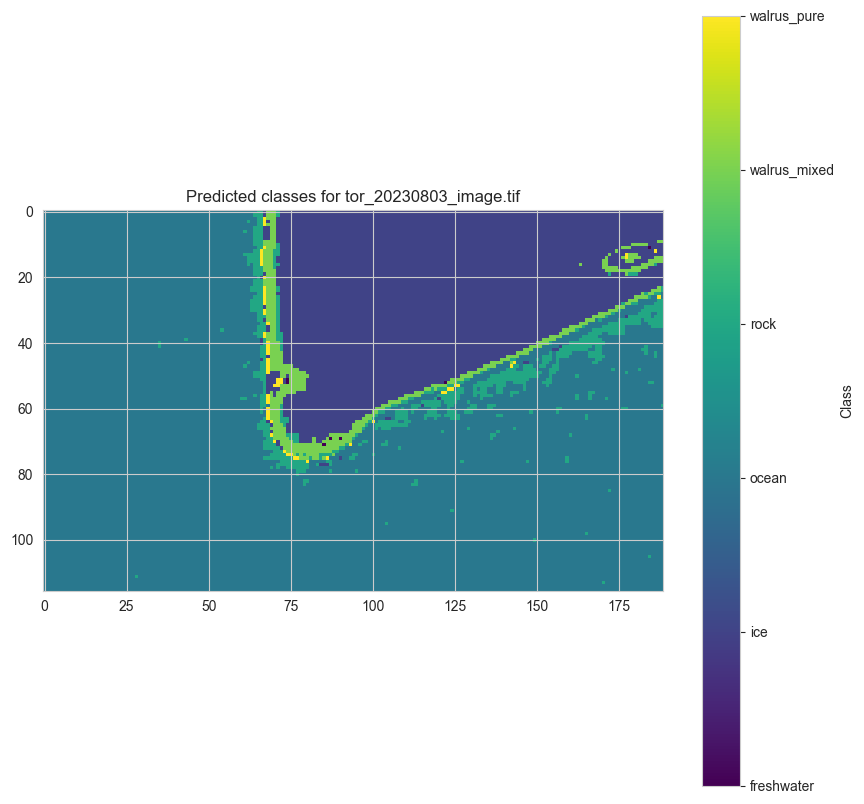

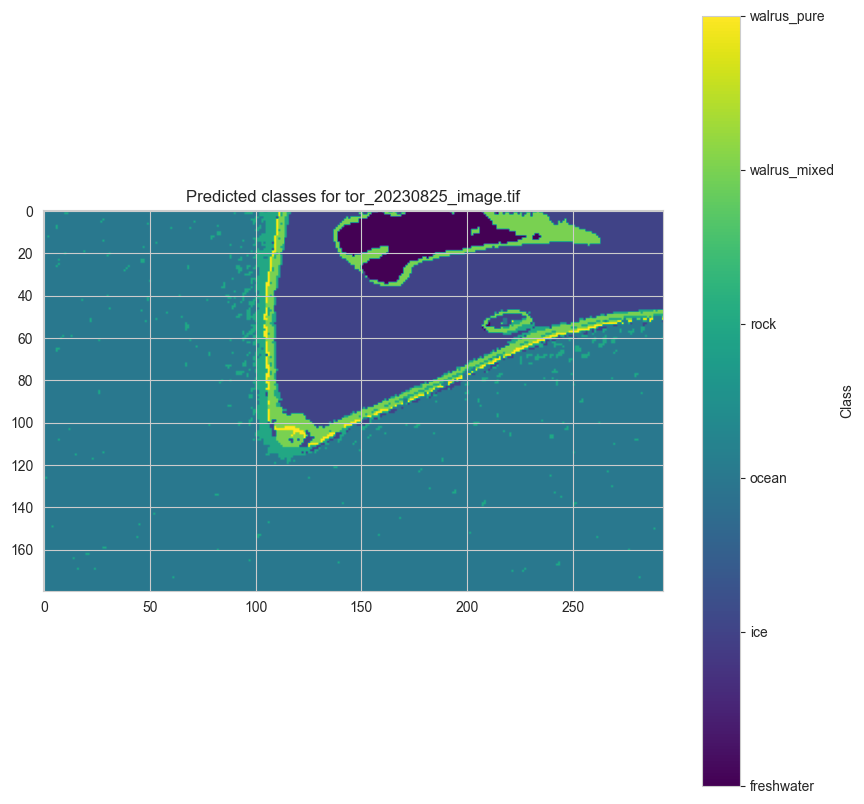

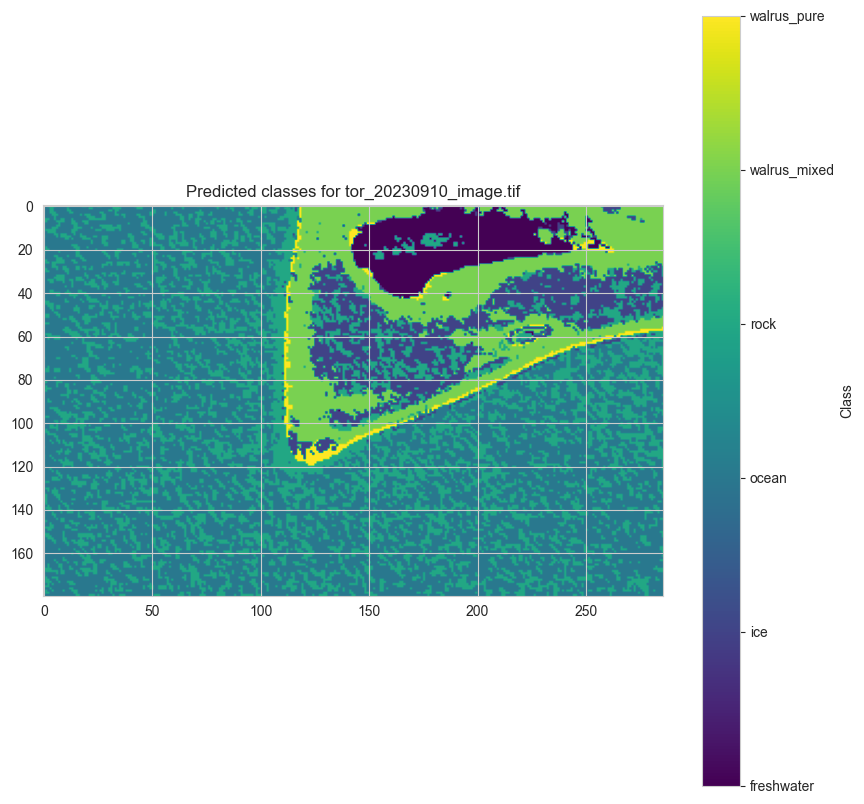

In [15]:
# Predict and visualize unlabeled images
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, best_rf_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap='viridis', vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

In [33]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.geometry import shape
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib
import multiprocessing
from joblib import Parallel, delayed

In [21]:
# Define directories and file paths
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# List all .tif and .shp files
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    return (match.group(1), match.group(2)) if match else (None, None)

# Pair image and shapefile paths
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island and date:
            matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
            if matching_shapefiles:
                file_pairs[image_path] = matching_shapefiles[0]
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus files
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island and date:
            matching_images = [image for image in image_paths if island in image and date in image]
            if matching_images:
                file_pairs[matching_images[0]] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features_list = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        geometry = shape(row['geometry'])
        mask = features.geometry_mask([geometry], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask.astype(bool)]
        label = row['label']

        for pixel in feature_pixels.T:
            features_list.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features_list), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [22]:
def add_advanced_features_optimized(df):
    # Create a copy of the dataframe with only numeric columns
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Add advanced features
    numeric_df['NIR_Green_ratio'] = np.divide(numeric_df['NIR'], numeric_df['Green'] + epsilon)
    numeric_df['NIR_Red_ratio'] = np.divide(numeric_df['NIR'], numeric_df['Red'] + epsilon)
    numeric_df['NIR_Blue_ratio'] = np.divide(numeric_df['NIR'], numeric_df['Blue'] + epsilon)
    numeric_df['NDVI'] = np.divide((numeric_df['NIR'] - numeric_df['Red']), (numeric_df['NIR'] + numeric_df['Red'] + epsilon))
    numeric_df['NDWI'] = np.divide((numeric_df['Green'] - numeric_df['NIR']), (numeric_df['Green'] + numeric_df['NIR'] + epsilon))
    numeric_df['EVI'] = np.divide(2.5 * (numeric_df['NIR'] - numeric_df['Red']), (numeric_df['NIR'] + 6*numeric_df['Red'] - 7.5*numeric_df['Blue'] + 1 + epsilon))
    
    # Replace infinities and fill NaNs
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.mean())
    
    # Merge the new features back into the original dataframe
    return pd.concat([df, numeric_df[['NIR_Green_ratio', 'NIR_Red_ratio', 'NIR_Blue_ratio', 'NDVI', 'NDWI', 'EVI']]], axis=1)

# Split dataset into chunks for parallel processing
def split_dataframe(df, chunk_size=200):
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

# Parallel processing of the advanced feature addition
def process_chunks(chunks):
    num_cores = multiprocessing.cpu_count()
    processed_chunks = Parallel(n_jobs=num_cores)(delayed(add_advanced_features_optimized)(chunk) for chunk in chunks)
    return pd.concat(processed_chunks)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7]
})

# Add non-numeric columns separately
dataset['labels'] = labels
dataset['encoded_labels'] = encoded_labels
dataset['image_name'] = image_name

# Split and process in parallel
dataset_chunks = split_dataframe(dataset)
dataset_processed = process_chunks(dataset_chunks)

# Prepare features and labels for model training
X = dataset_processed.drop(columns=['labels', 'encoded_labels', 'image_name'])
y = dataset_processed['encoded_labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

In [23]:
# Define parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Save the model
model_filename = "RF_walrus_detector0507.joblib"
joblib.dump(best_rf_model, model_filename)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


['RF_walrus_detector0507.joblib']

In [24]:
# Load the saved model
best_rf_model = joblib.load("RF_walrus_detector0507.joblib")

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print("\n")

Best Hyperparameters:
max_depth: 19
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 99


In [25]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)


# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Model Performance Metrics:
Accuracy: 0.9854264174210364
Precision: 0.9851717013980225
Recall: 0.9854264174210364
F1 Score: 0.9849245023186877
Cohen's Kappa: 0.9740087459211446

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.84      0.87      6570
         ice       0.97      0.99      0.98     47214
       ocean       1.00      1.00      1.00    106611
        rock       0.98      0.97      0.98     17808
walrus_mixed       0.96      0.14      0.24       157
 walrus_pure       0.44      0.09      0.15        45

    accuracy                           0.99    178405
   macro avg       0.88      0.67      0.70    178405
weighted avg       0.99      0.99      0.98    178405


Model Performance Metrics:
Accuracy: 0.9854264174210364
Precision: 0.9851717013980225
Recall: 0.9854264174210364
F1 Score: 0.9849245023186877
Cohen's Kappa: 0.9740087459211446

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.84      0.87      6570
         ice       0.97      0.99      0.98     47214
       ocean       1.00      1.00      1.00    106611
        rock       0.98      0.97      0.98     17808
walrus_mixed       0.96      0.14      0.24       157
 walrus_pure       0.44      0.09      0.15        45

    accuracy                           0.99    178405
   macro avg       0.88      0.67      0.70    178405
weighted avg       0.99      0.99      0.98    178405


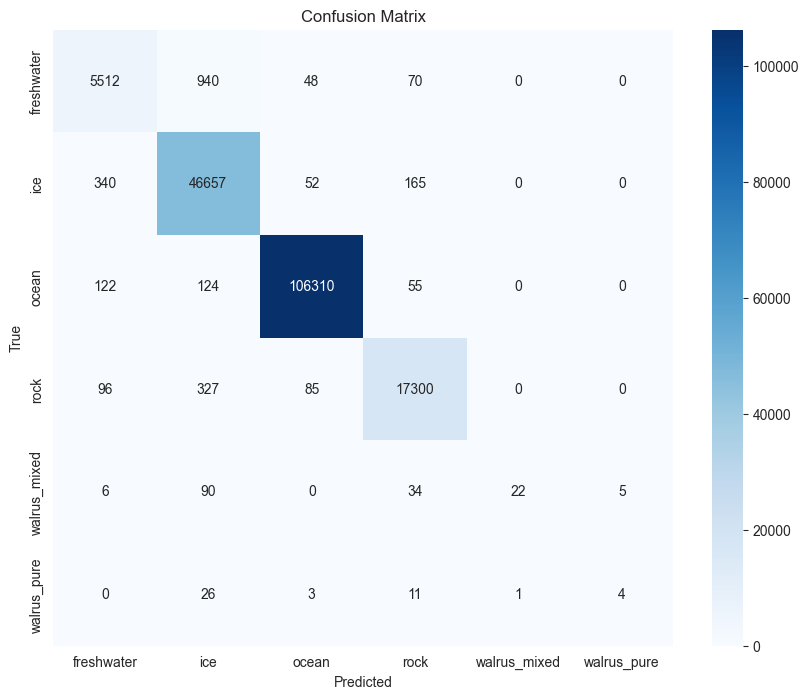

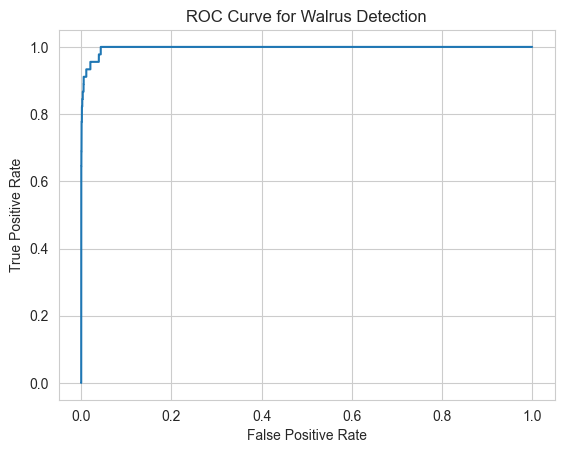

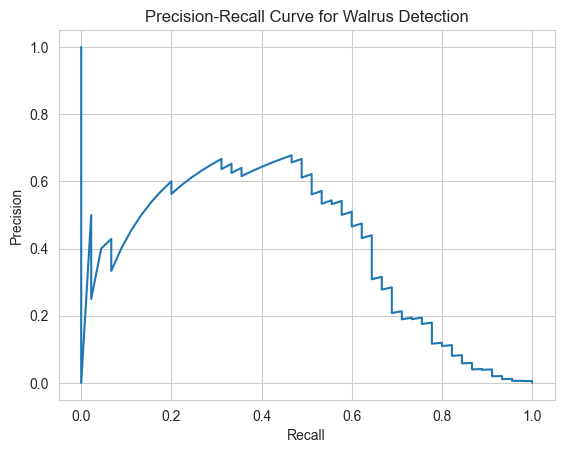

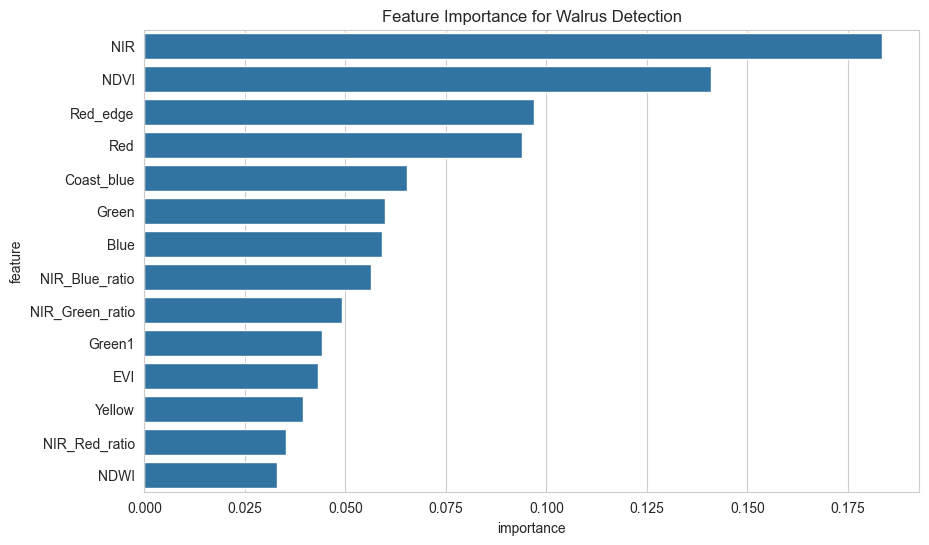

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve for walrus class (Assuming 'walrus_pure' is the class of interest)
walrus_index = list(le.classes_).index('walrus_pure')  # Adjust if necessary
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, walrus_index], pos_label=walrus_index)
plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC Curve for Walrus Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Precision-Recall curve for walrus class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, walrus_index], pos_label=walrus_index)
plt.figure()
plt.plot(recall, precision)
plt.title('Precision-Recall Curve for Walrus Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Feature Importance
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Walrus Detection')
plt.show()


Processing training images:

Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif
Image shape: (8, 445, 582)
Image reshaped for prediction: (258990, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        1353  1171    1385   1371    1572  1445      1471  1646
1        1367  1142    1378   1334    1555  1414      1450  1637
2        1384  1114    1360   1306    1532  1391      1431  1535
3        1343  1093    1337   1316    1513  1375      1431  1500
4        1287  1068    1340   1297    1488  1336      1435  1486
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        1353  1171    1385   1371    1572  1445      1471  1646   
1        1367  1142    1378   1334    1555  1414      1450  1637   
2        1384  1114    1360   1306    1532  1391      1431  1535   
3        1343  1093    1337   1316    1513  1375      1431  1500   
4  

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4 5]
Unique labels in processed image: [0 1 2 3 4]
Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


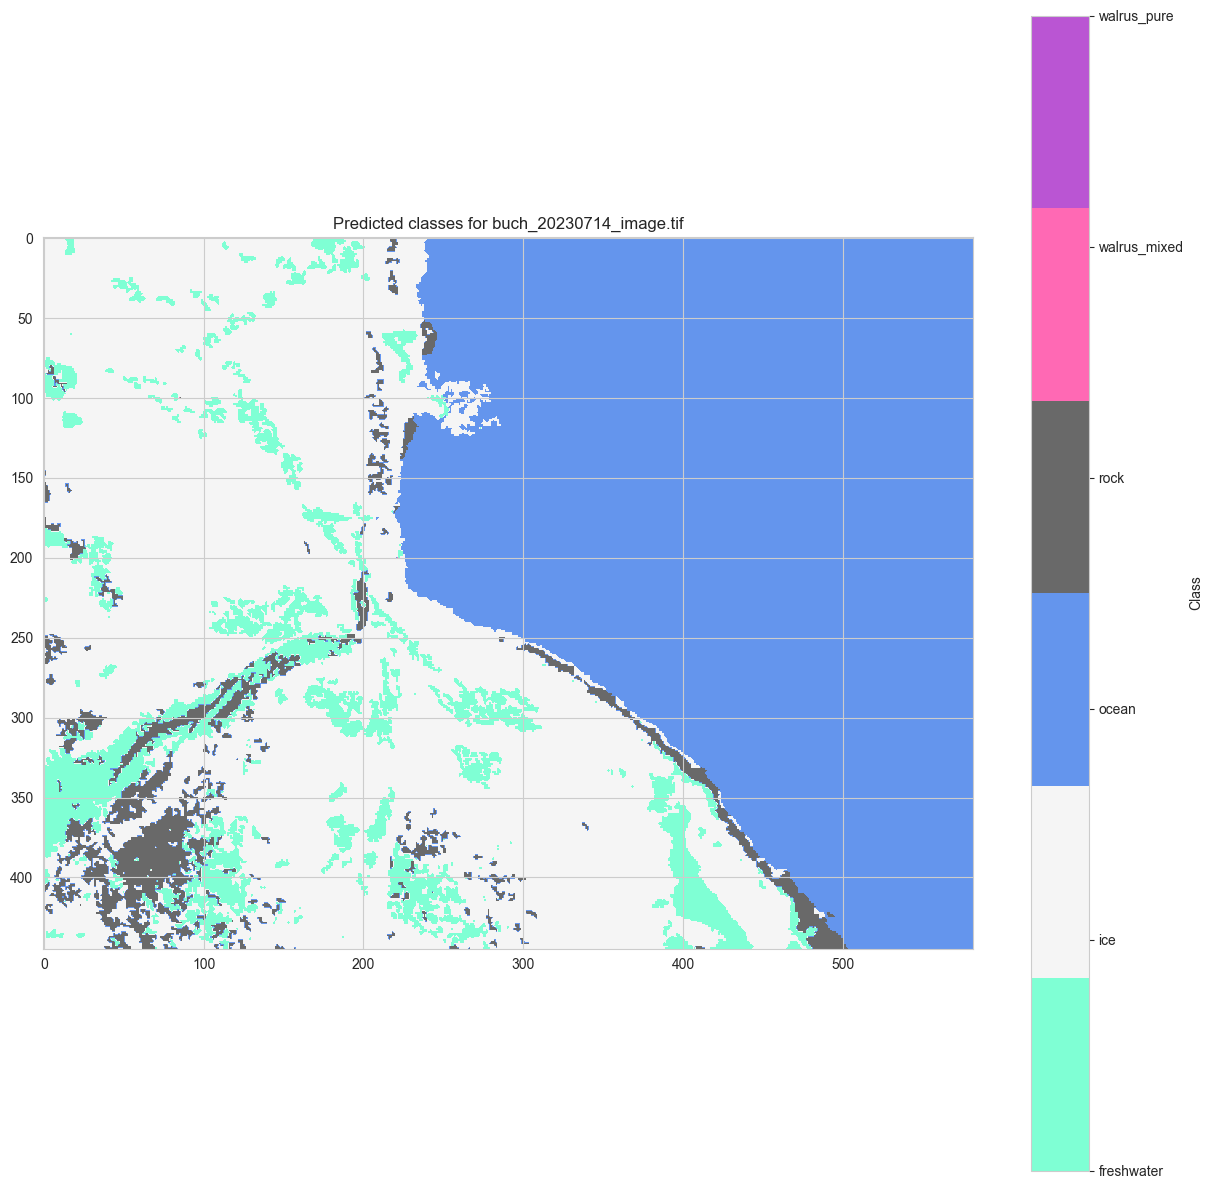


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif
Image shape: (8, 556, 728)
Image reshaped for prediction: (404768, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        1284  1189    1464   1466    1733  1572      1601  1658
1        1266  1170    1449   1475    1717  1566      1605  1680
2        1315  1144    1453   1452    1704  1567      1528  1702
3        1317  1138    1480   1444    1700  1566      1541  1694
4        1271  1156    1500   1467    1697  1550      1589  1742
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        1284  1189    1464   1466    1733  1572      1601  1658   
1        1266  1170    1449   1475    1717  1566      1605  1680   
2        1315  1144    1453   1452    1704  1567      1528  1702   
3        1317  1138    1480   1444    1700  1566      1541  1694   
4        1271  1156    1500   1

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [0 1 2 3 4]
Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


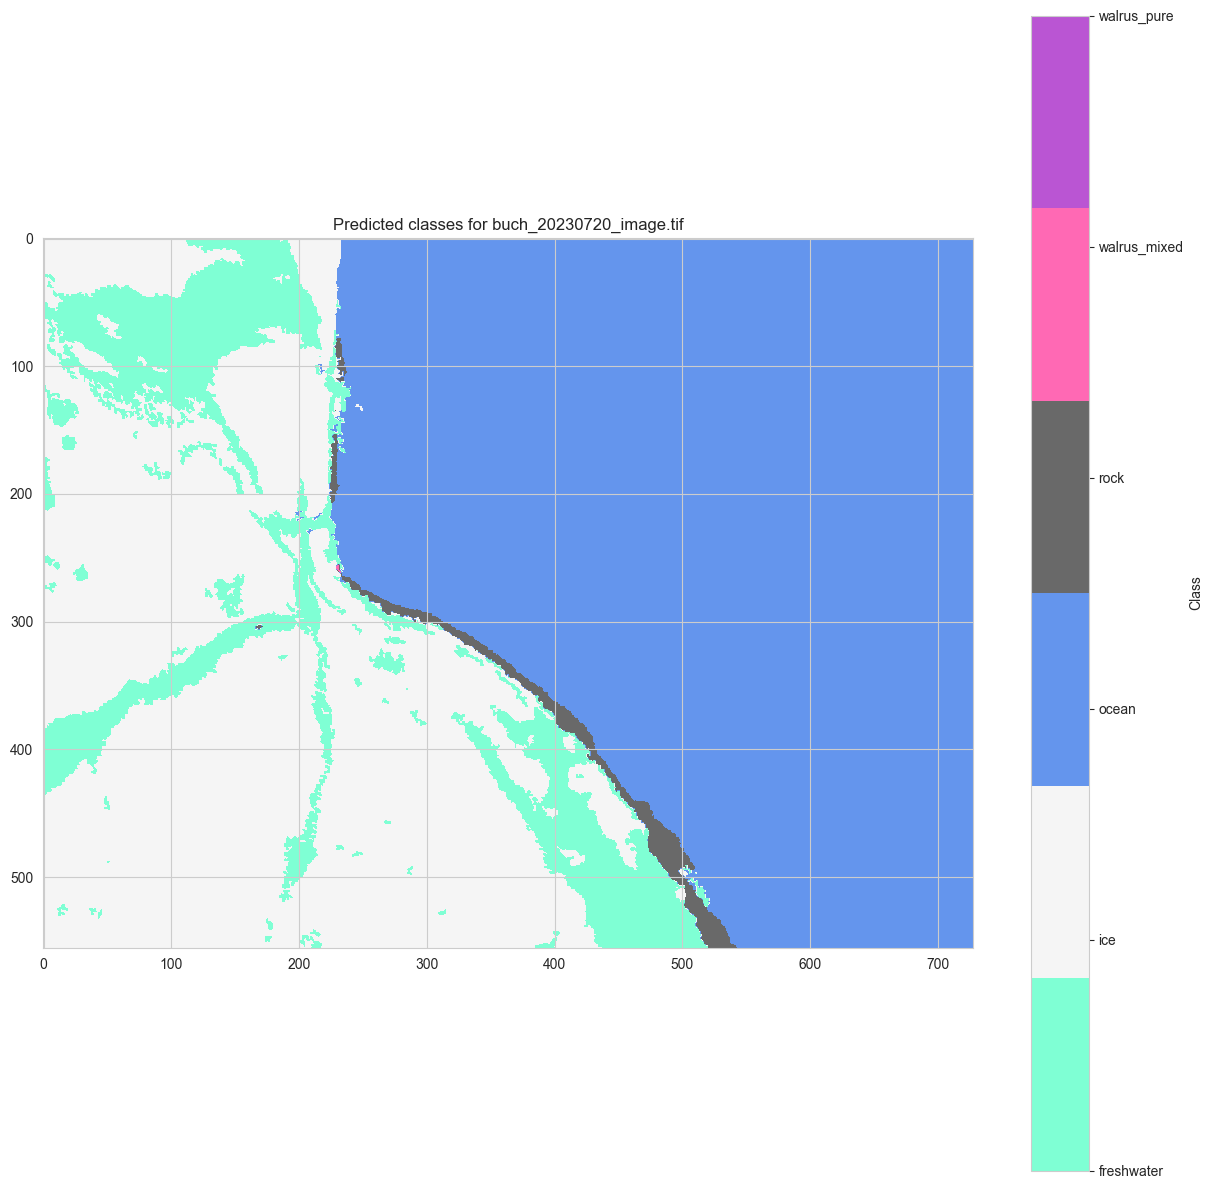


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif
Image shape: (8, 488, 639)
Image reshaped for prediction: (311832, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        1418  1395    1616   1779    1975  1760      1940  1942
1        1497  1396    1636   1768    1970  1791      1909  1922
2        1507  1443    1632   1763    1966  1833      1897  2040
3        1521  1466    1635   1768    1963  1840      1902  2109
4        1482  1423    1635   1735    1929  1749      1897  2036
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        1418  1395    1616   1779    1975  1760      1940  1942   
1        1497  1396    1636   1768    1970  1791      1909  1922   
2        1507  1443    1632   1763    1966  1833      1897  2040   
3        1521  1466    1635   1768    1963  1840      1902  2109   
4        1482  1423    1635   1

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3]
Unique labels in processed image: [0 1 2 3]
Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


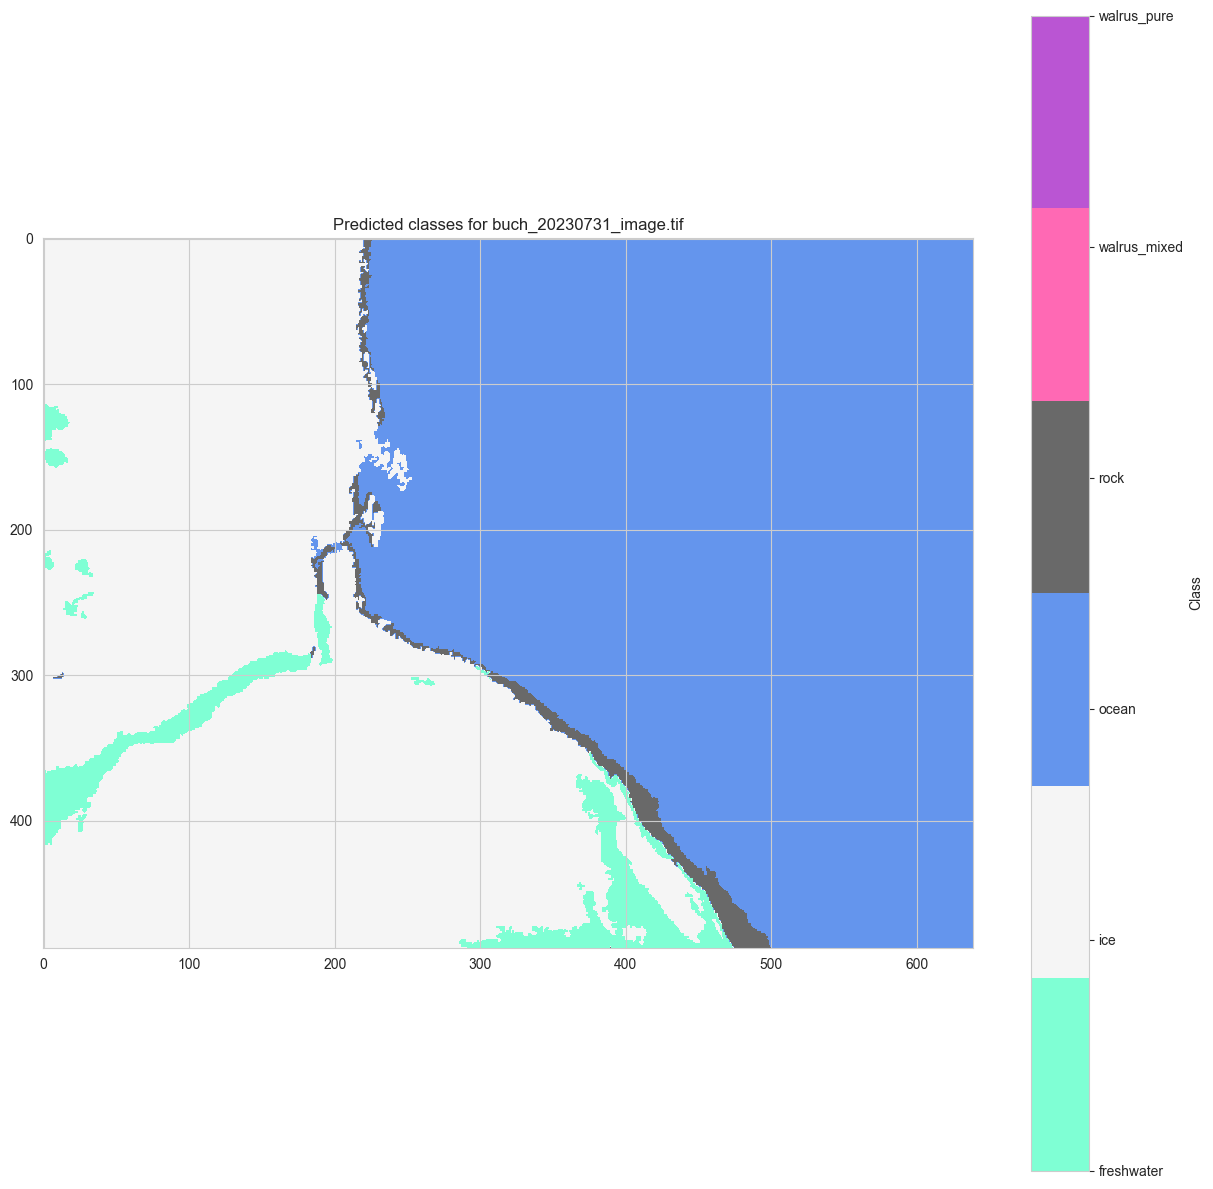


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif
Image shape: (8, 355, 466)
Image reshaped for prediction: (165430, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        5940  5139    5211   4633    4872  3880      3607  3343
1        5937  5152    5219   4622    4832  3918      3748  3241
2        6016  5174    5191   4555    4754  3982      3812  3155
3        6097  5160    5146   4696    4790  3898      3725  3243
4        6102  5125    5126   4722    4828  3828      3806  3355
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        5940  5139    5211   4633    4872  3880      3607  3343   
1        5937  5152    5219   4622    4832  3918      3748  3241   
2        6016  5174    5191   4555    4754  3982      3812  3155   
3        6097  5160    5146   4696    4790  3898      3725  3243   
4        6102  5125    5126   4

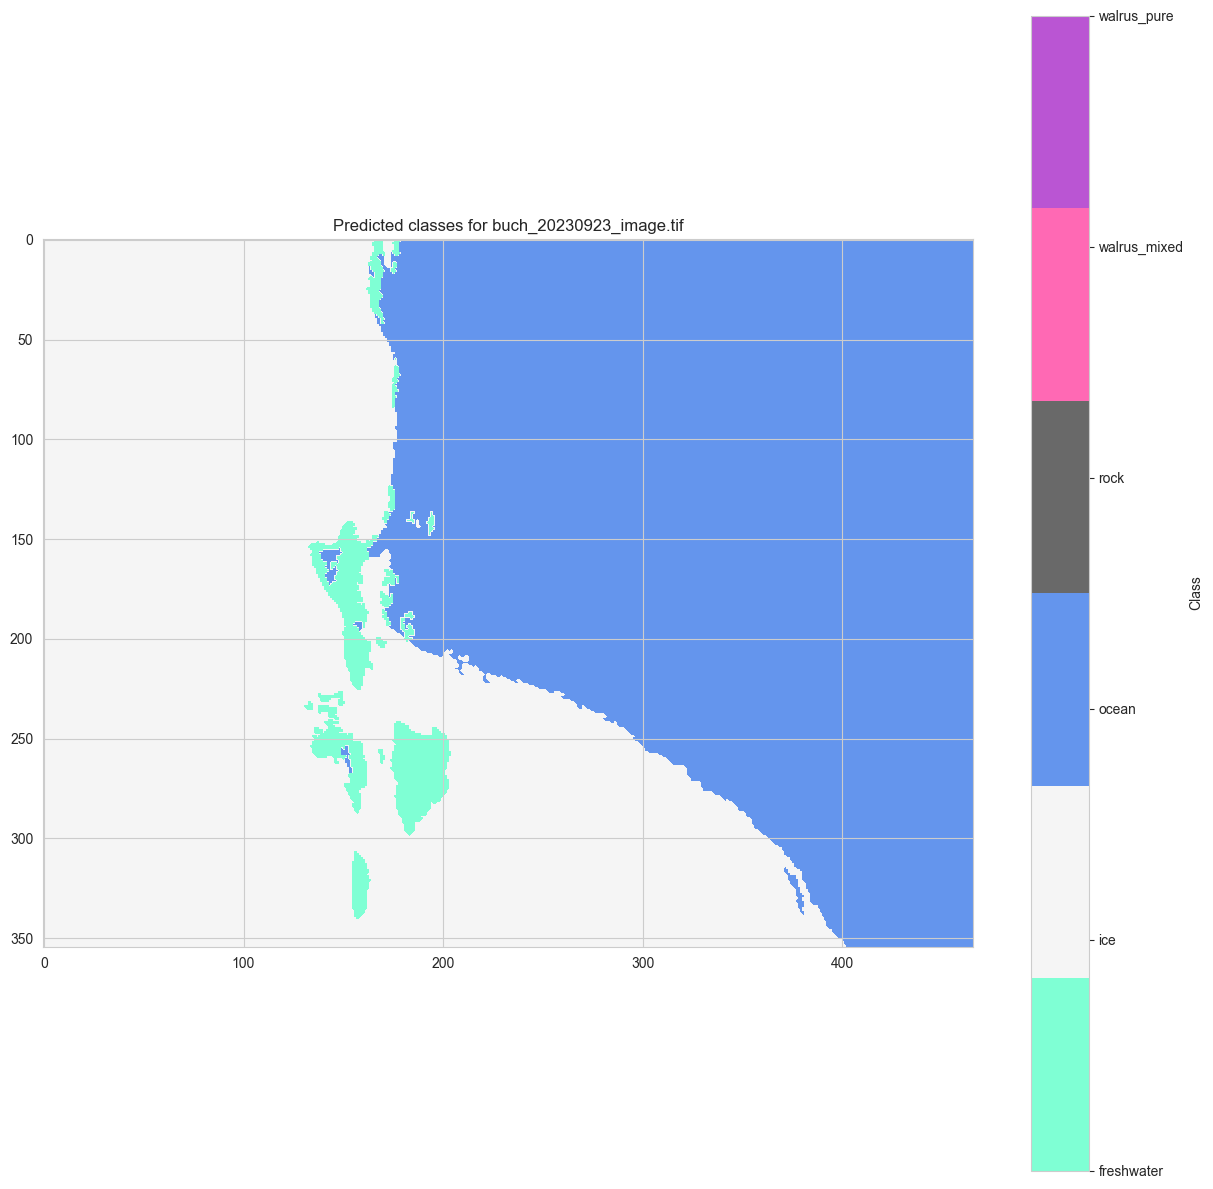


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif
Image shape: (8, 295, 446)
Image reshaped for prediction: (131570, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         539   352     440    285     260   64        40    9
1         583   342     438    284     283   78        31    3
2         588   346     442    273     280   81        68    1
3         544   349     447    261     272   68        79    1
4         518   361     451    271     276   56        72    1
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         539   352     440    285     260   64        40    9   
1         583   342     438    284     283   78        31    3   
2         588   346     442    273     280   81        68    1   
3         544   349     447    261     272   68        79    1   
4         518   361     451    271     276   56      

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [0 1 2 3]
Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


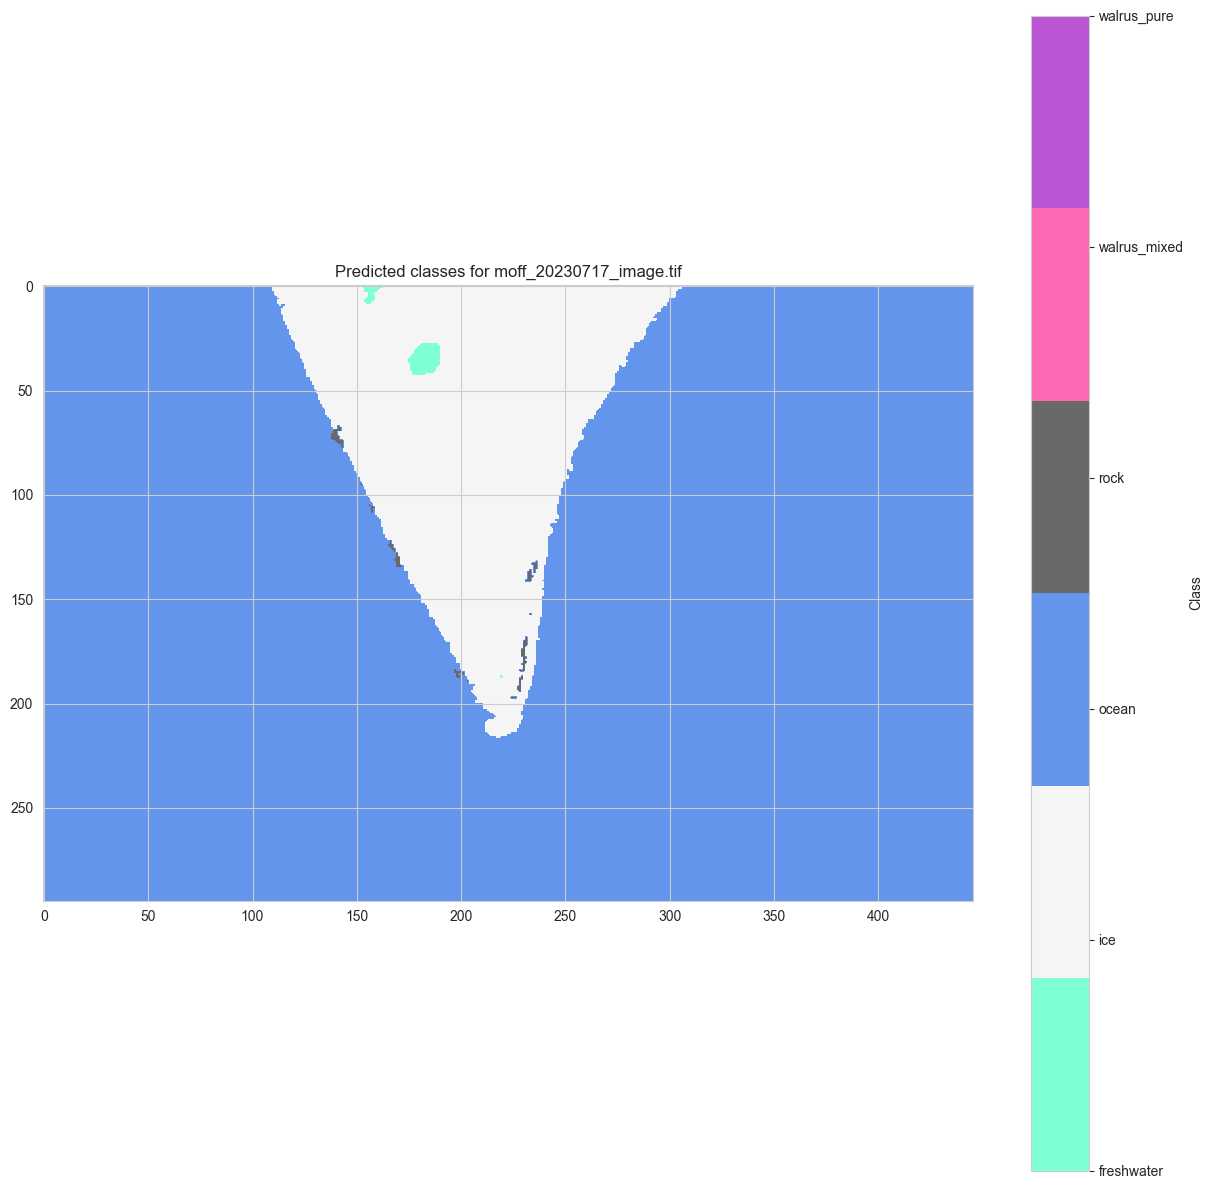


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230714_image.tif
Image shape: (8, 324, 492)
Image reshaped for prediction: (159408, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1309  1042    1213    929     874  547       415  225
1        1337  1028    1215    952     866  541       424  202
2        1374  1029    1230    965     862  548       443  215
3        1321  1044    1223    977     850  558       451  219
4        1342  1057    1225    965     861  551       434  198
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1309  1042    1213    929     874  547       415  225   
1        1337  1028    1215    952     866  541       424  202   
2        1374  1029    1230    965     862  548       443  215   
3        1321  1044    1223    977     850  558       451  219   
4        1342  1057    1225    965     861  551       

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [1 2 3 4]
Unique labels in processed image: [1 2 3 4]
Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


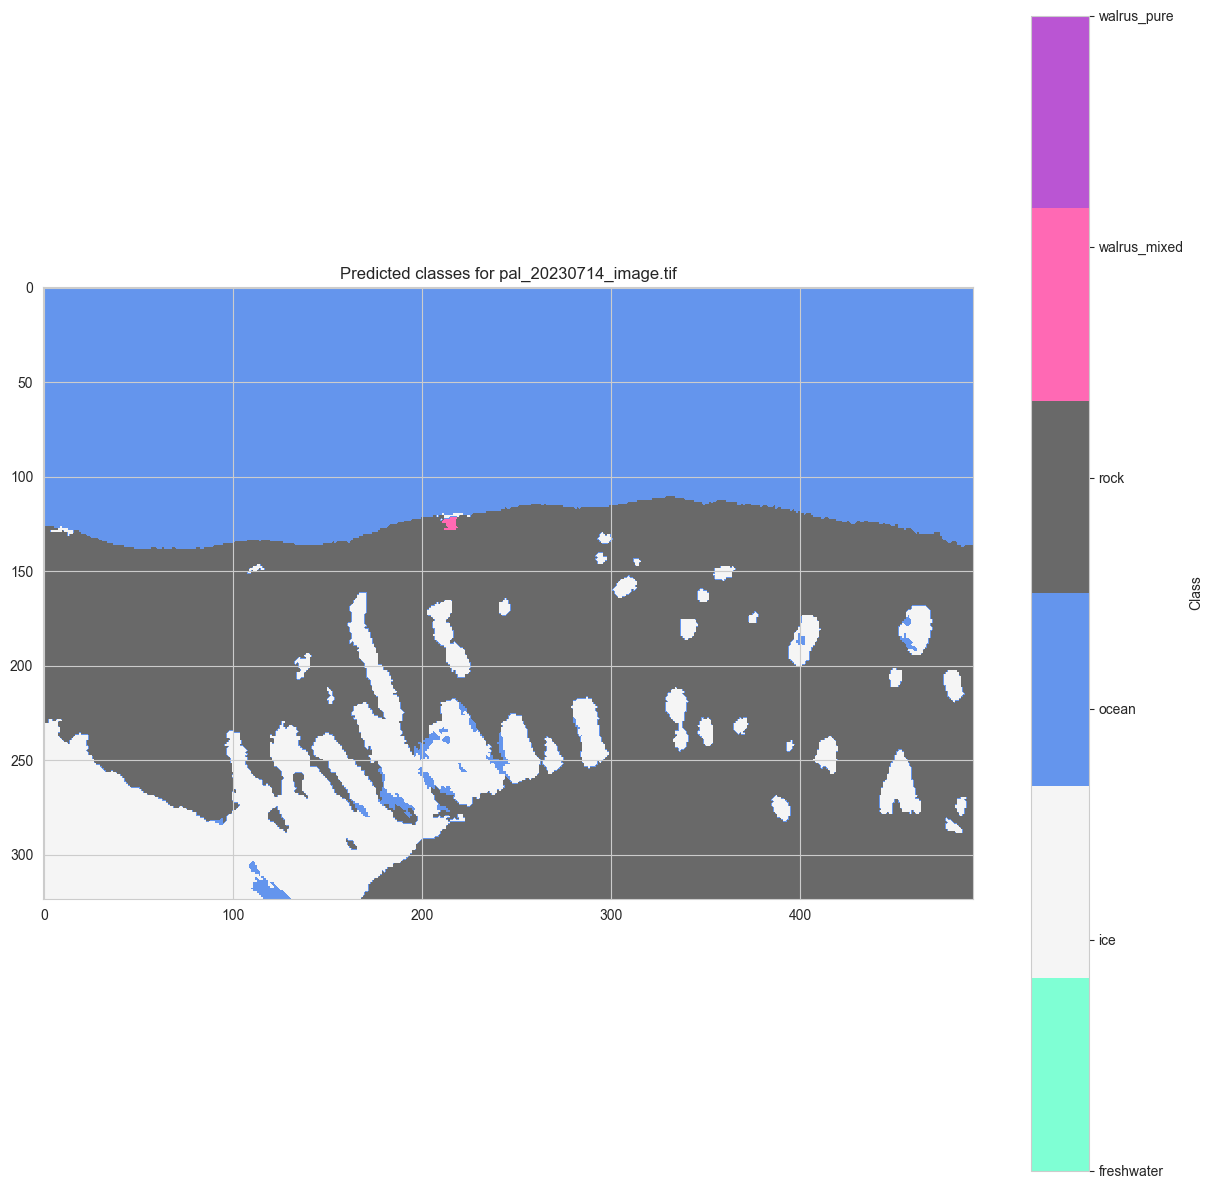


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230720_image.tif
Image shape: (8, 218, 342)
Image reshaped for prediction: (74556, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1678  1173    1590   1192    1344  764       641  359
1        1728  1167    1579   1204    1345  769       600  336
2        1743  1153    1563   1195    1343  758       619  315
3        1743  1122    1585   1213    1345  752       709  312
4        1742  1137    1601   1217    1340  747       701  362
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1678  1173    1590   1192    1344  764       641  359   
1        1728  1167    1579   1204    1345  769       600  336   
2        1743  1153    1563   1195    1343  758       619  315   
3        1743  1122    1585   1213    1345  752       709  312   
4        1742  1137    1601   1217    1340  747       7

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [1 2 3]
Labels present in pal_20230720_image.tif: ['ice', 'ocean', 'rock']


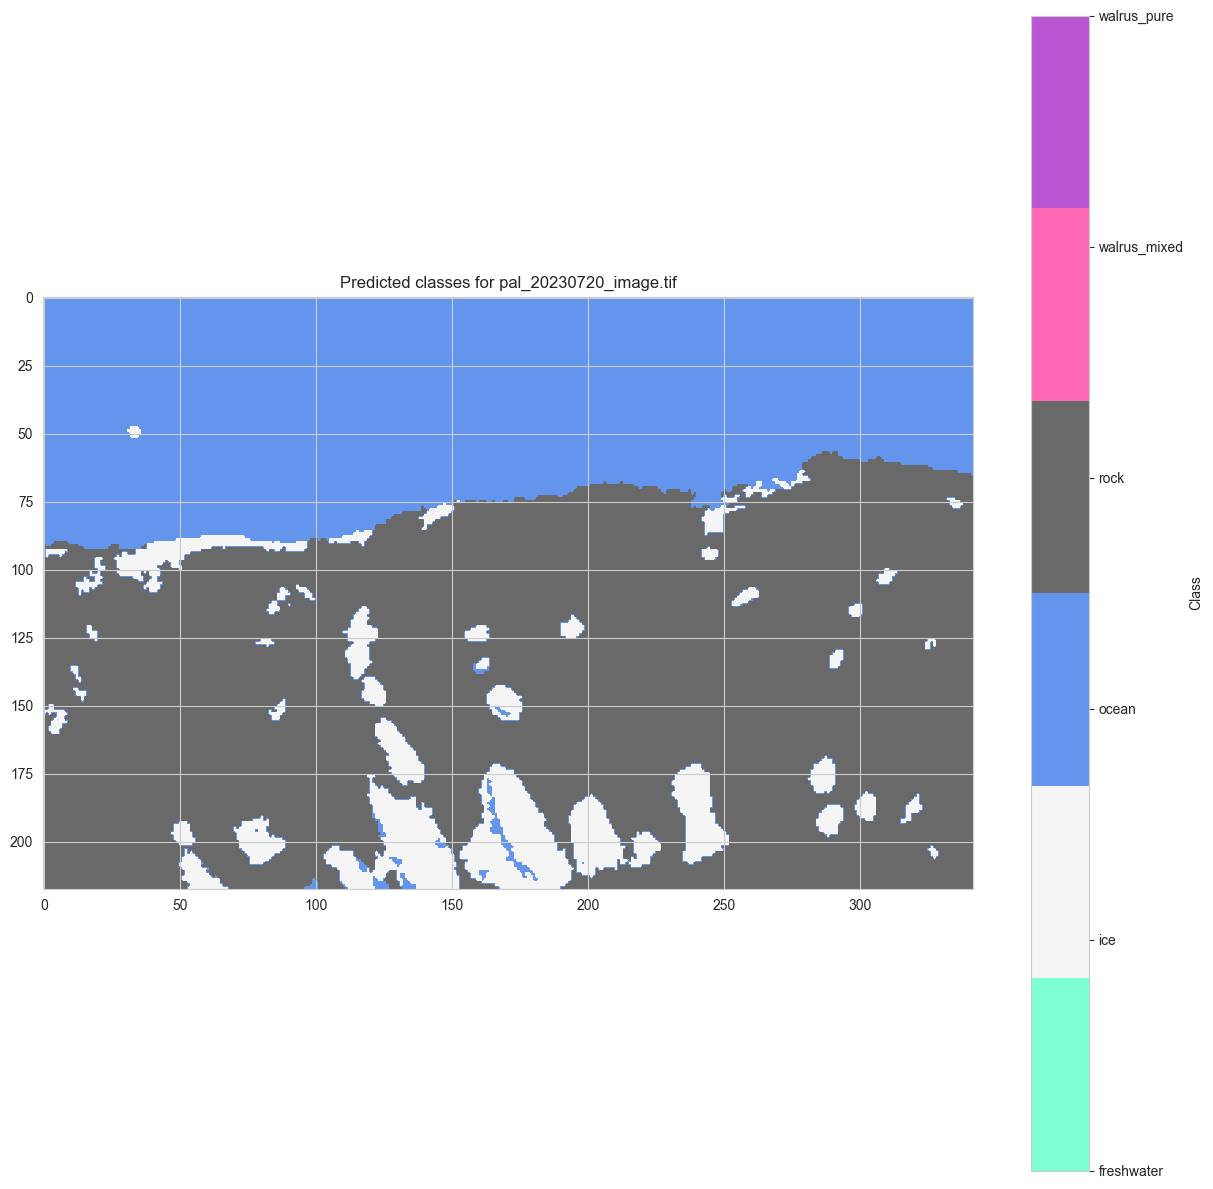


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230726_image.tif
Image shape: (8, 356, 540)
Image reshaped for prediction: (192240, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1440  1048    1195    969     941  444       442  248
1        1446  1048    1190    959     931  427       434  278
2        1395  1047    1190    945     943  408       441  264
3        1405  1051    1175    930     946  406       417  227
4        1411  1052    1151    926     924  430       388  212
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1440  1048    1195    969     941  444       442  248   
1        1446  1048    1190    959     931  427       434  278   
2        1395  1047    1190    945     943  408       441  264   
3        1405  1051    1175    930     946  406       417  227   
4        1411  1052    1151    926     924  430       

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4 5]
Unique labels in processed image: [1 2 3 5]
Labels present in pal_20230726_image.tif: ['ice', 'ocean', 'rock', 'walrus_pure']


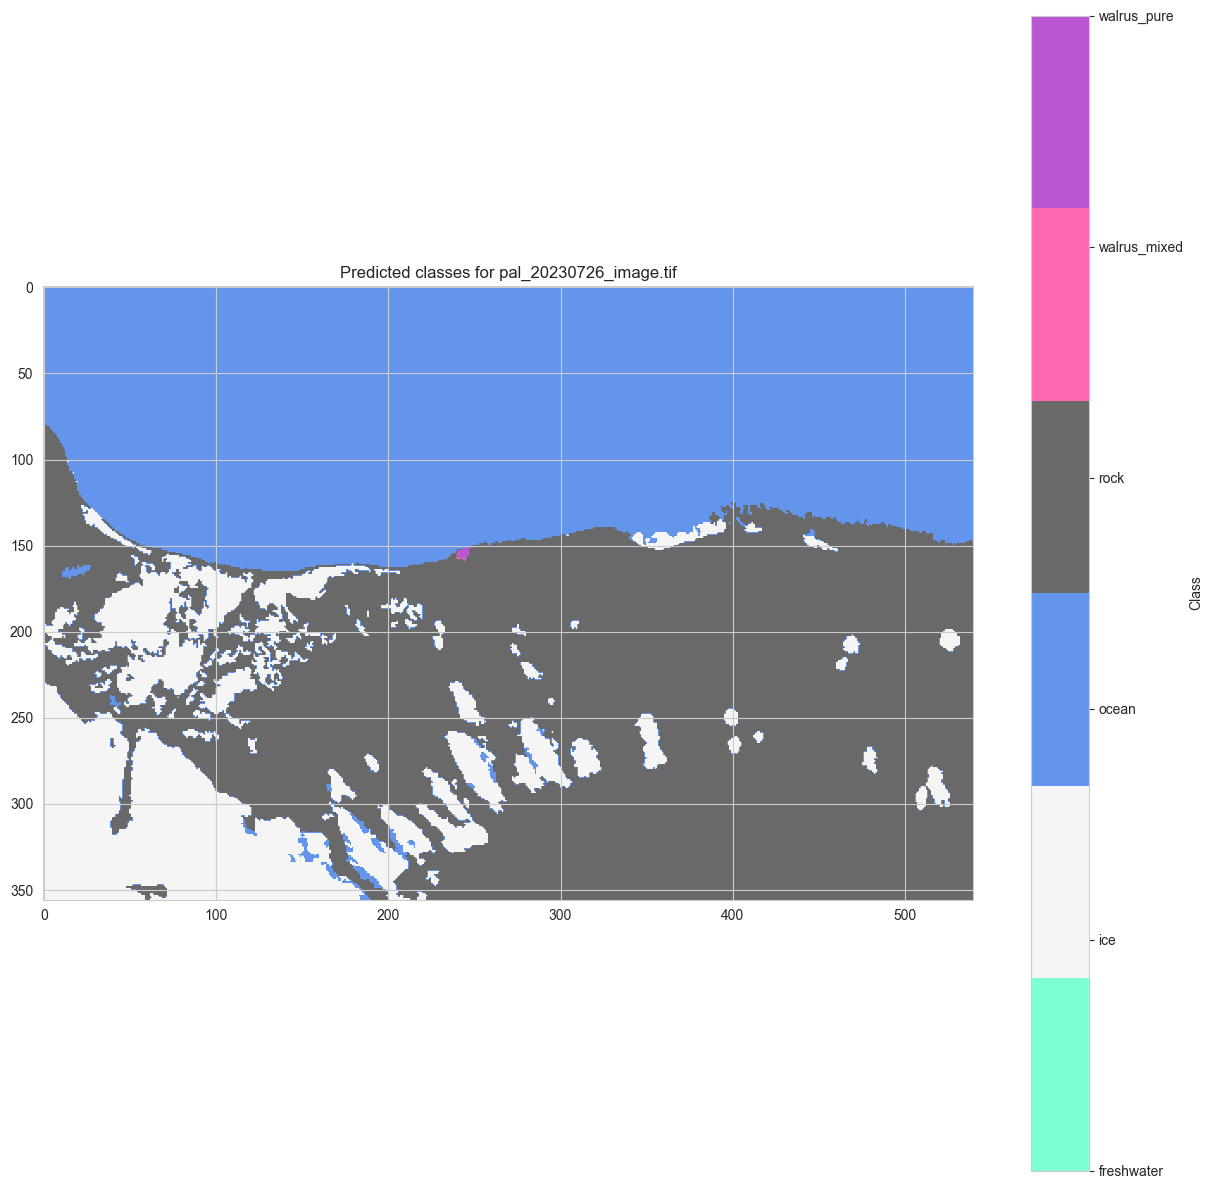


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230714_image.tif
Image shape: (8, 412, 590)
Image reshaped for prediction: (243080, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         701   422     557    290     256   89       188   48
1         718   420     554    307     258   93       111   29
2         685   420     541    338     240   95        48   34
3         666   432     547    324     224  100        79   35
4         738   432     549    313     246   91        70   19
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         701   422     557    290     256   89       188   48   
1         718   420     554    307     258   93       111   29   
2         685   420     541    338     240   95        48   34   
3         666   432     547    324     224  100        79   35   
4         738   432     549    313     246   91      

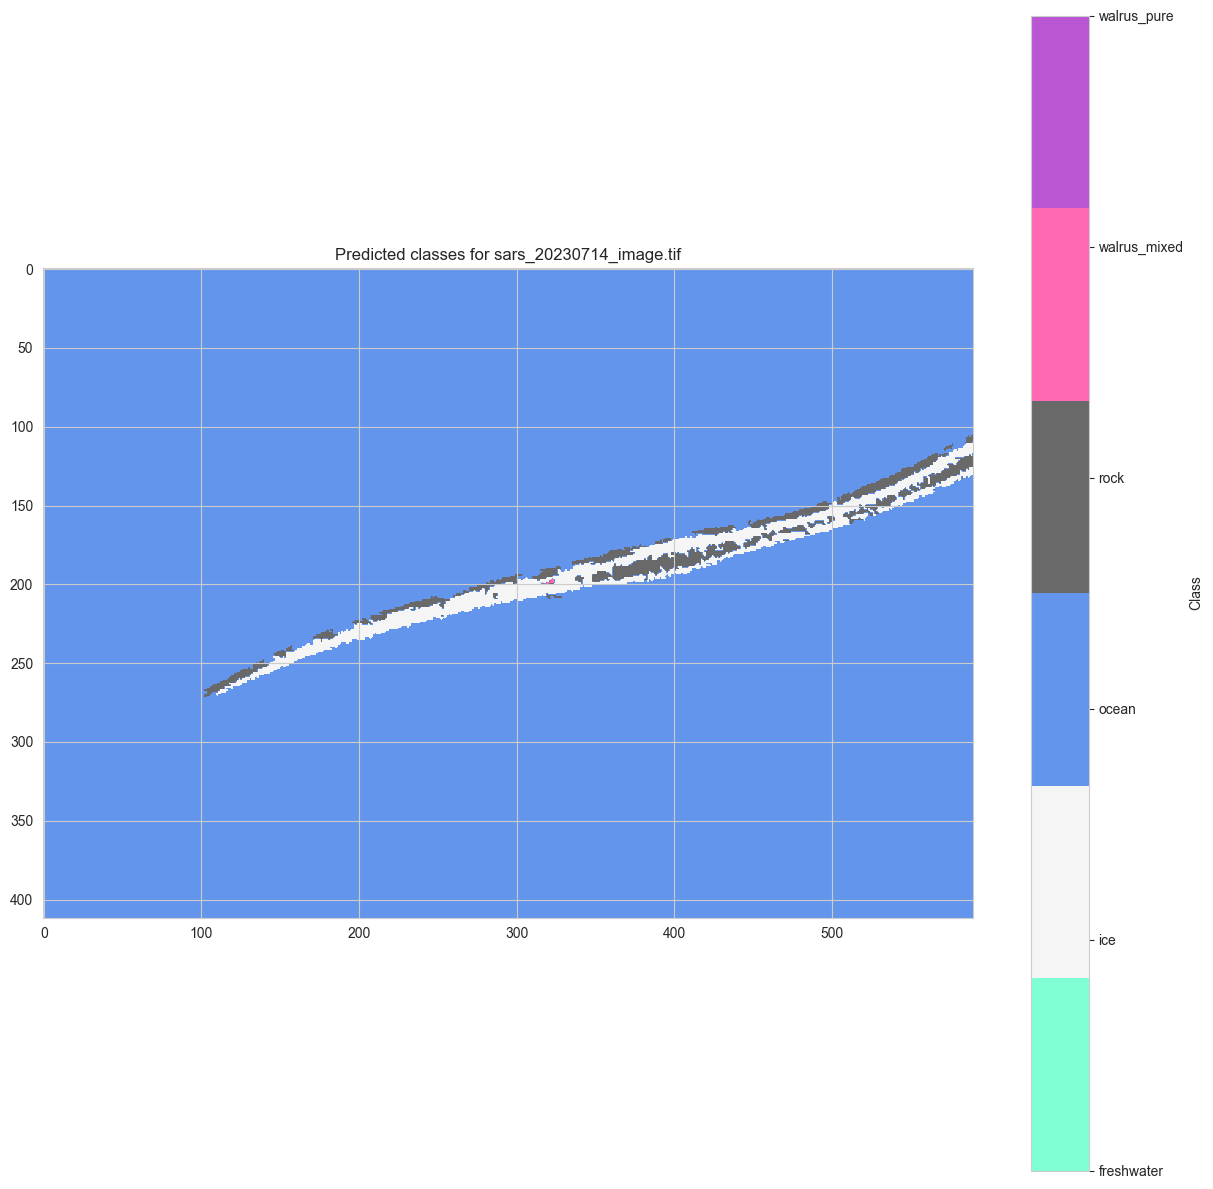


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230803_image.tif
Image shape: (8, 360, 433)
Image reshaped for prediction: (155880, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         579   499     453    305     292  107       142  199
1         607   494     444    300     312  137       165  132
2         605   487     431    298     320  127       142  121
3         590   492     433    295     292  100       162  152
4         585   508     422    300     288  119       149  174
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         579   499     453    305     292  107       142  199   
1         607   494     444    300     312  137       165  132   
2         605   487     431    298     320  127       142  121   
3         590   492     433    295     292  100       162  152   
4         585   508     422    300     288  119      

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [0 1 2 3]
Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


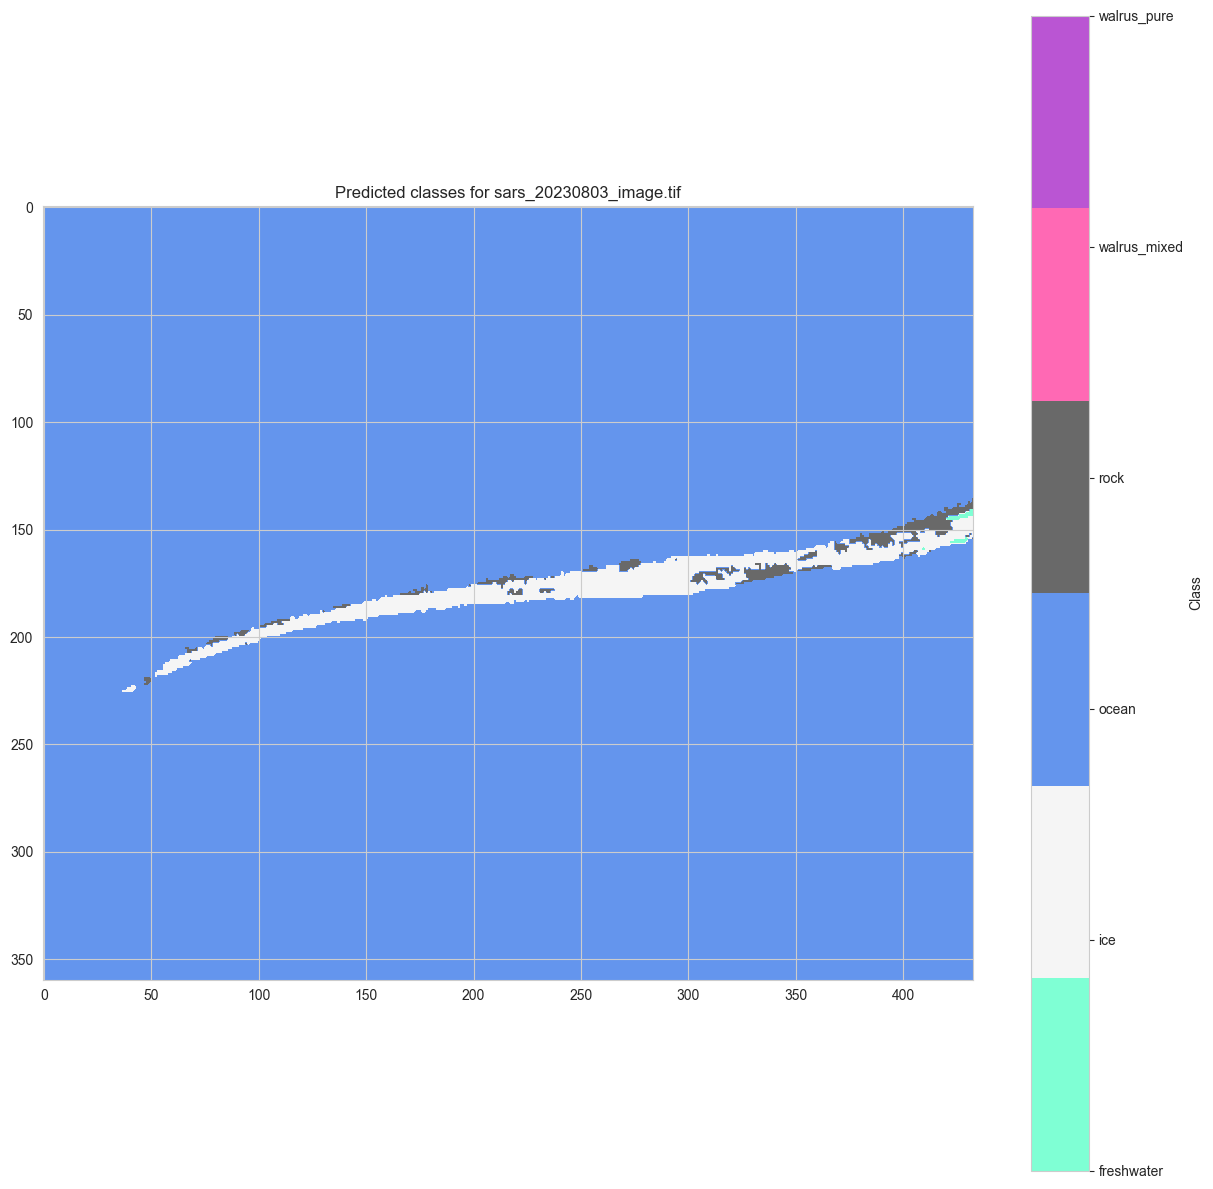


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230801_image.tif
Image shape: (8, 421, 495)
Image reshaped for prediction: (208395, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         672   567     570    426     346  254       157   80
1         721   570     558    437     354  246       180   94
2         696   583     573    430     361  213       206   93
3         656   593     574    423     358  224       186   75
4         700   583     549    423     347  234       162   66
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         672   567     570    426     346  254       157   80   
1         721   570     558    437     354  246       180   94   
2         696   583     573    430     361  213       206   93   
3         656   593     574    423     358  224       186   75   
4         700   583     549    423     347  234       

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [0 1 2 3 4]
Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


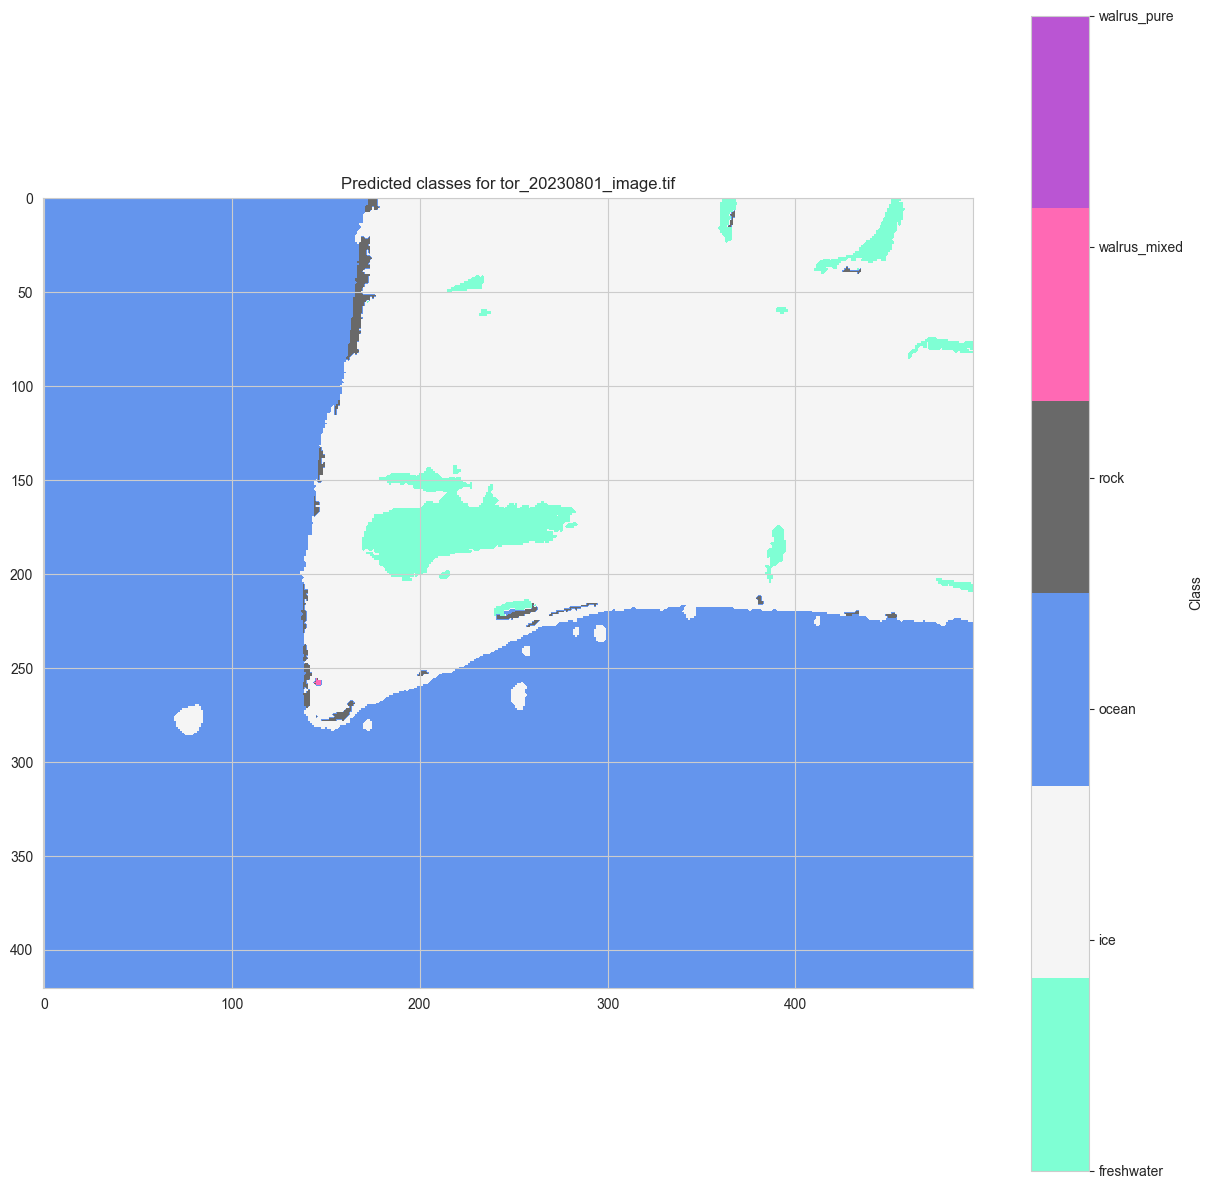


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230824_image.tif
Image shape: (8, 310, 441)
Image reshaped for prediction: (136710, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         660   578     465    360     187  164       124   53
1         645   575     479    377     177  154       109   23
2         632   577     476    372     173  149       110   22
3         653   557     467    356     164  141       120   20
4         657   535     481    350     159  154       131   29
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         660   578     465    360     187  164       124   53   
1         645   575     479    377     177  154       109   23   
2         632   577     476    372     173  149       110   22   
3         653   557     467    356     164  141       120   20   
4         657   535     481    350     159  154       

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4 5]
Unique labels in processed image: [0 1 2 3 4 5]
Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


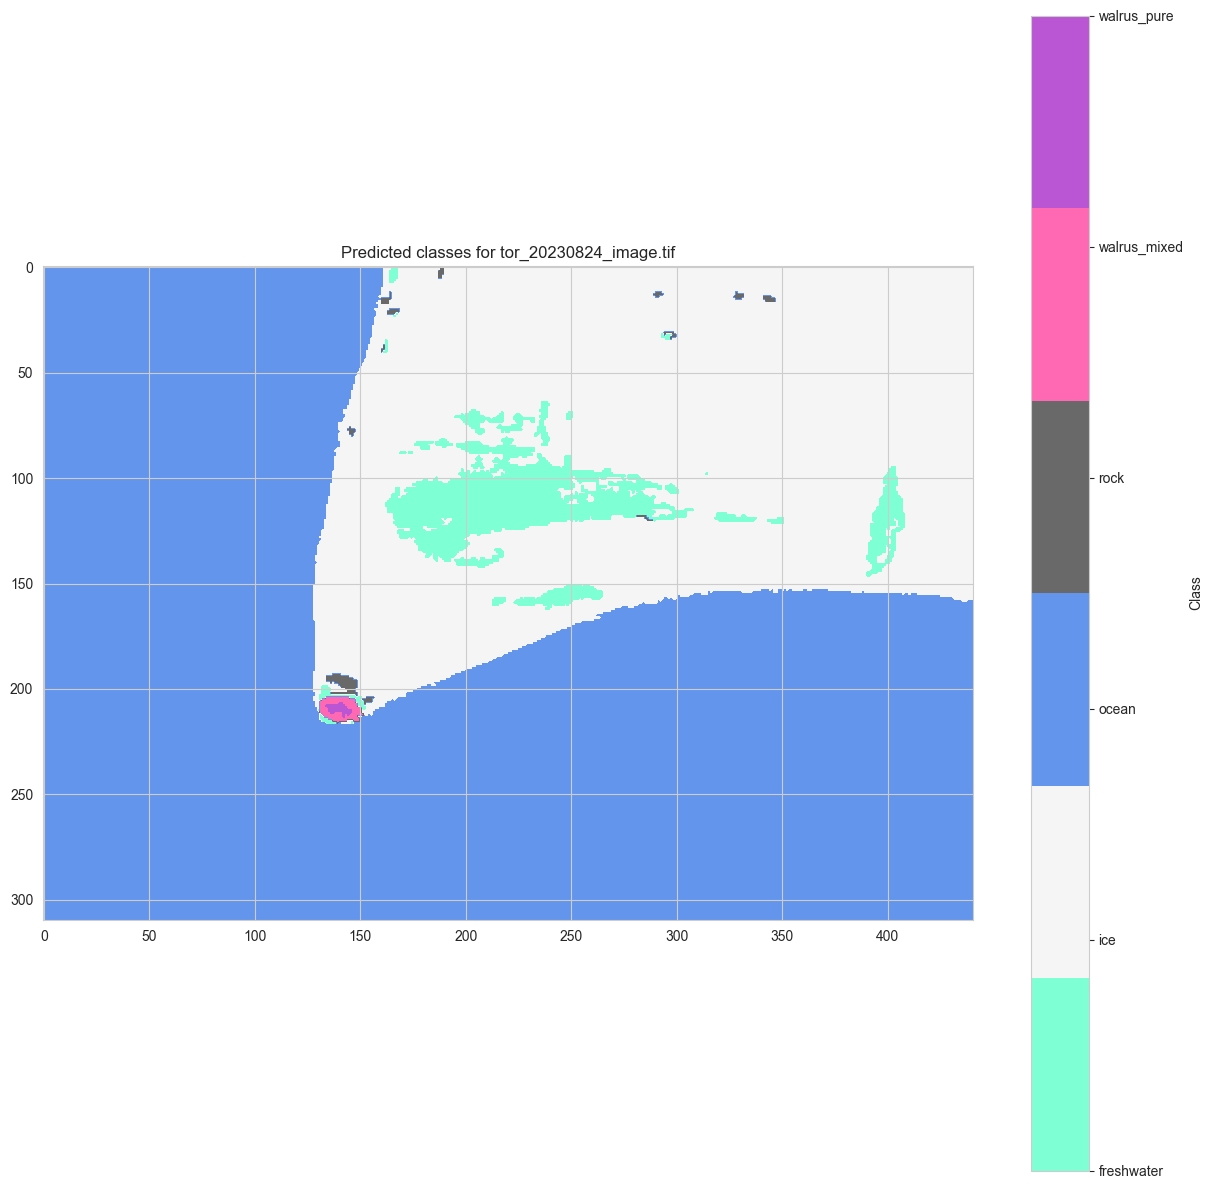


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230901_image.tif
Image shape: (8, 420, 493)
Image reshaped for prediction: (207060, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         780   581     523    403     356  181       200  135
1         771   589     540    397     330  189       252  146
2         760   589     539    385     325  170       238  162
3         777   595     536    387     349  170       216  183
4         792   595     537    404     382  179       187  180
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         780   581     523    403     356  181       200  135   
1         771   589     540    397     330  189       252  146   
2         760   589     539    385     325  170       238  162   
3         777   595     536    387     349  170       216  183   
4         792   595     537    404     382  179       

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3]
Unique labels in processed image: [0 1 2 3]
Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


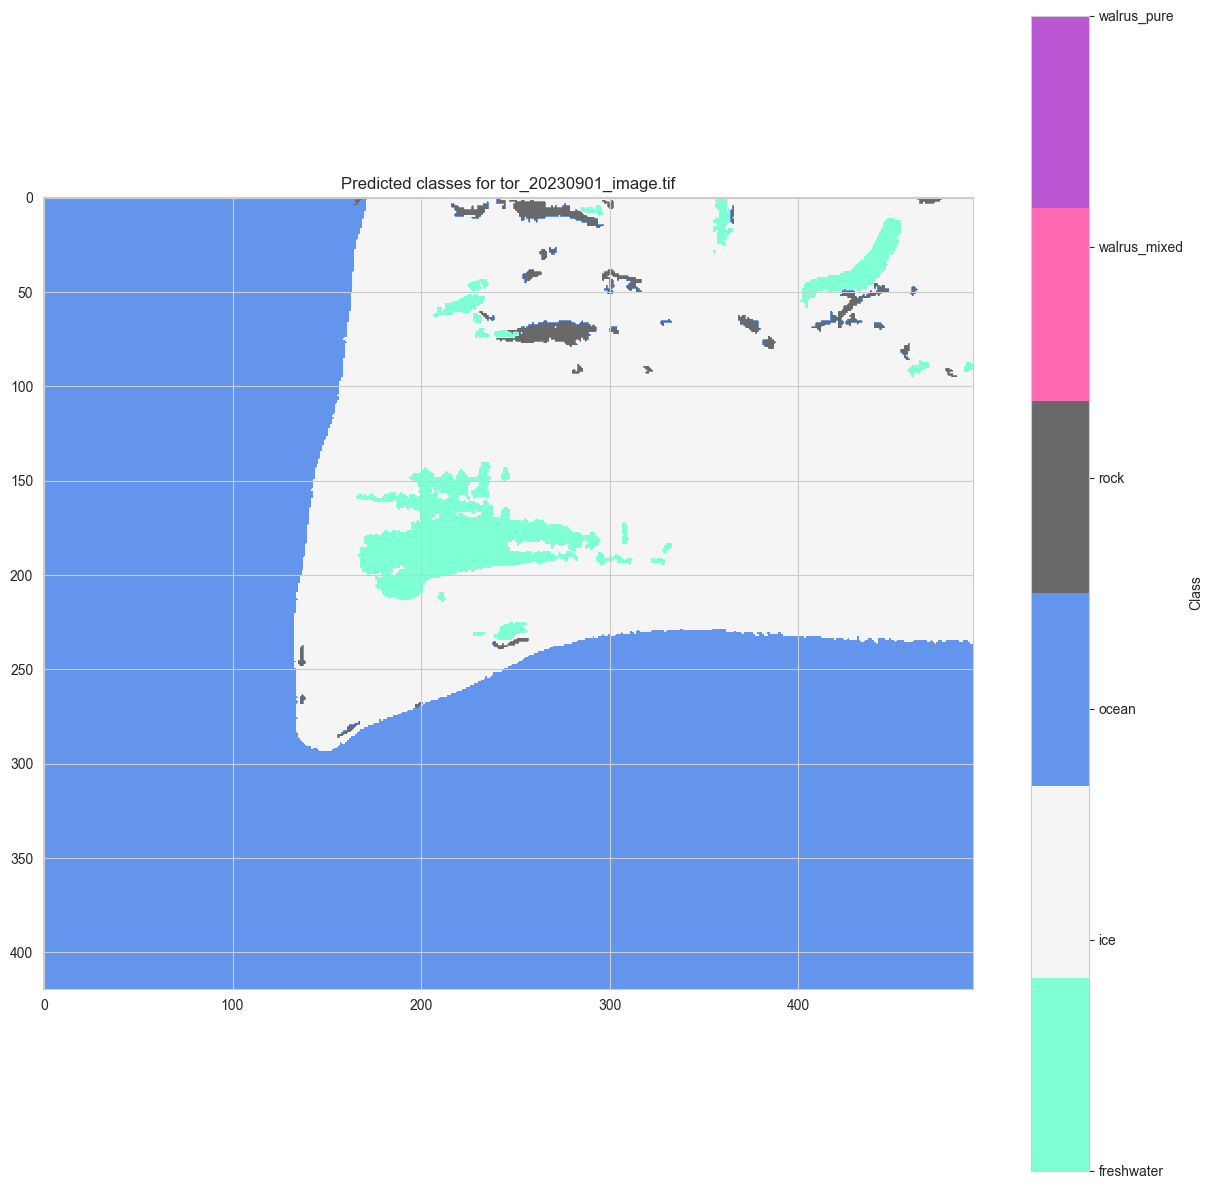


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230902_image.tif
Image shape: (8, 420, 493)
Image reshaped for prediction: (207060, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         754   851     671    477     479  359       297  261
1         785   865     679    480     500  361       284  213
2         786   870     657    464     487  335       239  190
3         768   860     648    452     475  343       227  190
4         764   851     636    483     456  355       277  203
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         754   851     671    477     479  359       297  261   
1         785   865     679    480     500  361       284  213   
2         786   870     657    464     487  335       239  190   
3         768   860     648    452     475  343       227  190   
4         764   851     636    483     456  355       

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4 5]
Unique labels in processed image: [0 1 2 3 4 5]
Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


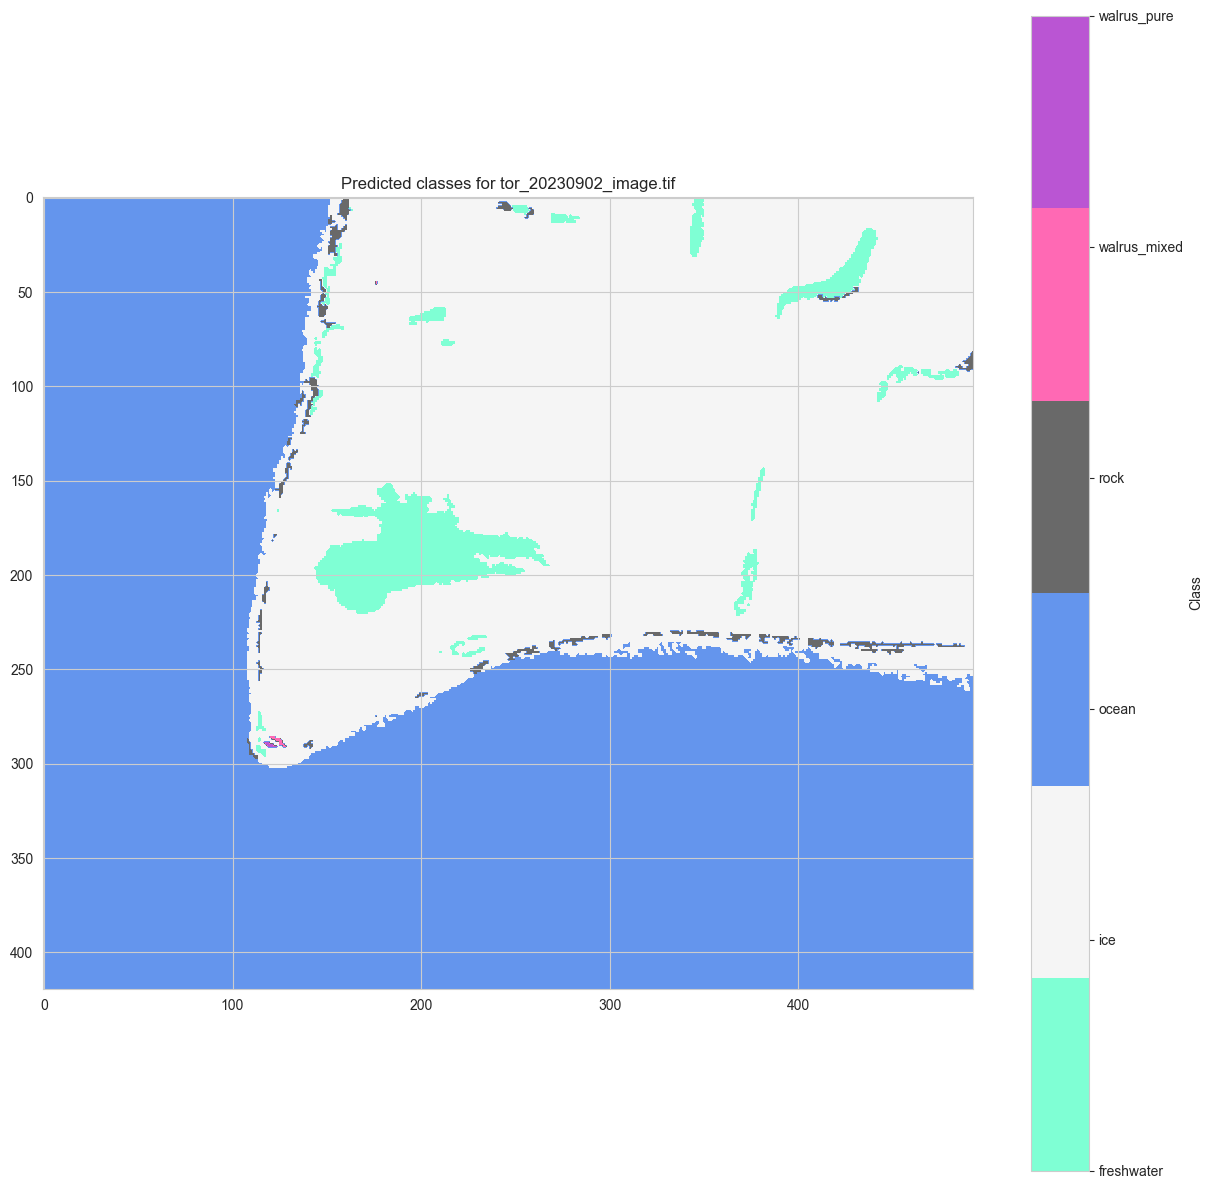


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\tor_20230717_image.tif
Image shape: (8, 144, 230)
Image reshaped for prediction: (33120, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         600   523     554    317     356  180       141  167
1         618   519     563    313     348  174       147  189
2         562   508     539    314     334  175       124  106
3         560   508     538    321     330  175        96   73
4         615   527     554    341     359  183        79   54
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         600   523     554    317     356  180       141  167   
1         618   519     563    313     348  174       147  189   
2         562   508     539    314     334  175       124  106   
3         560   508     538    321     330  175        96   73   
4         615   527     554    341     359  183     

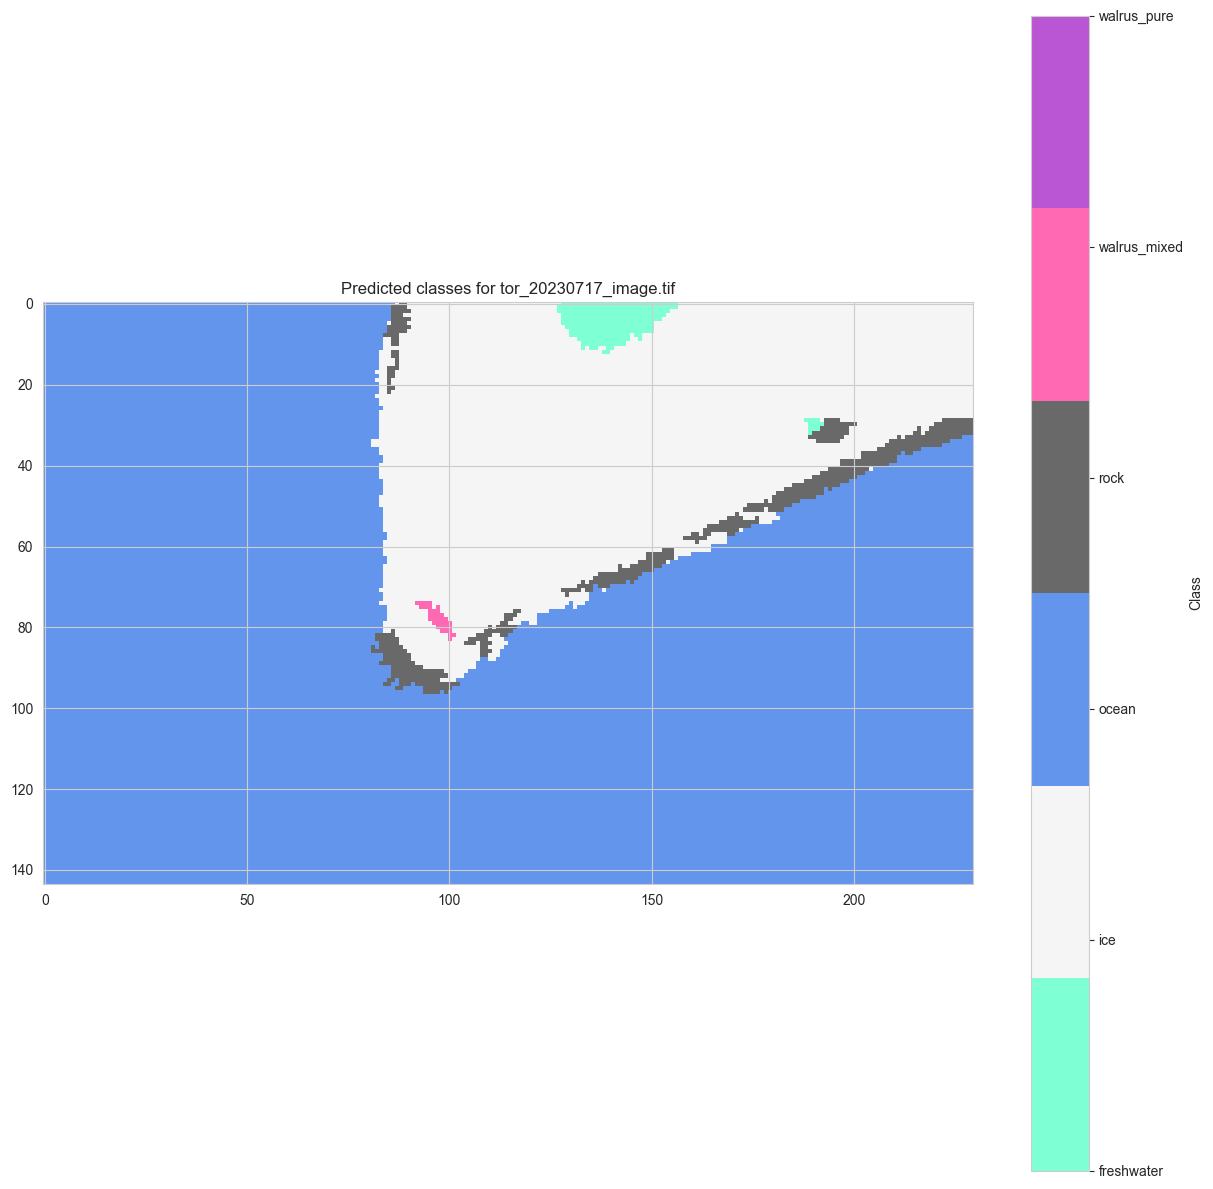

In [36]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import ndimage
import os
import traceback

# Assuming these functions and variables are defined earlier in your script:
# add_advanced_features_optimized, best_rf_model, le, file_pairs, unlabeled_image_paths

def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        print(f"Image reshaped for prediction: {image_reshaped.shape}")
        
        df = pd.DataFrame(image_reshaped, columns=['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR'])
        print(f"Initial dataframe:\n{df.head()}")
        df = add_advanced_features_optimized(df)
        print(f"Dataframe with advanced features:\n{df.head()}")
        
        df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        predictions = model.predict(df)
        print(f"Unique predicted classes: {np.unique(predictions)}")
        return predictions.reshape((src.height, src.width))

def post_process(predicted_image, min_area=10):
    processed_image = np.copy(predicted_image)
    for label in np.unique(predicted_image):
        binary_image = (predicted_image == label)
        labeled_array, num_features = ndimage.label(binary_image)
        sizes = ndimage.sum(binary_image, labeled_array, range(num_features + 1))
        for i in range(1, num_features + 1):
            if sizes[i] < min_area:
                region = (labeled_array == i)
                dilated_region = ndimage.binary_dilation(region)
                neighbor_labels = predicted_image[dilated_region & ~region]
                if len(neighbor_labels) > 0:
                    most_common = np.bincount(neighbor_labels).argmax()
                    processed_image[region] = most_common
    return processed_image

def plot_prediction(image_path, processed_image, cmap, le):
    plt.figure(figsize=(15, 15))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(processed_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    plt.show()

# Define color map
label_colors = {
    'ice': 'whitesmoke', 'ocean': 'cornflowerblue', 'rock': 'dimgrey',
    'freshwater': 'aquamarine', 'walrus_pure': 'mediumorchid', 'walrus_mixed': 'hotpink'
}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Process training images
print("Processing training images:")
for image_path in file_pairs.keys():
    try:
        print(f"\nProcessing training image: {image_path}")
        predicted_image = predict_image(image_path, best_rf_model)
        processed_image = post_process(predicted_image)
        unique_labels = np.unique(processed_image)
        print(f"Unique labels in processed image: {unique_labels}")
        present_labels = [le.classes_[i] for i in unique_labels if i != -1]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plot_prediction(image_path, processed_image, cmap, le)
    except Exception as e:
        print(f"Error processing training image {image_path}: {str(e)}")
        traceback.print_exc()


Processing unlabeled images:

Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230825_image.tif
Image shape: (8, 180, 293)
Image reshaped for prediction: (52740, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0         965   789     985    901    1217   950      1187  1257
1         934   777     981    906    1232   985      1105  1196
2         951   786     981    919    1181  1011      1087  1191
3         961   777     995    915    1165  1002      1086  1216
4         990   784     994    901    1171   972      1097  1200
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0         965   789     985    901    1217   950      1187  1257   
1         934   777     981    906    1232   985      1105  1196   
2         951   786     981    919    1181  1011      1087  1191   
3         961   777     995    915    1165  1002      1086  1216  

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3]
Unique labels in processed image: [0 1 2 3]
Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


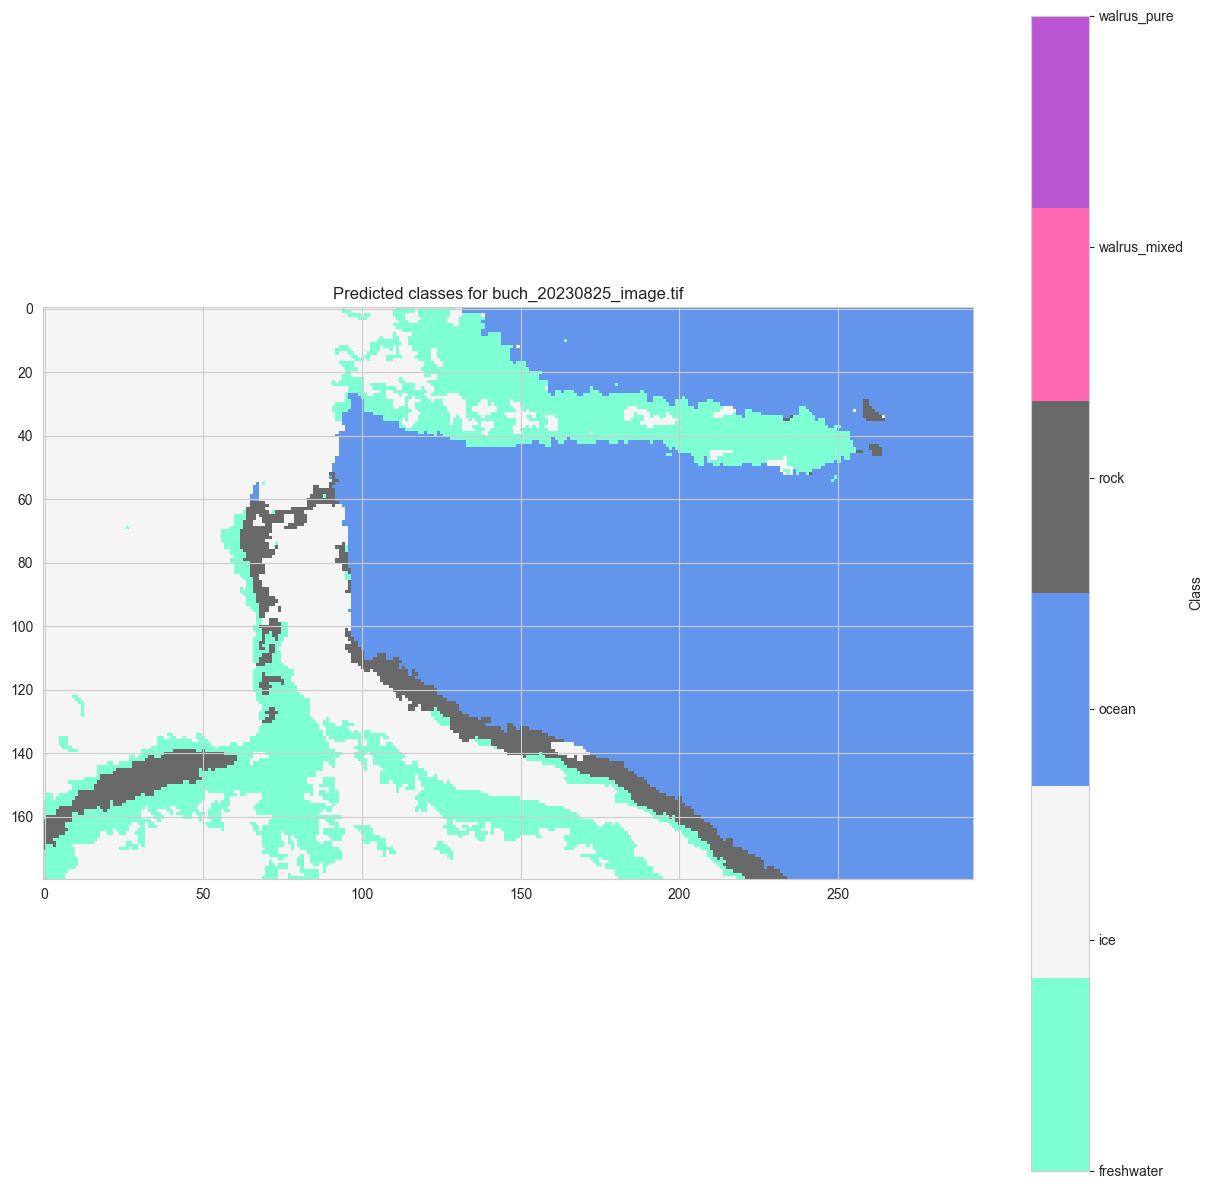


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230901_image.tif
Image shape: (8, 180, 285)
Image reshaped for prediction: (51300, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge   NIR
0        1002   732     892    812    1146  923      1084  1157
1         945   711     906    805    1133  927      1111  1161
2         893   690     945    835    1118  921      1074  1166
3         893   711     980    869    1150  923      1026  1150
4         936   750    1003    885    1201  949      1049  1150
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge   NIR  \
0        1002   732     892    812    1146  923      1084  1157   
1         945   711     906    805    1133  927      1111  1161   
2         893   690     945    835    1118  921      1074  1166   
3         893   711     980    869    1150  923      1026  1150   
4         936   750    1003    885    1

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3]
Unique labels in processed image: [0 1 2 3]
Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


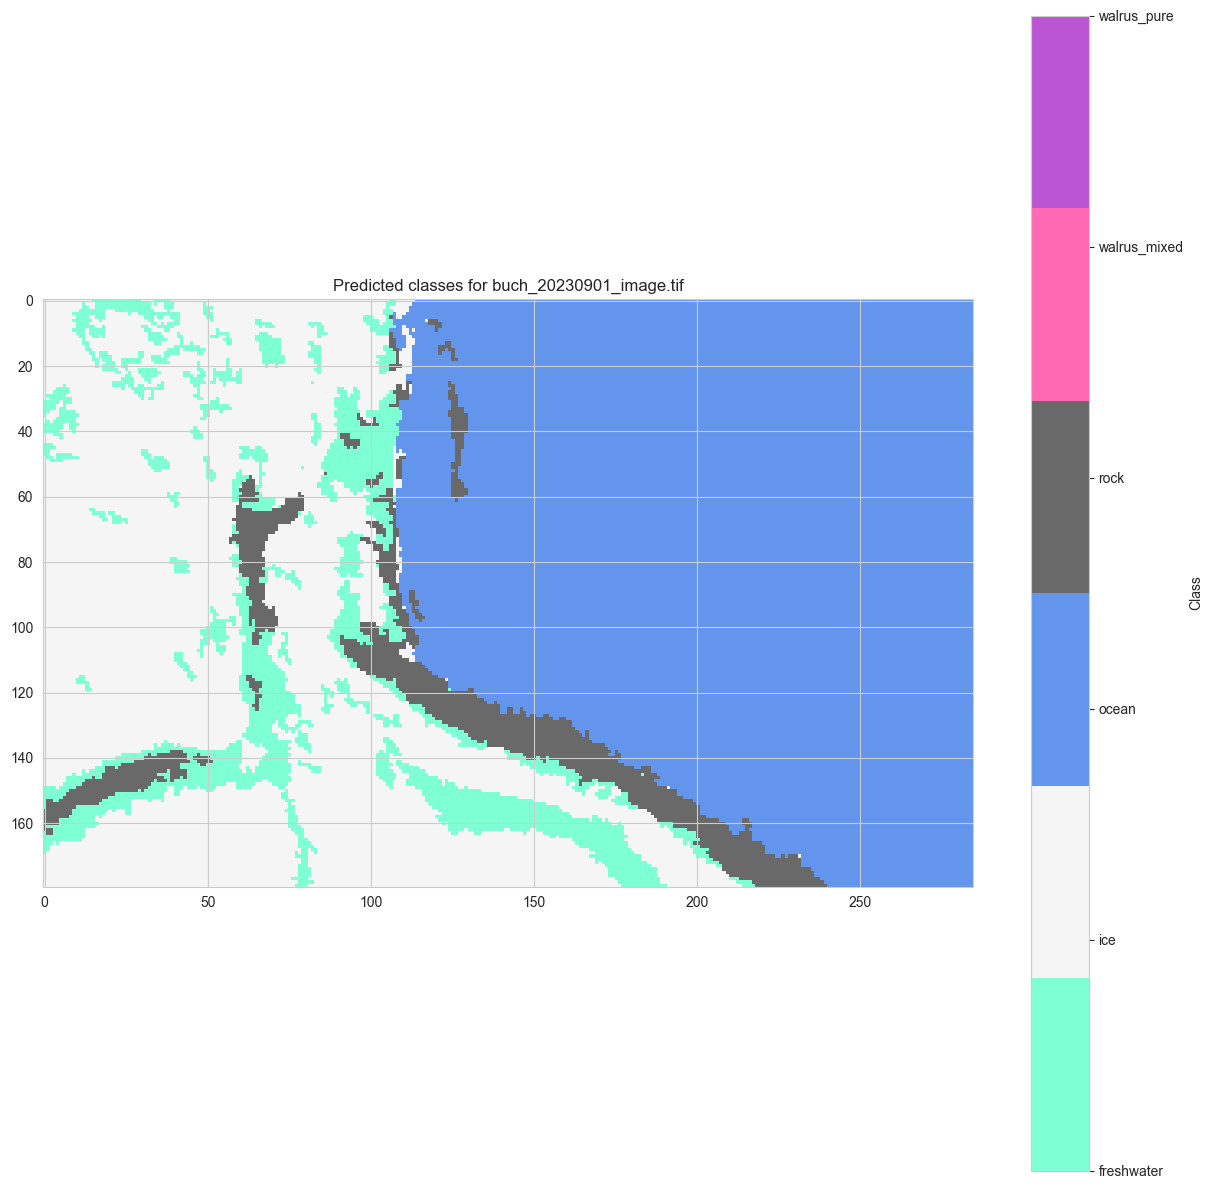


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230817_image.tif
Image shape: (8, 298, 475)
Image reshaped for prediction: (141550, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         847   946     939    823     723  392       393  233
1         865   891     936    806     677  369       394  242
2         862   868     964    803     681  349       393  219
3         862   916     970    821     683  370       383  170
4         862   930     961    841     667  393       392  145
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         847   946     939    823     723  392       393  233   
1         865   891     936    806     677  369       394  242   
2         862   868     964    803     681  349       393  219   
3         862   916     970    821     683  370       383  170   
4         862   930     961    841     667  393   

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [0 1 2 3]
Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


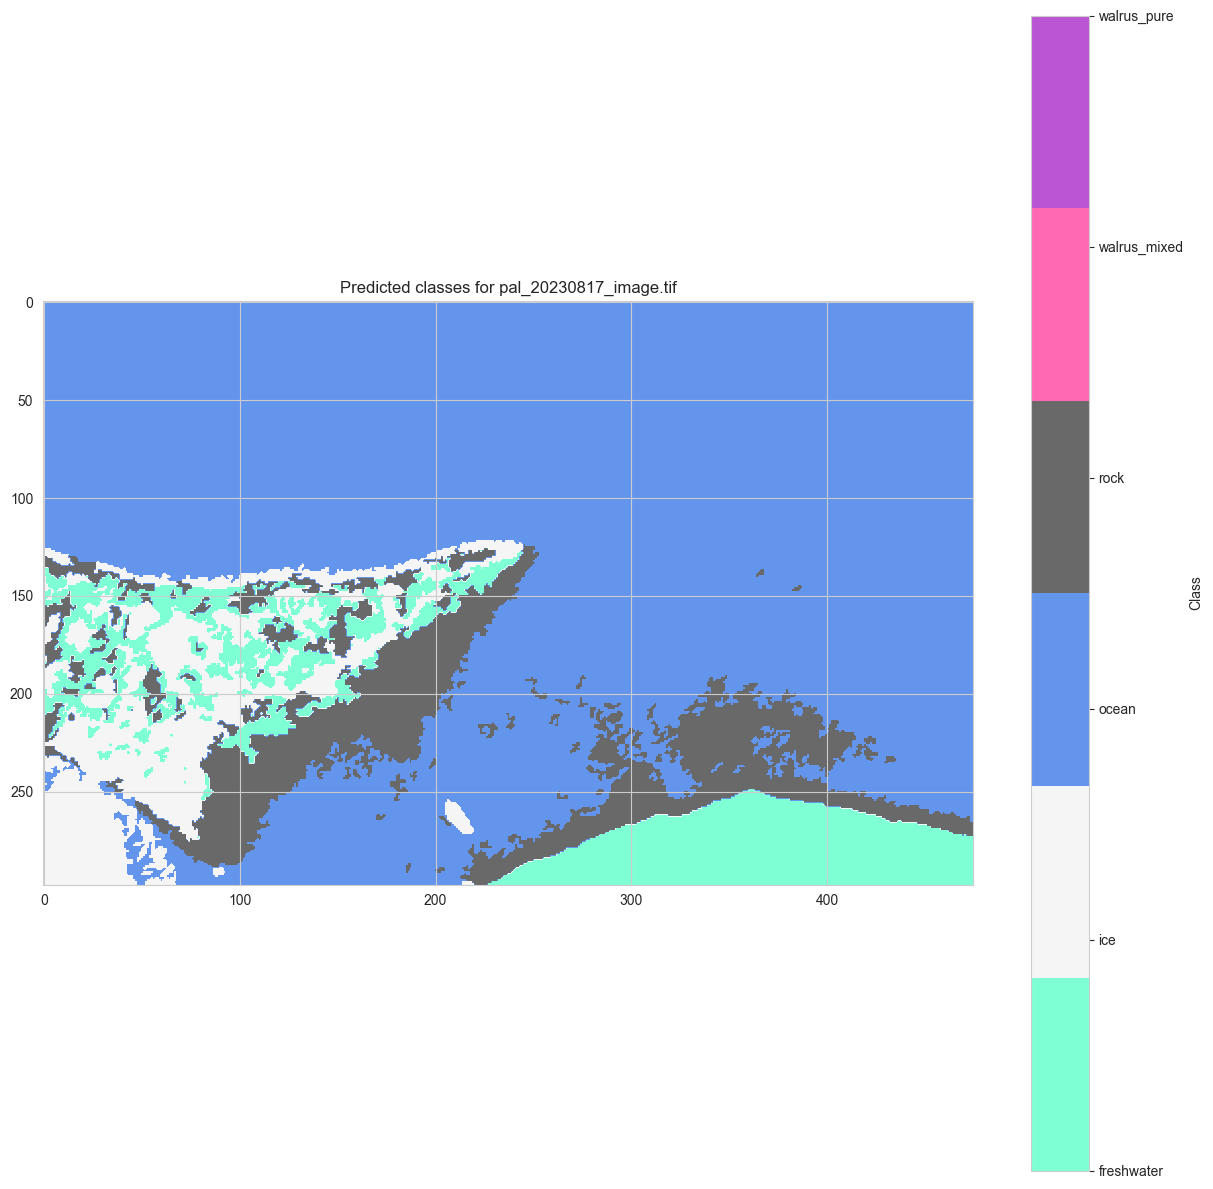


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230902_image.tif
Image shape: (8, 299, 475)
Image reshaped for prediction: (142025, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1025   778     911    613     348  249       218  140
1        1159   776     845    616     361  266       240  193
2        1203   754     857    601     367  266       261  242
3        1103   783     872    592     367  262       243  226
4        1103   818     880    593     381  269       223  182
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1025   778     911    613     348  249       218  140   
1        1159   776     845    616     361  266       240  193   
2        1203   754     857    601     367  266       261  242   
3        1103   783     872    592     367  262       243  226   
4        1103   818     880    593     381  269   

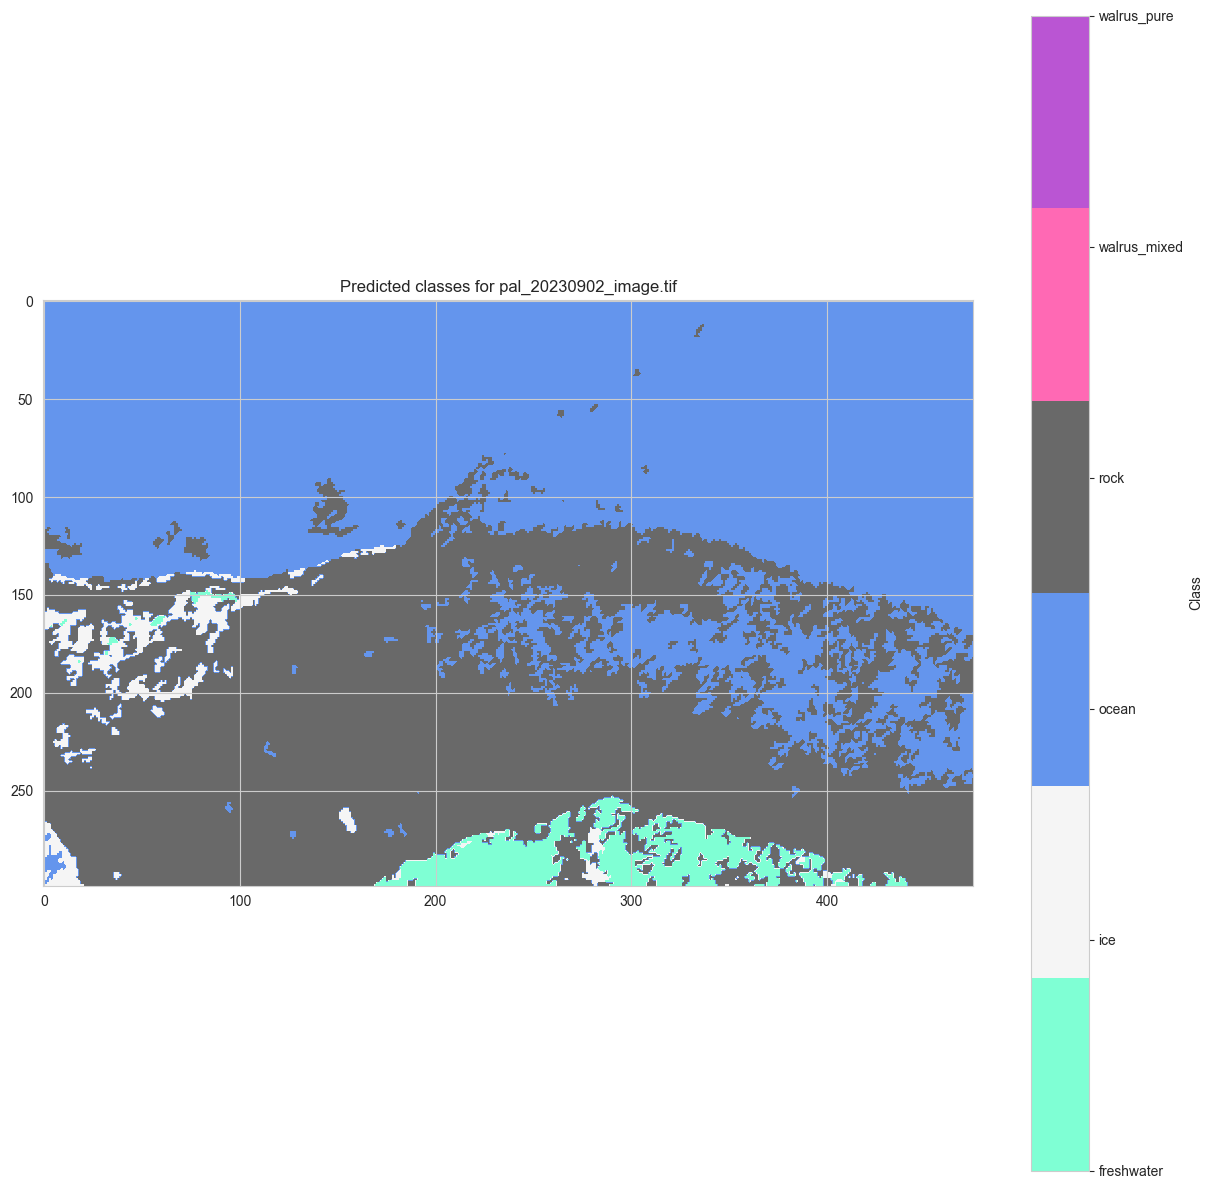


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\sars_20230719_image.tif
Image shape: (8, 436, 638)
Image reshaped for prediction: (278168, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         756   466     685    367     452  118        77   22
1         756   480     685    364     452  113        59    1
2         745   444     683    367     426  128        43   25
3         762   403     690    374     396  137        51   37
4         759   428     705    394     405  117        66    1
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         756   466     685    367     452  118        77   22   
1         756   480     685    364     452  113        59    1   
2         745   444     683    367     426  128        43   25   
3         762   403     690    374     396  137        51   37   
4         759   428     705    394     405  117  

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [1 2 3]
Unique labels in processed image: [1 2 3]
Labels present in sars_20230719_image.tif: ['ice', 'ocean', 'rock']


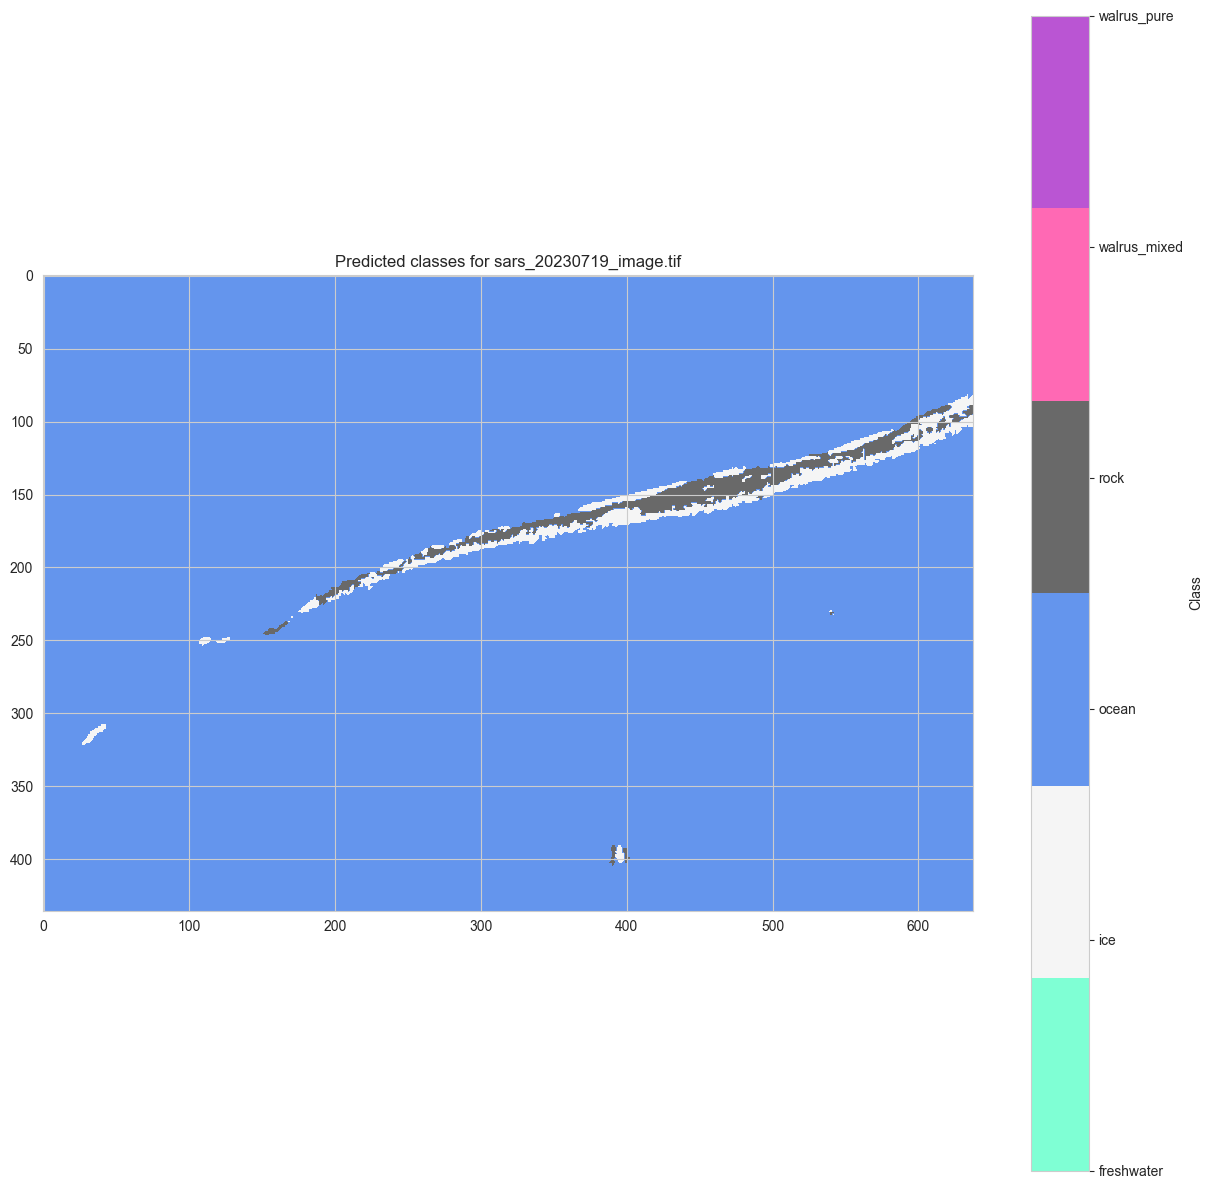


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\sars_20230726_image.tif
Image shape: (8, 279, 428)
Image reshaped for prediction: (119412, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0           0     0       0      0       0    0         0    0
1           0     0       0      0       0    0         0    0
2           0     0       0      0       0    0         0    0
3           0     0       0      0       0    0         0    0
4           0     0       0      0       0    0         0    0
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0           0     0       0      0       0    0         0    0   
1           0     0       0      0       0    0         0    0   
2           0     0       0      0       0    0         0    0   
3           0     0       0      0       0    0         0    0   
4           0     0       0      0       0    0  

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: Runt

Unique predicted classes: [0 1 2 3 4]
Unique labels in processed image: [0 1 2 3]
Labels present in sars_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


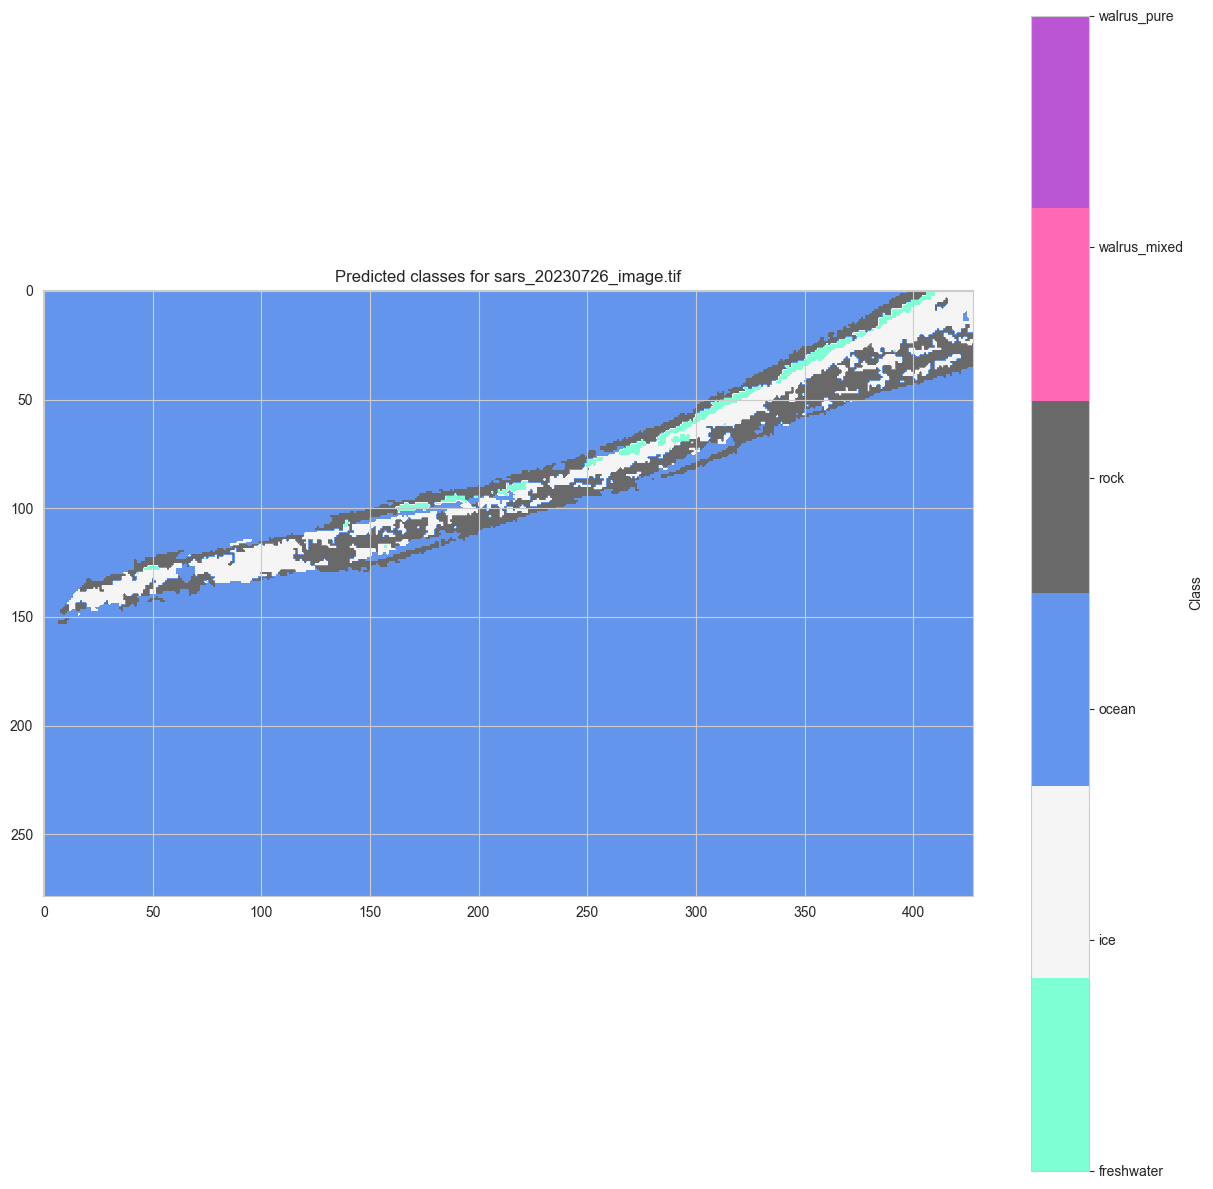


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\sars_20230808_image.tif
Image shape: (8, 319, 510)
Image reshaped for prediction: (162690, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         625   356     538    307     243  125        32    9
1         568   373     533    295     277  122        51   24
2         594   359     518    315     277  125        88   28
3         595   364     511    319     271  141       118   38
4         638   371     526    300     271  129       115   45
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         625   356     538    307     243  125        32    9   
1         568   373     533    295     277  122        51   24   
2         594   359     518    315     277  125        88   28   
3         595   364     511    319     271  141       118   38   
4         638   371     526    300     271  129  

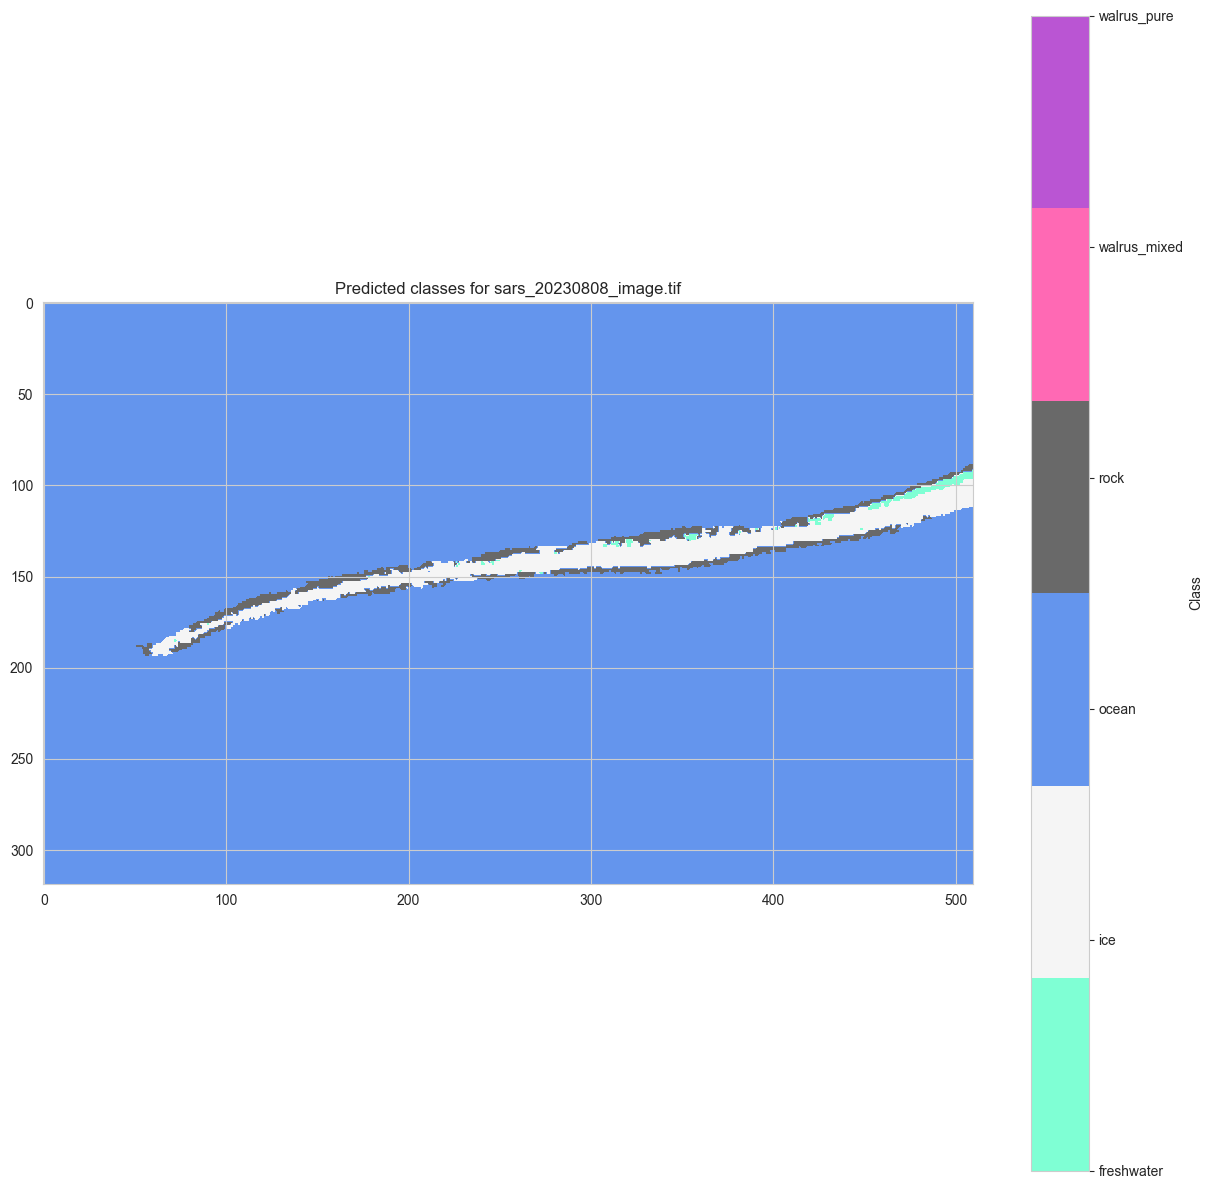


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\tor_20230714_image.tif
Image shape: (8, 144, 224)
Image reshaped for prediction: (32256, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         893   552     596    338     456  200       166  103
1         874   546     595    342     451  206       149   79
2         873   538     595    343     455  215       140   83
3         857   574     602    340     453  222       148  122
4         867   592     611    332     446  207       155  103
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         893   552     596    338     456  200       166  103   
1         874   546     595    342     451  206       149   79   
2         873   538     595    343     455  215       140   83   
3         857   574     602    340     453  222       148  122   
4         867   592     611    332     446  207    

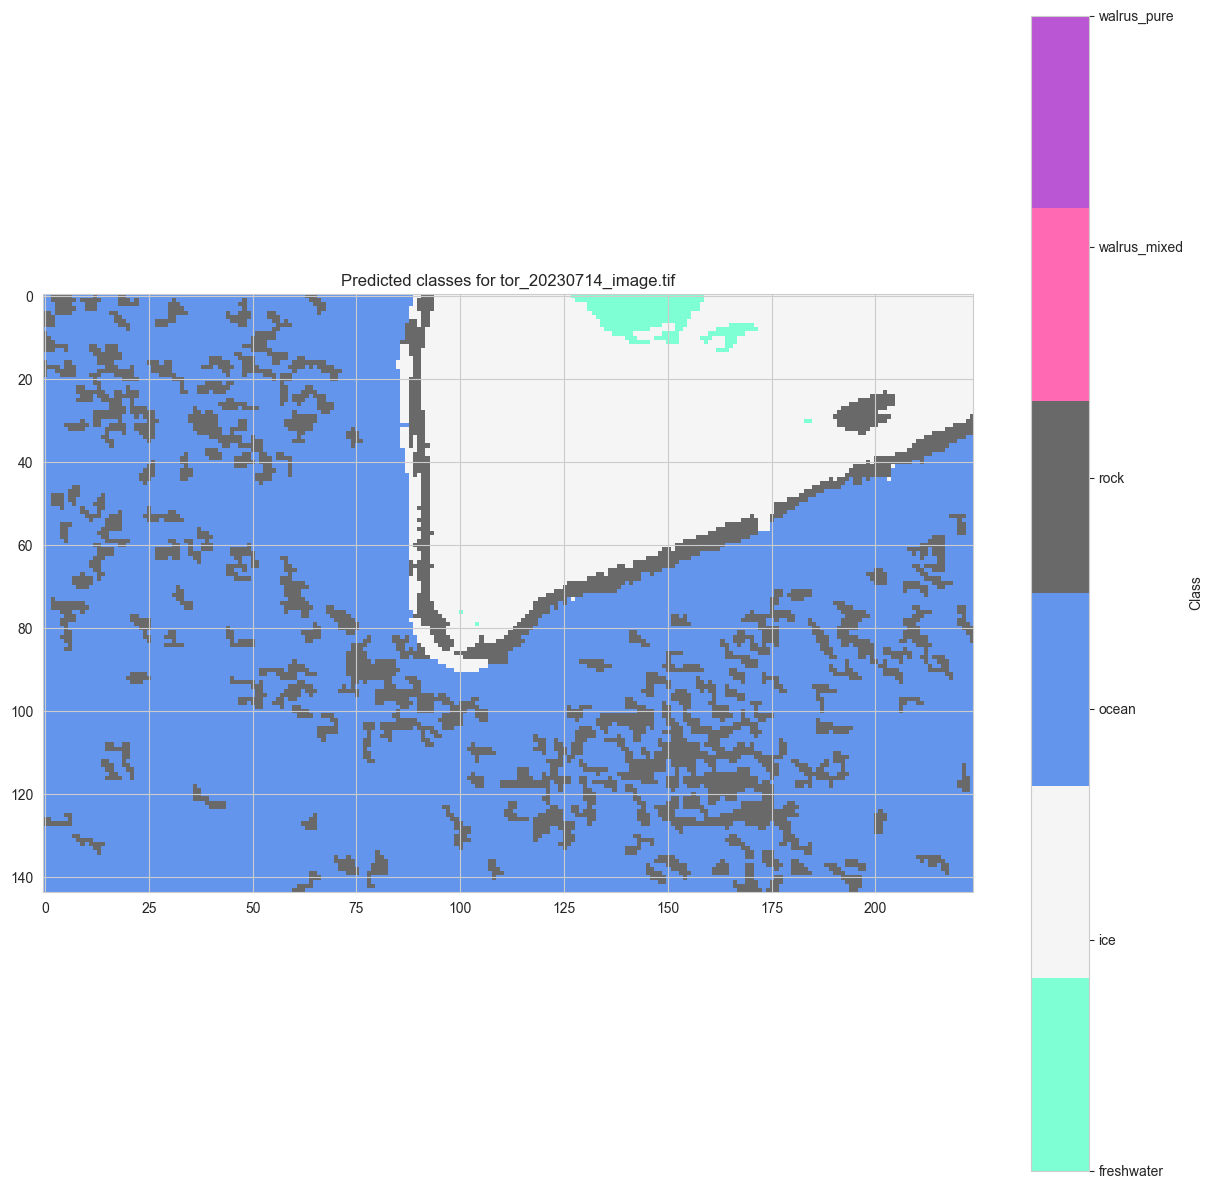


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\tor_20230717_image.tif
Image shape: (8, 144, 230)
Image reshaped for prediction: (33120, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         600   523     554    317     356  180       141  167
1         618   519     563    313     348  174       147  189
2         562   508     539    314     334  175       124  106
3         560   508     538    321     330  175        96   73
4         615   527     554    341     359  183        79   54
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         600   523     554    317     356  180       141  167   
1         618   519     563    313     348  174       147  189   
2         562   508     539    314     334  175       124  106   
3         560   508     538    321     330  175        96   73   
4         615   527     554    341     359  183    

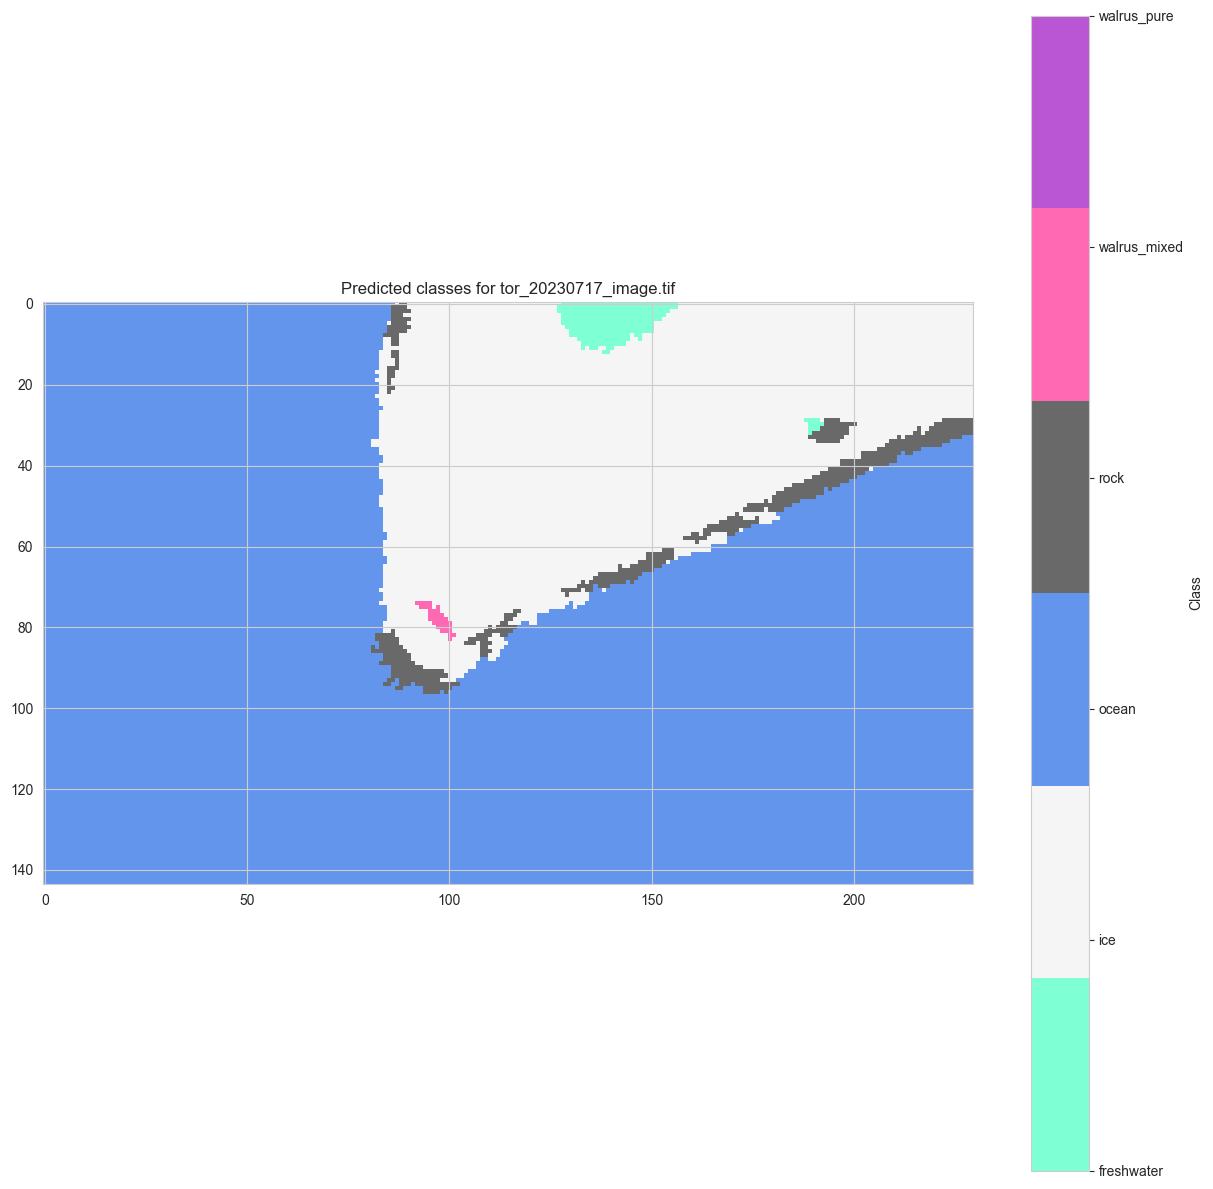


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\tor_20230803_image.tif
Image shape: (8, 116, 189)
Image reshaped for prediction: (21924, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         662   461     540    369     351  145       157   21
1         660   466     546    371     345  130        88   19
2         610   453     531    387     318  130        48   27
3         612   444     520    385     335  155        57   27
4         611   455     526    383     339  165        82   23
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         662   461     540    369     351  145       157   21   
1         660   466     546    371     345  130        88   19   
2         610   453     531    387     318  130        48   27   
3         612   444     520    385     335  155        57   27   
4         611   455     526    383     339  165    

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Unique predicted classes: [0 1 2 3]
Unique labels in processed image: [0 1 2 3]
Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


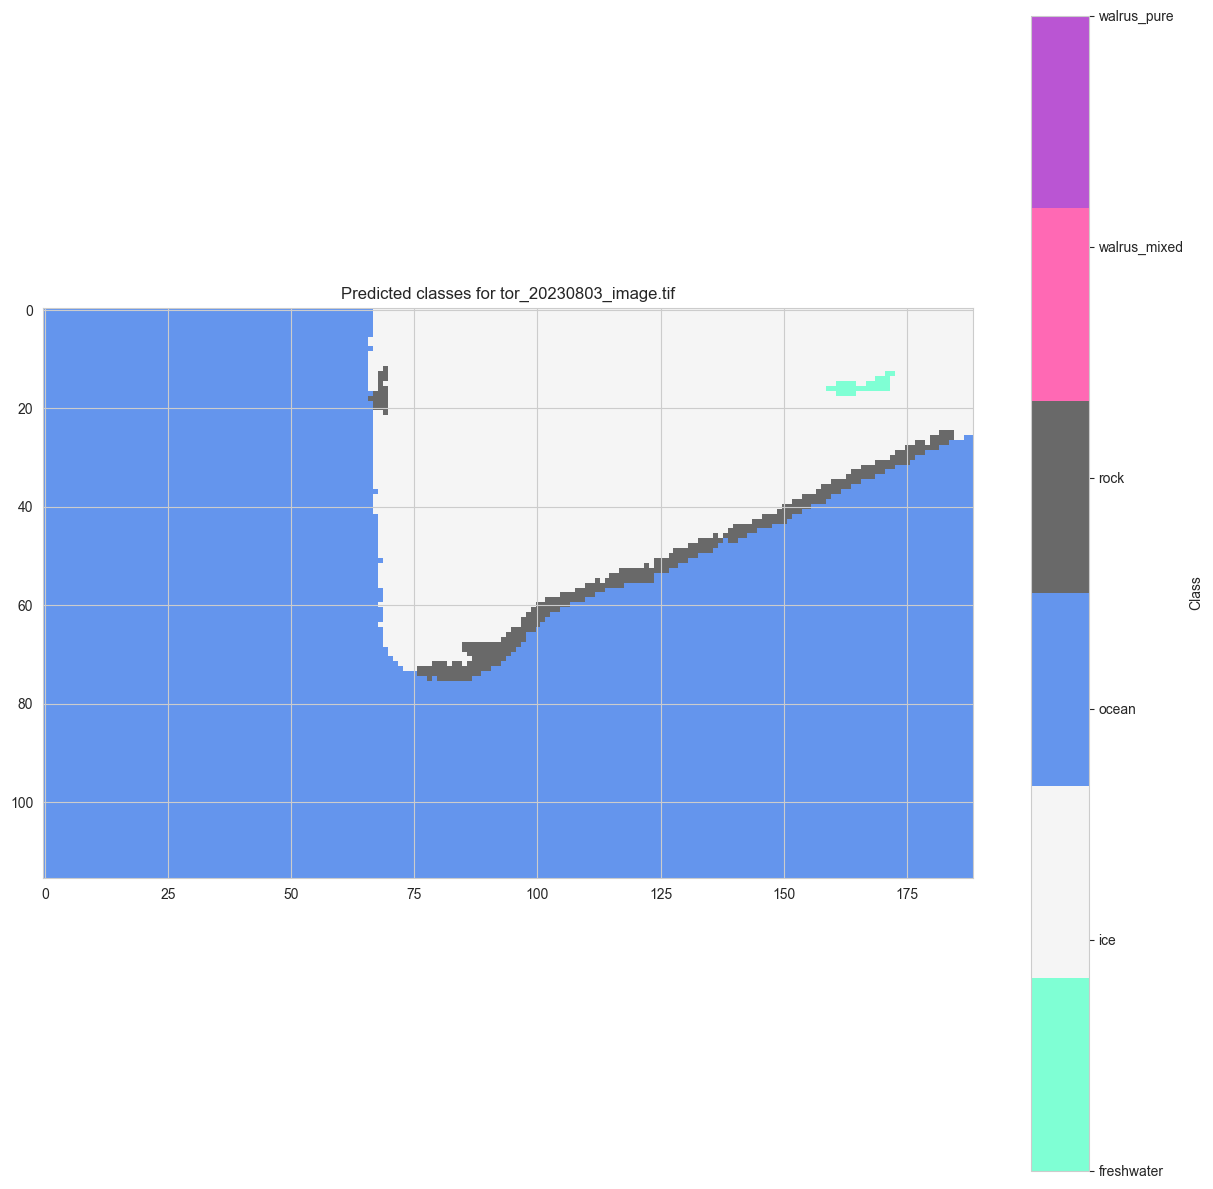


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\tor_20230825_image.tif
Image shape: (8, 180, 293)
Image reshaped for prediction: (52740, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         667   530     625    348     376  149        52   67
1         711   555     602    366     376  141        67   49
2         737   544     588    416     399  125        62   40
3         777   543     587    420     392  133        76   42
4         749   552     599    390     376  162        74   43
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         667   530     625    348     376  149        52   67   
1         711   555     602    366     376  141        67   49   
2         737   544     588    416     399  125        62   40   
3         777   543     587    420     392  133        76   42   
4         749   552     599    390     376  162    

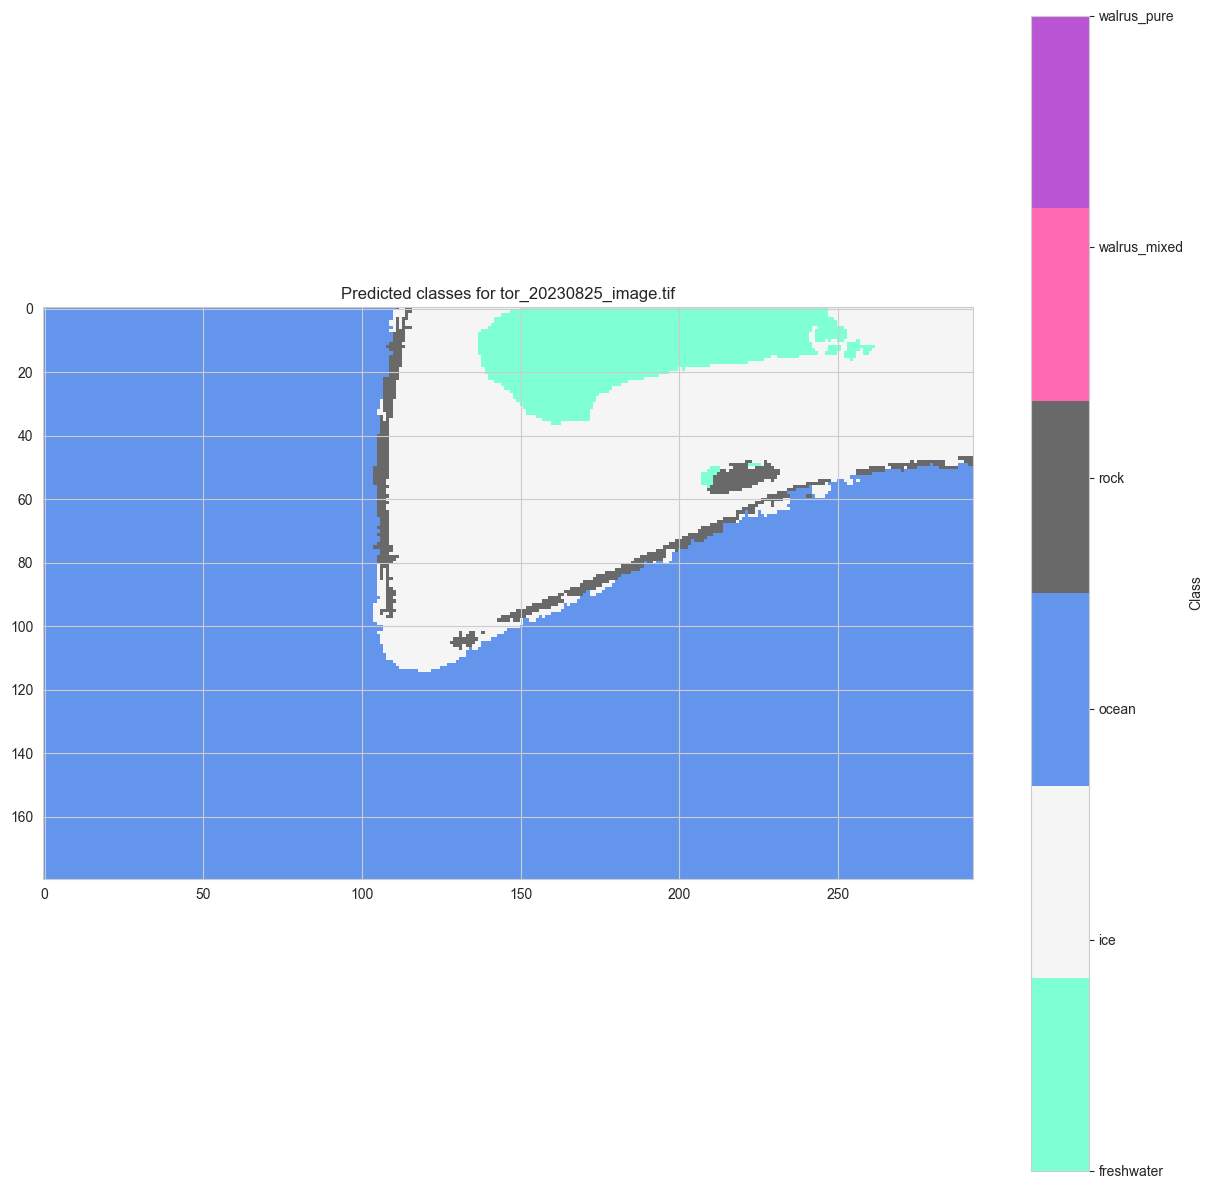


Processing unlabeled image: C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\tor_20230910_image.tif
Image shape: (8, 180, 286)
Image reshaped for prediction: (51480, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         837   637     668    371     696  152       154   93
1         778   583     689    363     689  162       176  116
2         798   562     711    356     658  150       208  152
3         789   575     695    353     647  128       173  152
4         785   565     679    353     651  149       120  155
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         837   637     668    371     696  152       154   93   
1         778   583     689    363     689  162       176  116   
2         798   562     711    356     658  150       208  152   
3         789   575     695    353     647  128       173  152   
4         785   565     679    353     651  149    

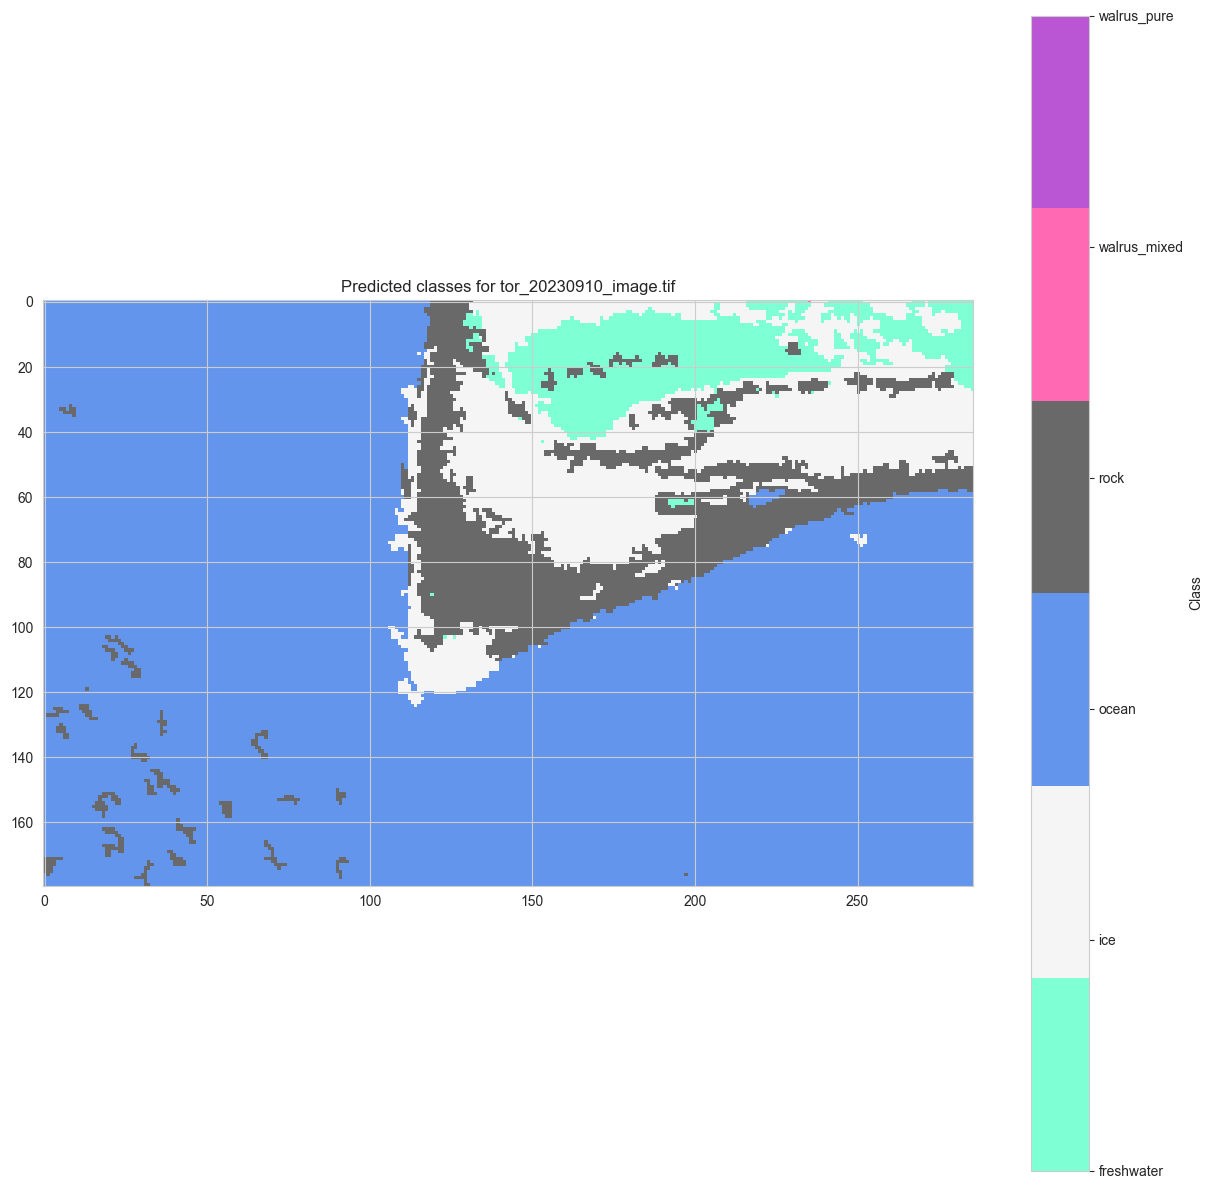

In [37]:
# Process unlabeled images
print("\nProcessing unlabeled images:")
for image_path in unlabeled_image_paths:
    try:
        print(f"\nProcessing unlabeled image: {image_path}")
        predicted_image = predict_image(image_path, best_rf_model)
        processed_image = post_process(predicted_image)
        unique_labels = np.unique(processed_image)
        print(f"Unique labels in processed image: {unique_labels}")
        present_labels = [le.classes_[i] for i in unique_labels if i != -1]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plot_prediction(image_path, processed_image, cmap, le)
    except Exception as e:
        print(f"Error processing unlabeled image {image_path}: {str(e)}")
        traceback.print_exc()

~

In [39]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.geometry import shape
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib
import multiprocessing
from joblib import Parallel, delayed
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import ndimage
import os
import traceback
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from scipy.stats import randint
import joblib

In [40]:
# Define directories and file paths
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# List all .tif and .shp files
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    return (match.group(1), match.group(2)) if match else (None, None)

# Pair image and shapefile paths
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island and date:
            matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
            if matching_shapefiles:
                file_pairs[image_path] = matching_shapefiles[0]
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus files
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island and date:
            matching_images = [image for image in image_paths if island in image and date in image]
            if matching_images:
                file_pairs[matching_images[0]] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features_list = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        geometry = shape(row['geometry'])
        mask = features.geometry_mask([geometry], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask.astype(bool)]
        label = row['label']

        for pixel in feature_pixels.T:
            features_list.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features_list), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs, sample_fraction=0.1):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    
    # Sample the dataset
    sample_size = int(len(labels) * sample_fraction)
    sample_indices = np.random.choice(len(labels), sample_size, replace=False)

    return features[sample_indices], labels[sample_indices], image_name[sample_indices]

# Use the reduced dataset
features, labels, image_name = get_dataset(file_pairs, sample_fraction=0.1)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [41]:
def add_advanced_features_optimized(df):
    # Only add the essential features
    numeric_df = df[['NIR', 'Green', 'Red', 'Blue']].copy()
    epsilon = 1e-10
    
    numeric_df['NIR_Green_ratio'] = np.divide(numeric_df['NIR'], numeric_df['Green'] + epsilon)
    numeric_df['NIR_Red_ratio'] = np.divide(numeric_df['NIR'], numeric_df['Red'] + epsilon)
    numeric_df['NDVI'] = np.divide((numeric_df['NIR'] - numeric_df['Red']), (numeric_df['NIR'] + numeric_df['Red'] + epsilon))
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.mean())
    
    return pd.concat([df, numeric_df[['NIR_Green_ratio', 'NIR_Red_ratio', 'NDVI']]], axis=1)


# Split dataset into chunks for parallel processing
def split_dataframe(df, chunk_size=200):
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

# Parallel processing of the advanced feature addition
def process_chunks(chunks):
    num_cores = min(multiprocessing.cpu_count(), 2)  # Use at most 2 cores
    processed_chunks = Parallel(n_jobs=num_cores)(delayed(add_advanced_features_optimized)(chunk) for chunk in chunks)
    return pd.concat(processed_chunks)


# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7]
})

# Add non-numeric columns separately
dataset['labels'] = labels
dataset['encoded_labels'] = encoded_labels
dataset['image_name'] = image_name

# Split and process in parallel
dataset_chunks = split_dataframe(dataset)
dataset_processed = process_chunks(dataset_chunks)

# Prepare features and labels for model training
X = dataset_processed.drop(columns=['labels', 'encoded_labels', 'image_name'])
y = dataset_processed['encoded_labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
y_pred = best_rf_model.predict(X_test)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

Shape of X_test: (17841, 11)
Shape of y_test: (17841,)
Shape of y_pred: (17841,)


In [43]:
# Address class imbalance with SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy='auto', random_state=42)
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Create the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(random_state=42)

# Create a pipeline with SMOTE, undersampling, and BalancedRandomForestClassifier
pipeline = Pipeline([
    ('smote', smote),
    ('undersample', undersample),
    ('classifier', brf)
])

# Define parameter space for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(5, 20),
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__max_features': ['sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Save the model
model_filename = "Balanced_RF_walrus_0507.joblib"
joblib.dump(best_rf_model, model_filename)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Student\Documents\walrus_code\.ven

['Balanced_RF_walrus_0507.joblib']

In [45]:
# Load the saved model
best_rf_model = joblib.load("Balanced_RF_walrus_0507.joblib")

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print("\n")

Best Hyperparameters:
classifier__max_depth: 19
classifier__max_features: sqrt
classifier__min_samples_leaf: 2
classifier__min_samples_split: 2
classifier__n_estimators: 99


Model Performance Metrics:
Accuracy: 0.9774115800683818
Precision: 0.9791898320184262
Recall: 0.9774115800683818
F1 Score: 0.9780546690368155
Cohen's Kappa: 0.9598069698714125

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.77      0.90      0.83       641
         ice       0.98      0.96      0.97      4671
       ocean       1.00      0.99      1.00     10713
        rock       0.96      0.96      0.96      1798
walrus_mixed       0.12      0.17      0.14        12
 walrus_pure       0.30      0.50      0.38         6

    accuracy                           0.98     17841
   macro avg       0.69      0.75      0.71     17841
weighted avg       0.98      0.98      0.98     17841


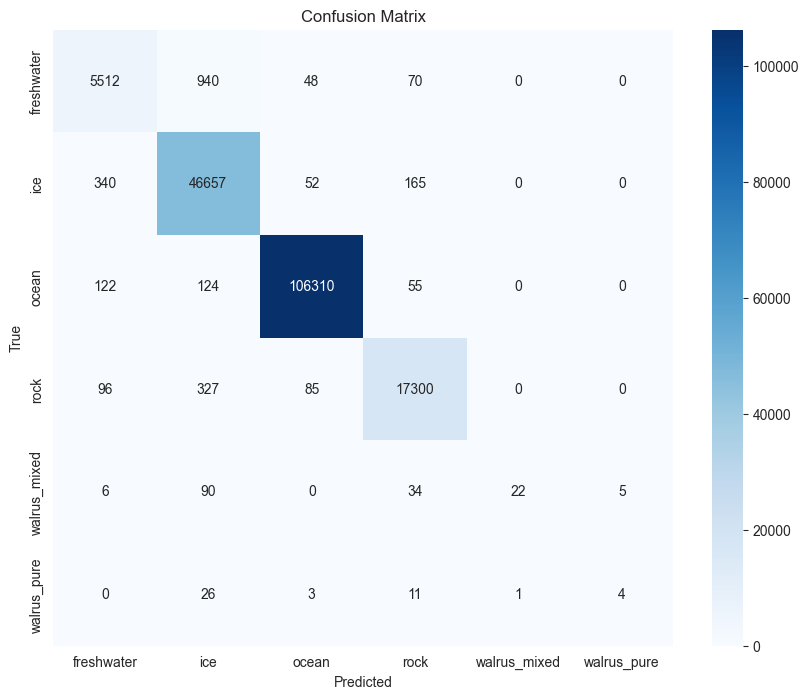

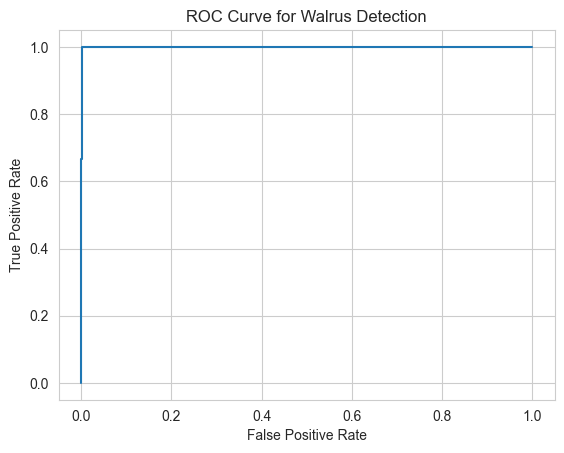

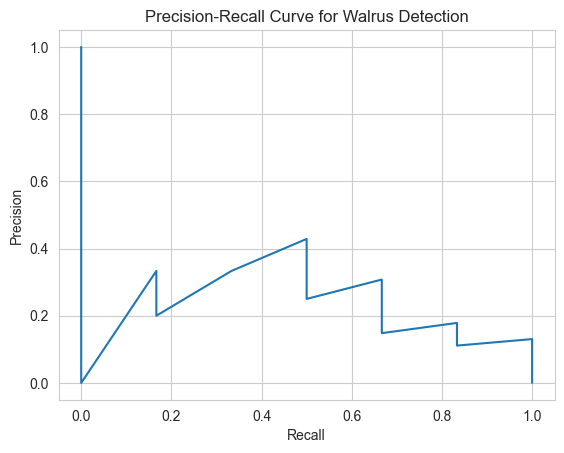

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [50]:
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve for walrus class (Assuming 'walrus_pure' is the class of interest)
walrus_index = list(le.classes_).index('walrus_pure')  # Adjust if necessary
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, walrus_index], pos_label=walrus_index)
plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC Curve for Walrus Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Precision-Recall curve for walrus class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, walrus_index], pos_label=walrus_index)
plt.figure()
plt.plot(recall, precision)
plt.title('Precision-Recall Curve for Walrus Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Feature Importance
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Walrus Detection')
plt.show()

Processing training images:

Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif
Image shape: (8, 445, 582)
Image reshaped for prediction: (258990, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        1353  1171    1385   1371    1572  1445      1471  1646
1        1367  1142    1378   1334    1555  1414      1450  1637
2        1384  1114    1360   1306    1532  1391      1431  1535
3        1343  1093    1337   1316    1513  1375      1431  1500
4        1287  1068    1340   1297    1488  1336      1435  1486
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        1353  1171    1385   1371    1572  1445      1471  1646   
1        1367  1142    1378   1334    1555  1414      1450  1637   
2        1384  1114    1360   1306    1532  1391      1431  1535   
3        1343  1093    1337   1316    1513  1375      1431  1500   
4  

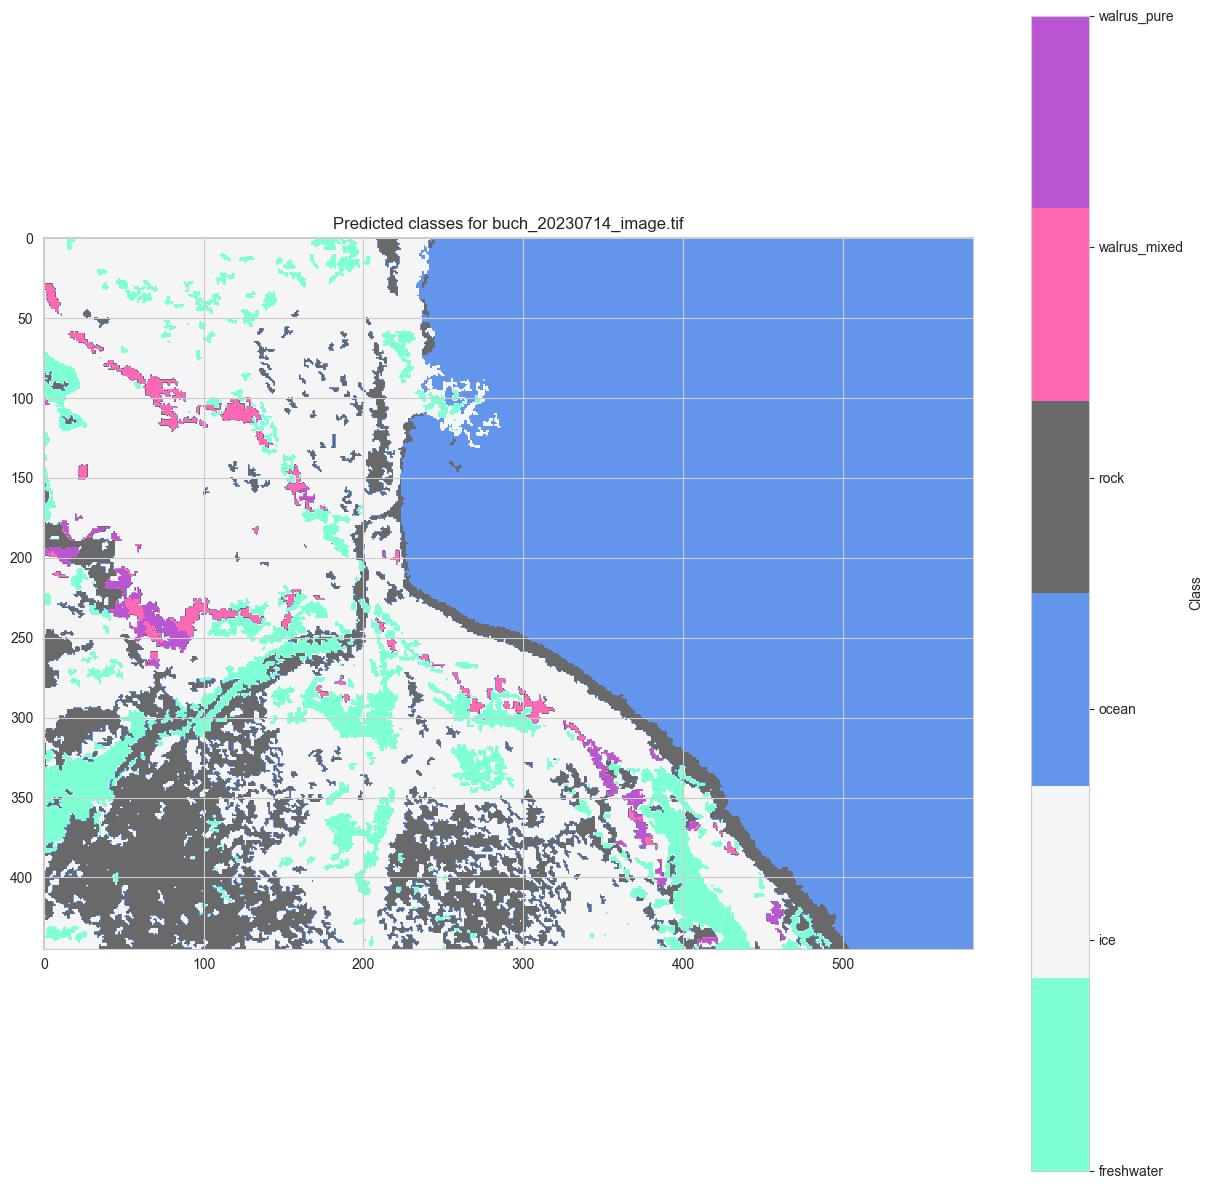


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif
Image shape: (8, 556, 728)
Image reshaped for prediction: (404768, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        1284  1189    1464   1466    1733  1572      1601  1658
1        1266  1170    1449   1475    1717  1566      1605  1680
2        1315  1144    1453   1452    1704  1567      1528  1702
3        1317  1138    1480   1444    1700  1566      1541  1694
4        1271  1156    1500   1467    1697  1550      1589  1742
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        1284  1189    1464   1466    1733  1572      1601  1658   
1        1266  1170    1449   1475    1717  1566      1605  1680   
2        1315  1144    1453   1452    1704  1567      1528  1702   
3        1317  1138    1480   1444    1700  1566      1541  1694   
4        1271  1156    1500   1

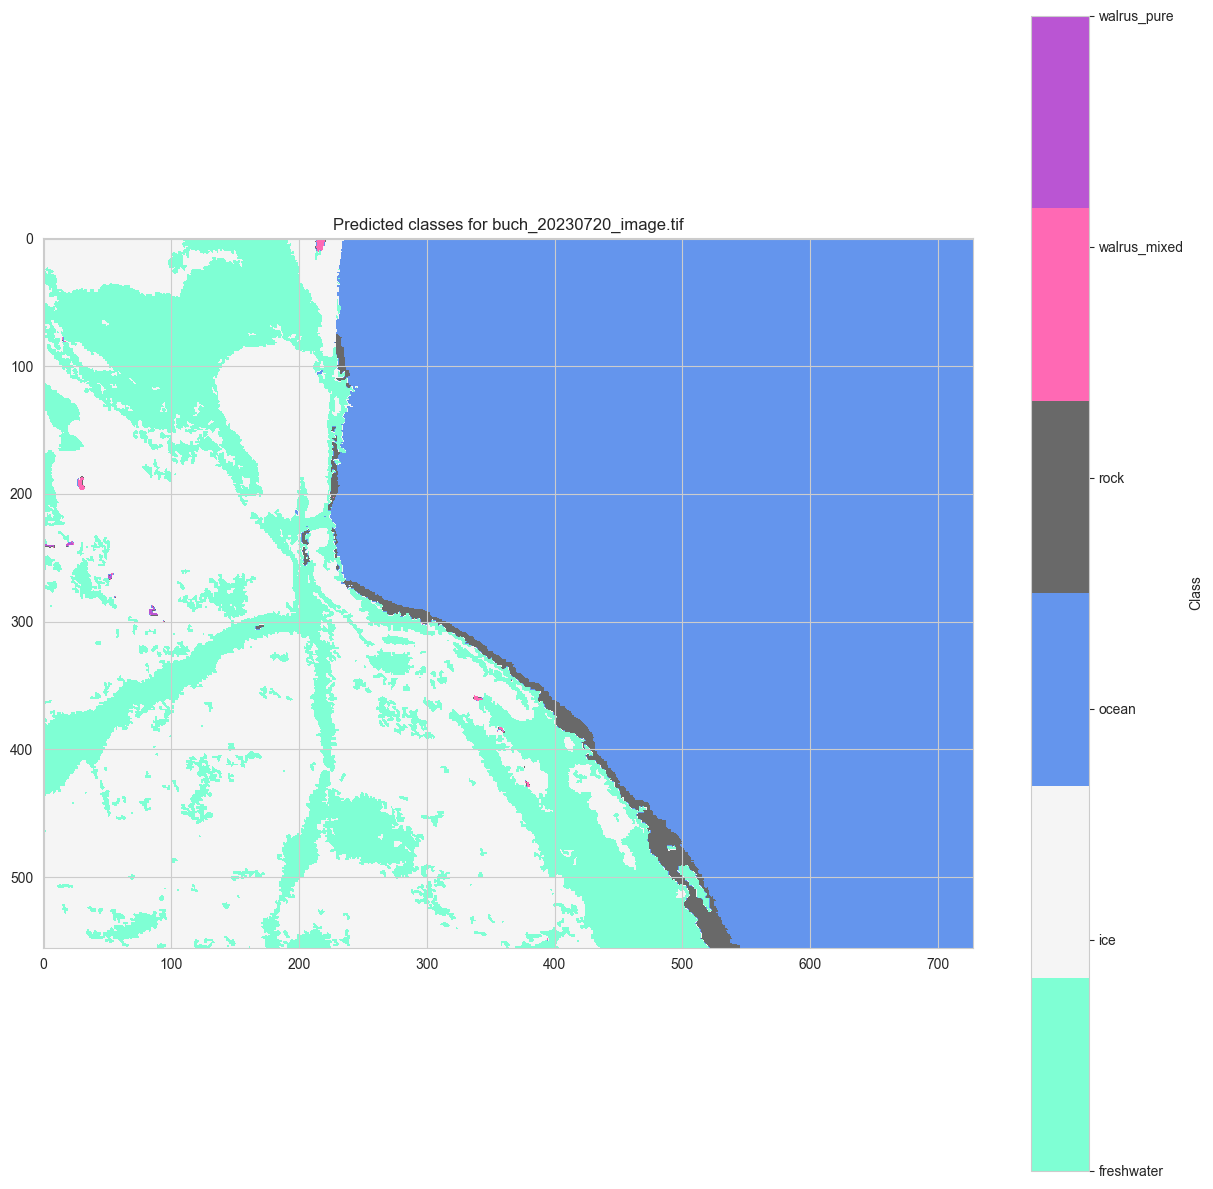


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif
Image shape: (8, 488, 639)
Image reshaped for prediction: (311832, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        1418  1395    1616   1779    1975  1760      1940  1942
1        1497  1396    1636   1768    1970  1791      1909  1922
2        1507  1443    1632   1763    1966  1833      1897  2040
3        1521  1466    1635   1768    1963  1840      1902  2109
4        1482  1423    1635   1735    1929  1749      1897  2036
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        1418  1395    1616   1779    1975  1760      1940  1942   
1        1497  1396    1636   1768    1970  1791      1909  1922   
2        1507  1443    1632   1763    1966  1833      1897  2040   
3        1521  1466    1635   1768    1963  1840      1902  2109   
4        1482  1423    1635   1

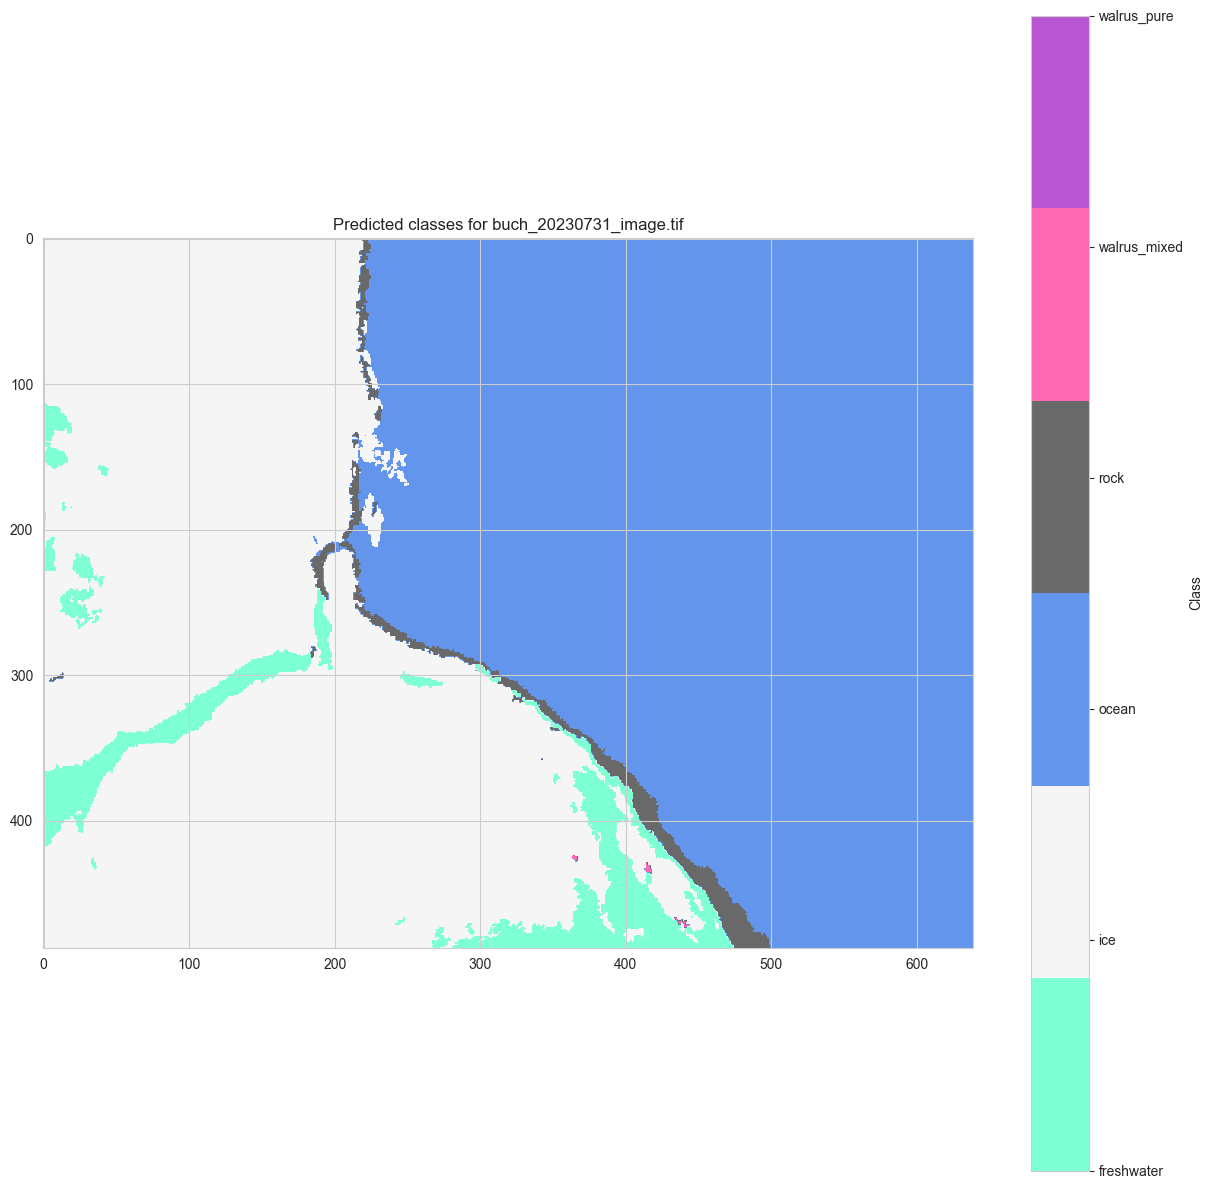


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif
Image shape: (8, 355, 466)
Image reshaped for prediction: (165430, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR
0        5940  5139    5211   4633    4872  3880      3607  3343
1        5937  5152    5219   4622    4832  3918      3748  3241
2        6016  5174    5191   4555    4754  3982      3812  3155
3        6097  5160    5146   4696    4790  3898      3725  3243
4        6102  5125    5126   4722    4828  3828      3806  3355
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0        5940  5139    5211   4633    4872  3880      3607  3343   
1        5937  5152    5219   4622    4832  3918      3748  3241   
2        6016  5174    5191   4555    4754  3982      3812  3155   
3        6097  5160    5146   4696    4790  3898      3725  3243   
4        6102  5125    5126   4

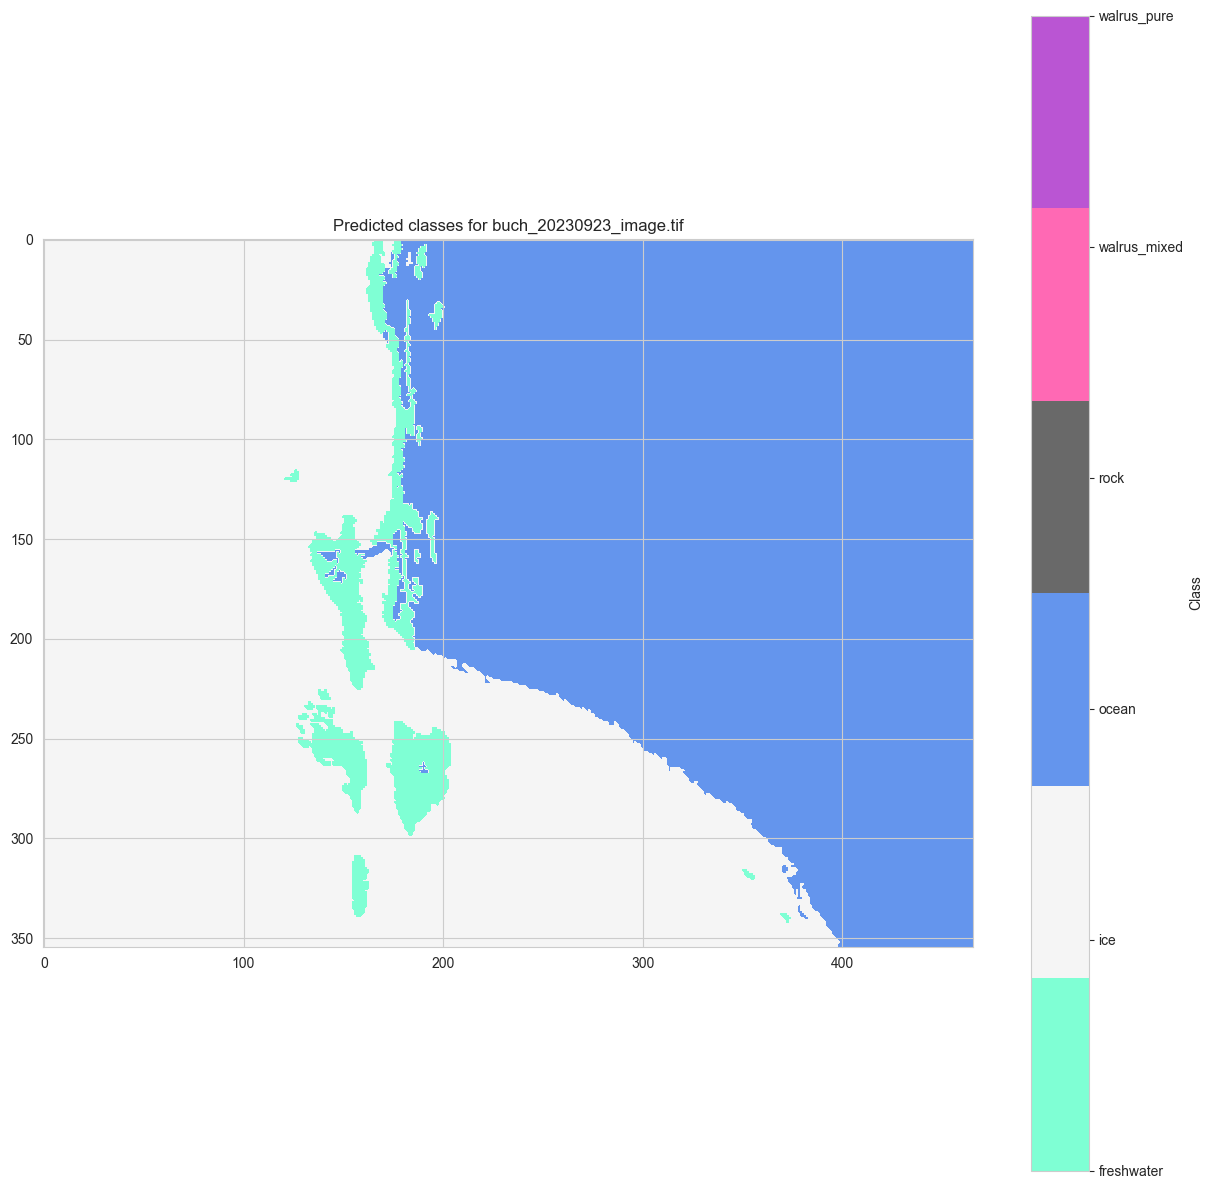


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif
Image shape: (8, 295, 446)
Image reshaped for prediction: (131570, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         539   352     440    285     260   64        40    9
1         583   342     438    284     283   78        31    3
2         588   346     442    273     280   81        68    1
3         544   349     447    261     272   68        79    1
4         518   361     451    271     276   56        72    1
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         539   352     440    285     260   64        40    9   
1         583   342     438    284     283   78        31    3   
2         588   346     442    273     280   81        68    1   
3         544   349     447    261     272   68        79    1   
4         518   361     451    271     276   56      

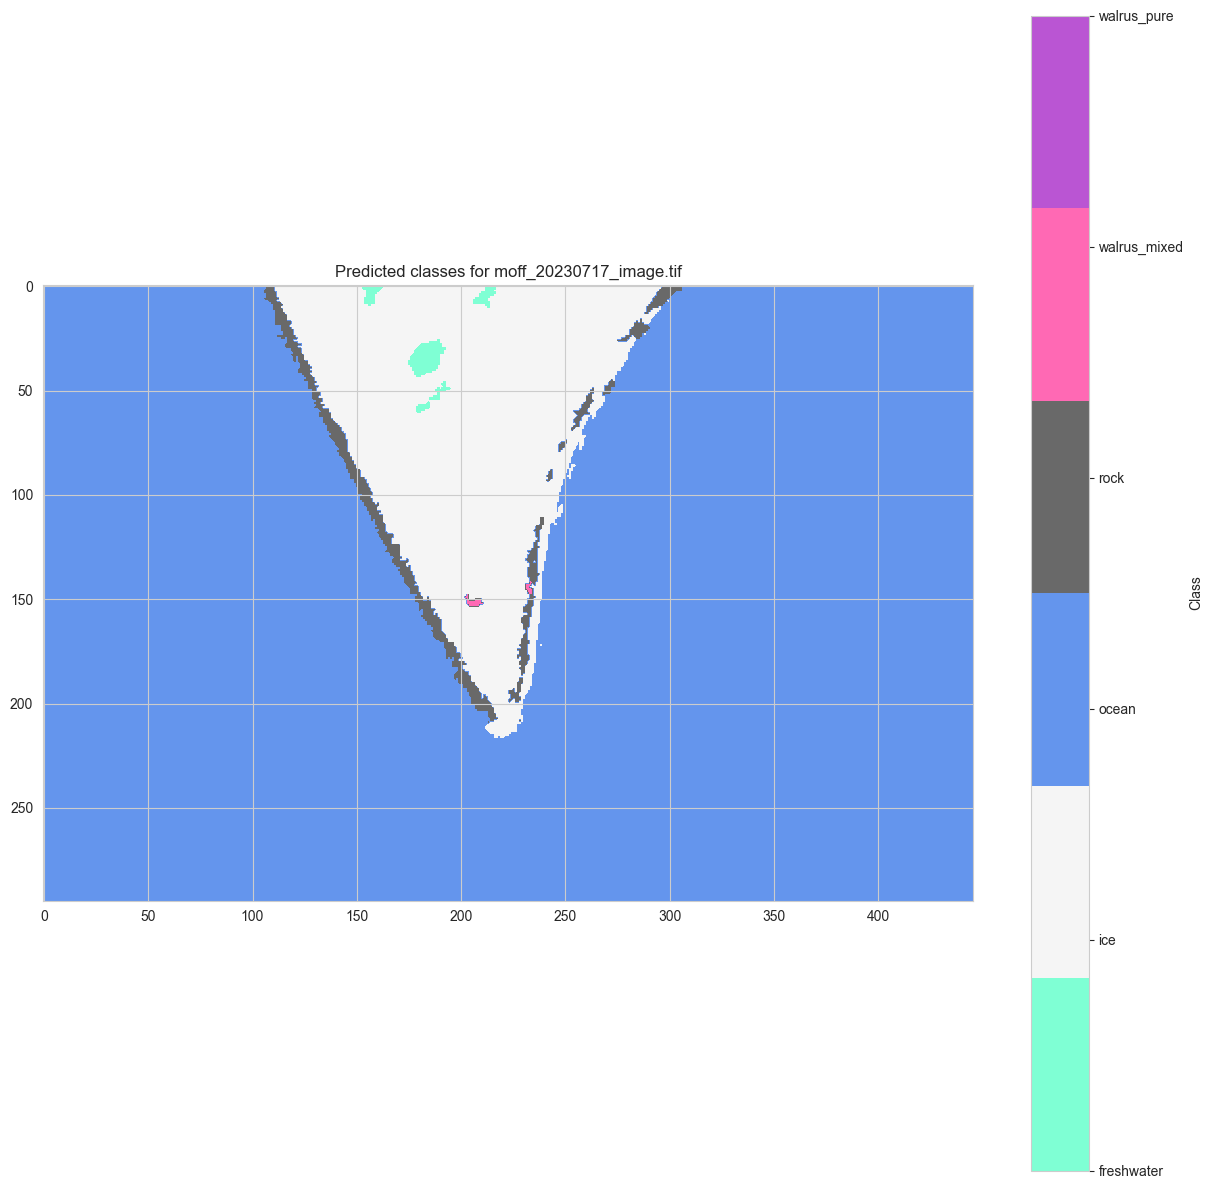


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230714_image.tif
Image shape: (8, 324, 492)
Image reshaped for prediction: (159408, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1309  1042    1213    929     874  547       415  225
1        1337  1028    1215    952     866  541       424  202
2        1374  1029    1230    965     862  548       443  215
3        1321  1044    1223    977     850  558       451  219
4        1342  1057    1225    965     861  551       434  198
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1309  1042    1213    929     874  547       415  225   
1        1337  1028    1215    952     866  541       424  202   
2        1374  1029    1230    965     862  548       443  215   
3        1321  1044    1223    977     850  558       451  219   
4        1342  1057    1225    965     861  551       

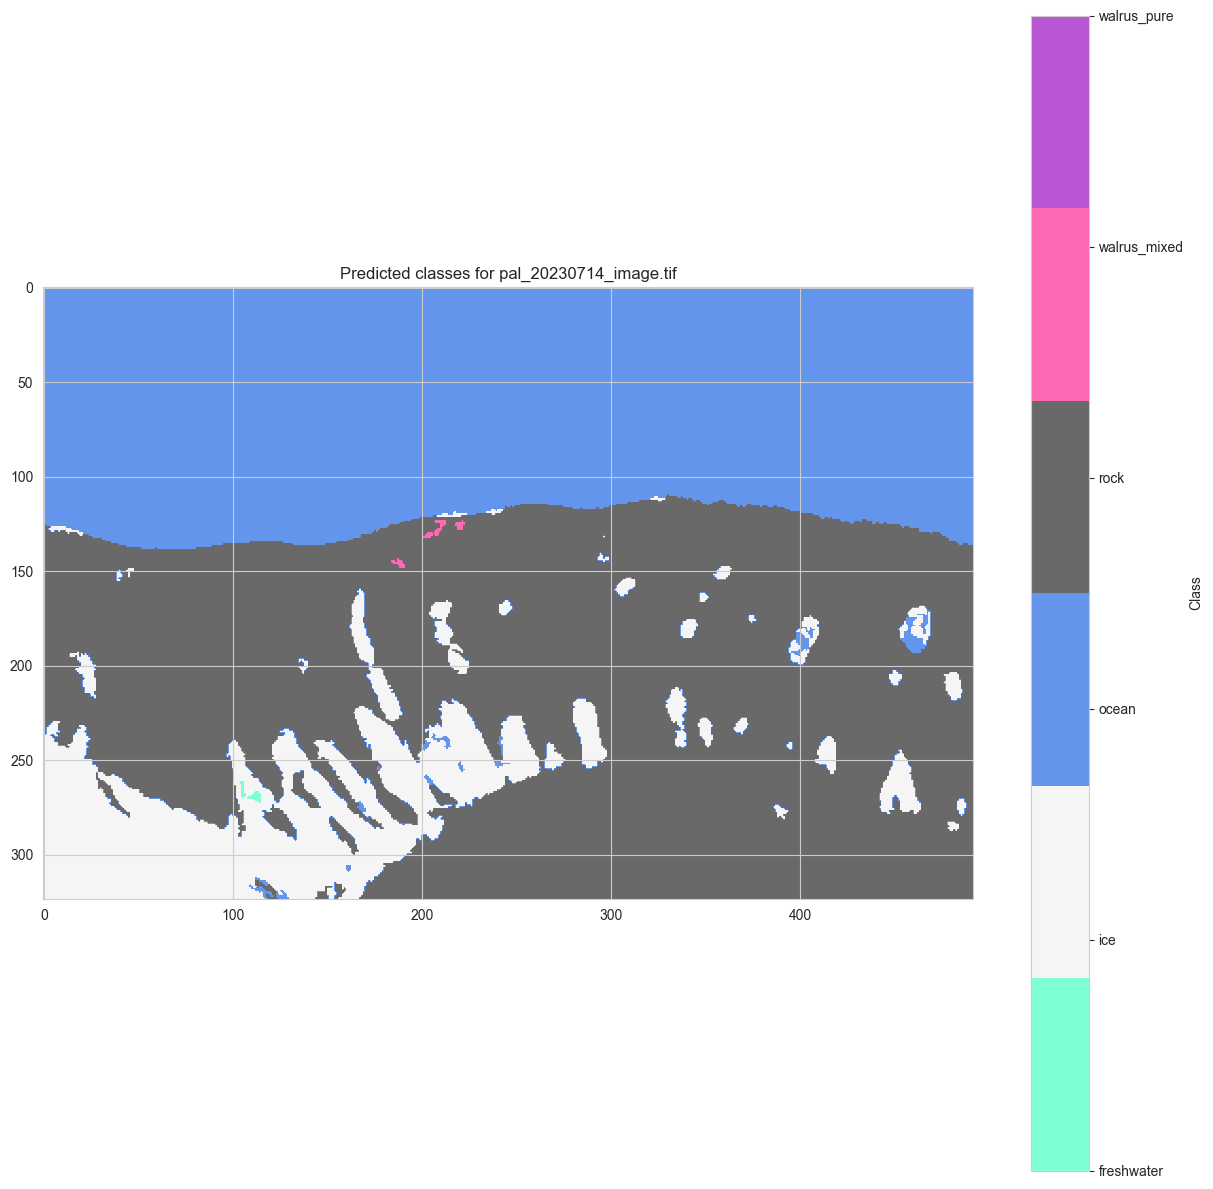


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230720_image.tif
Image shape: (8, 218, 342)
Image reshaped for prediction: (74556, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1678  1173    1590   1192    1344  764       641  359
1        1728  1167    1579   1204    1345  769       600  336
2        1743  1153    1563   1195    1343  758       619  315
3        1743  1122    1585   1213    1345  752       709  312
4        1742  1137    1601   1217    1340  747       701  362
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1678  1173    1590   1192    1344  764       641  359   
1        1728  1167    1579   1204    1345  769       600  336   
2        1743  1153    1563   1195    1343  758       619  315   
3        1743  1122    1585   1213    1345  752       709  312   
4        1742  1137    1601   1217    1340  747       7

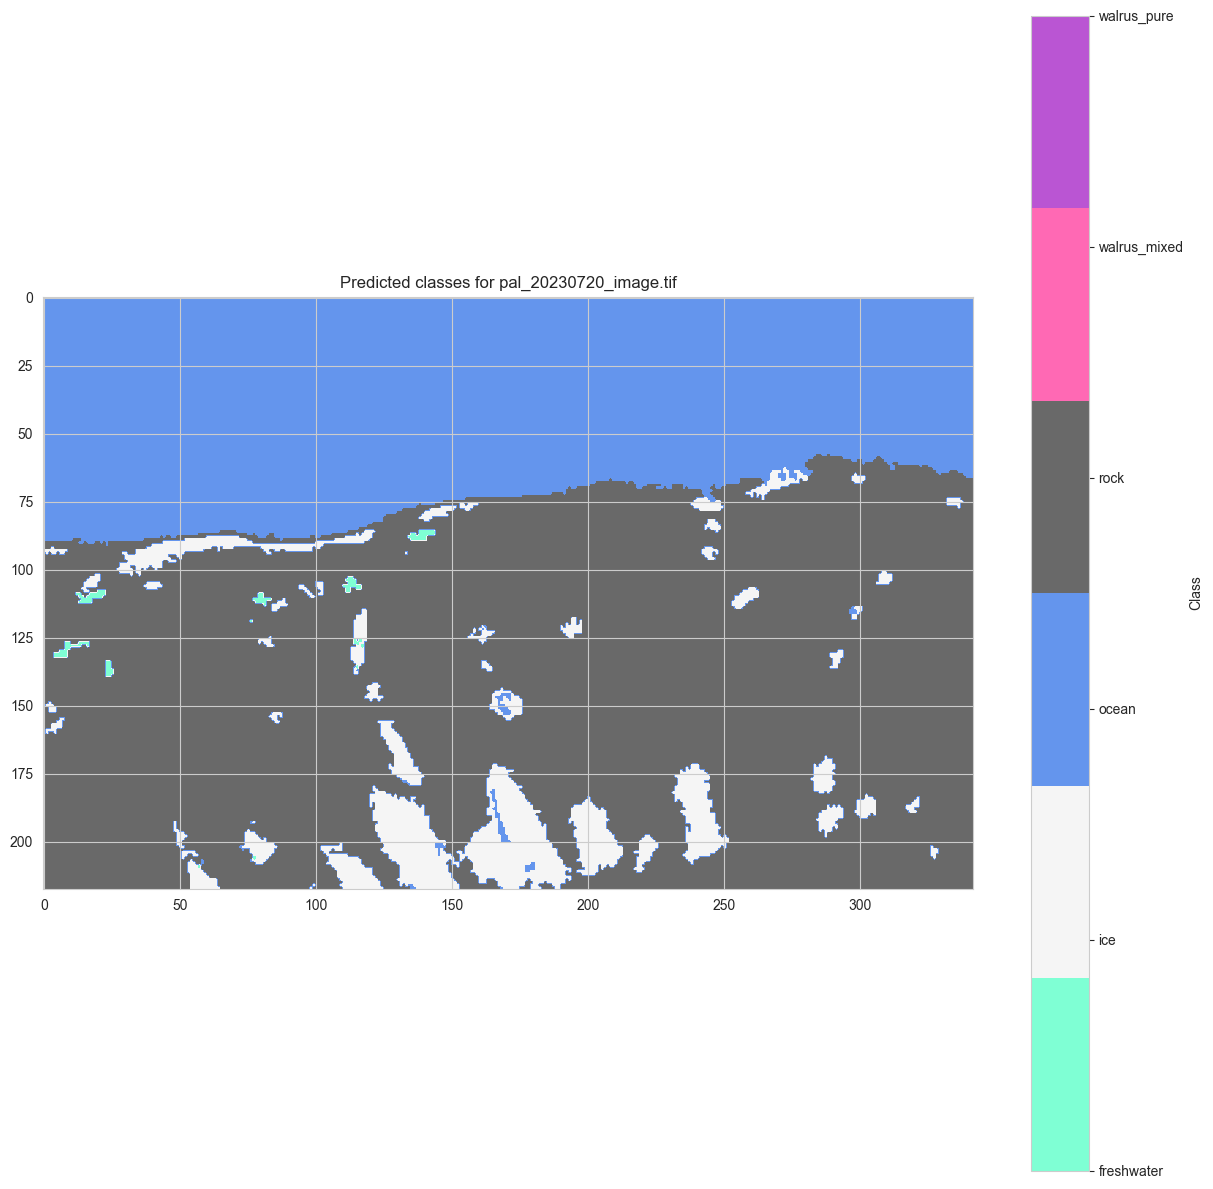


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230726_image.tif
Image shape: (8, 356, 540)
Image reshaped for prediction: (192240, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0        1440  1048    1195    969     941  444       442  248
1        1446  1048    1190    959     931  427       434  278
2        1395  1047    1190    945     943  408       441  264
3        1405  1051    1175    930     946  406       417  227
4        1411  1052    1151    926     924  430       388  212
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0        1440  1048    1195    969     941  444       442  248   
1        1446  1048    1190    959     931  427       434  278   
2        1395  1047    1190    945     943  408       441  264   
3        1405  1051    1175    930     946  406       417  227   
4        1411  1052    1151    926     924  430       

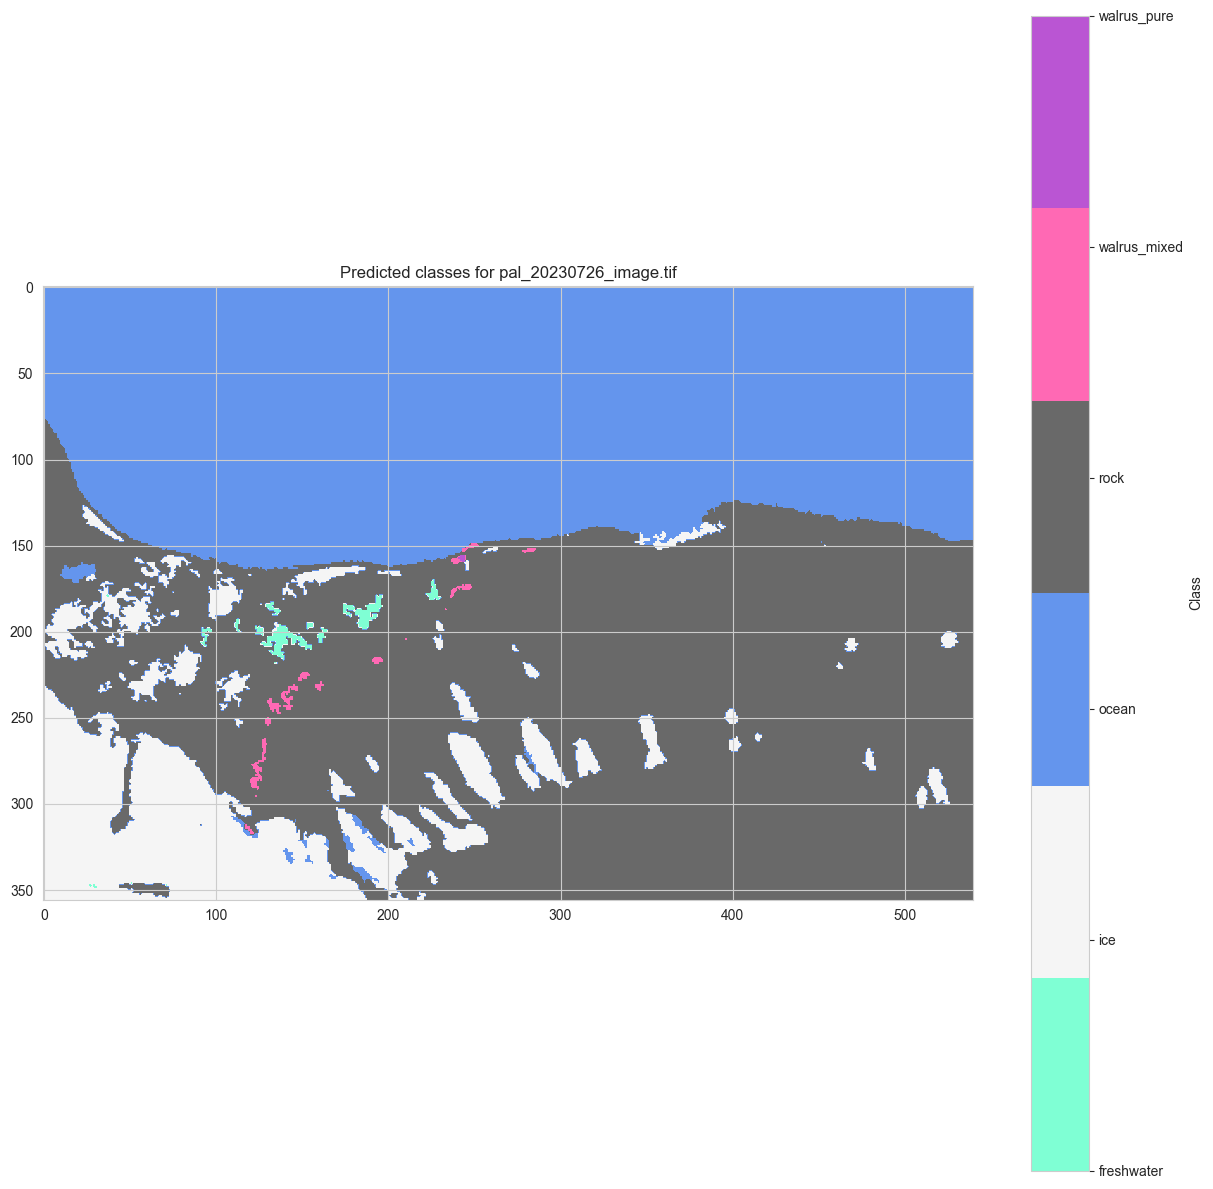


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230714_image.tif
Image shape: (8, 412, 590)
Image reshaped for prediction: (243080, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         701   422     557    290     256   89       188   48
1         718   420     554    307     258   93       111   29
2         685   420     541    338     240   95        48   34
3         666   432     547    324     224  100        79   35
4         738   432     549    313     246   91        70   19
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         701   422     557    290     256   89       188   48   
1         718   420     554    307     258   93       111   29   
2         685   420     541    338     240   95        48   34   
3         666   432     547    324     224  100        79   35   
4         738   432     549    313     246   91      

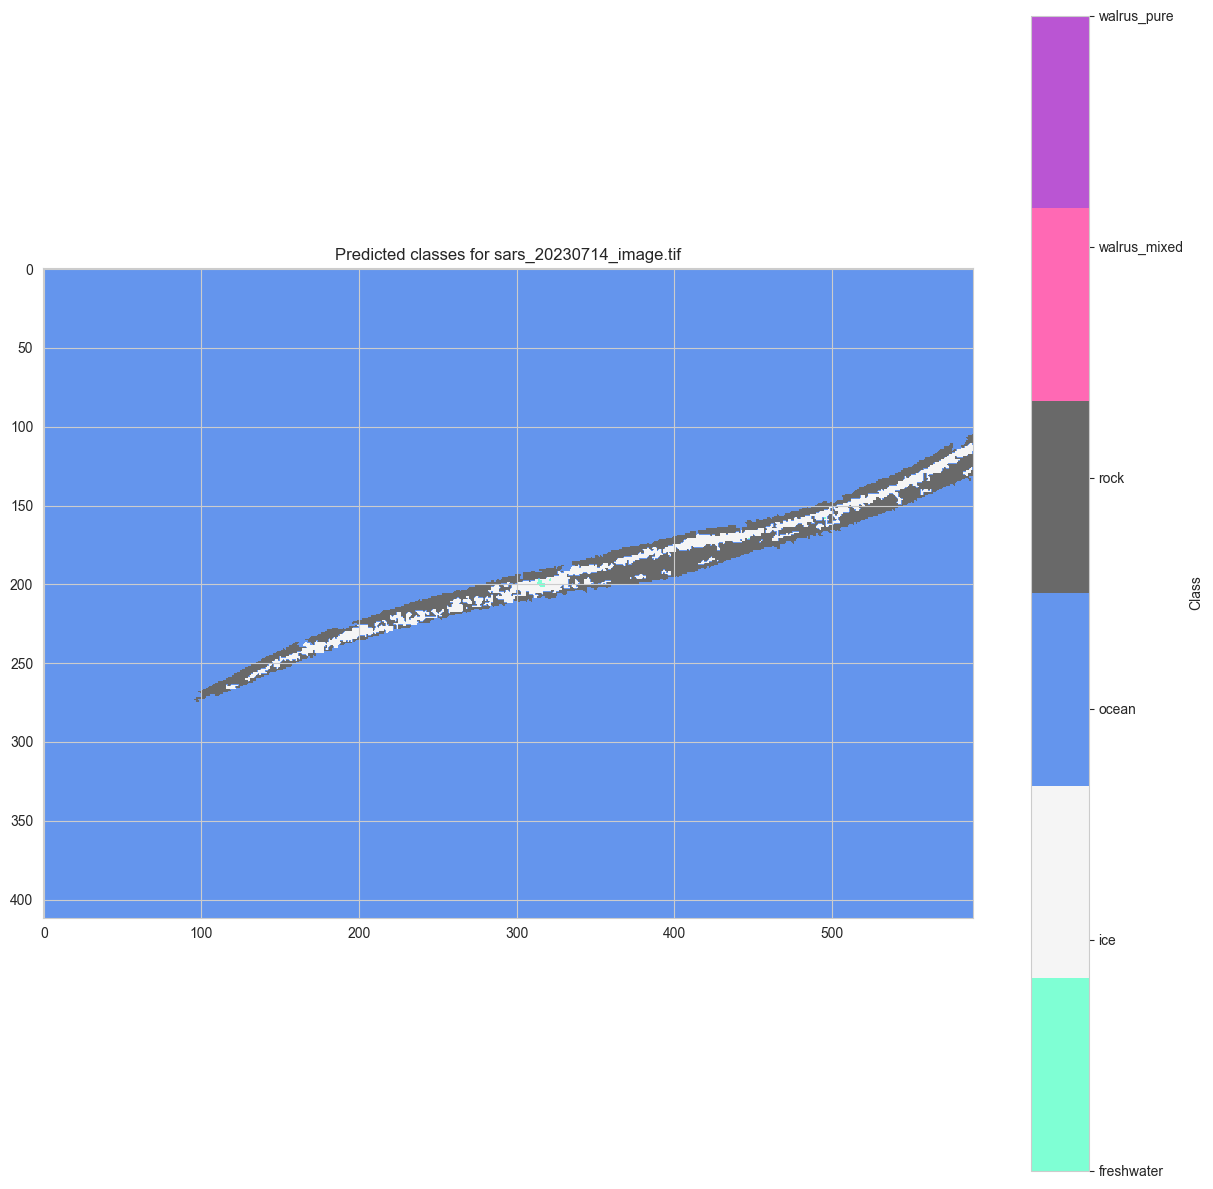


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230803_image.tif
Image shape: (8, 360, 433)
Image reshaped for prediction: (155880, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         579   499     453    305     292  107       142  199
1         607   494     444    300     312  137       165  132
2         605   487     431    298     320  127       142  121
3         590   492     433    295     292  100       162  152
4         585   508     422    300     288  119       149  174
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         579   499     453    305     292  107       142  199   
1         607   494     444    300     312  137       165  132   
2         605   487     431    298     320  127       142  121   
3         590   492     433    295     292  100       162  152   
4         585   508     422    300     288  119      

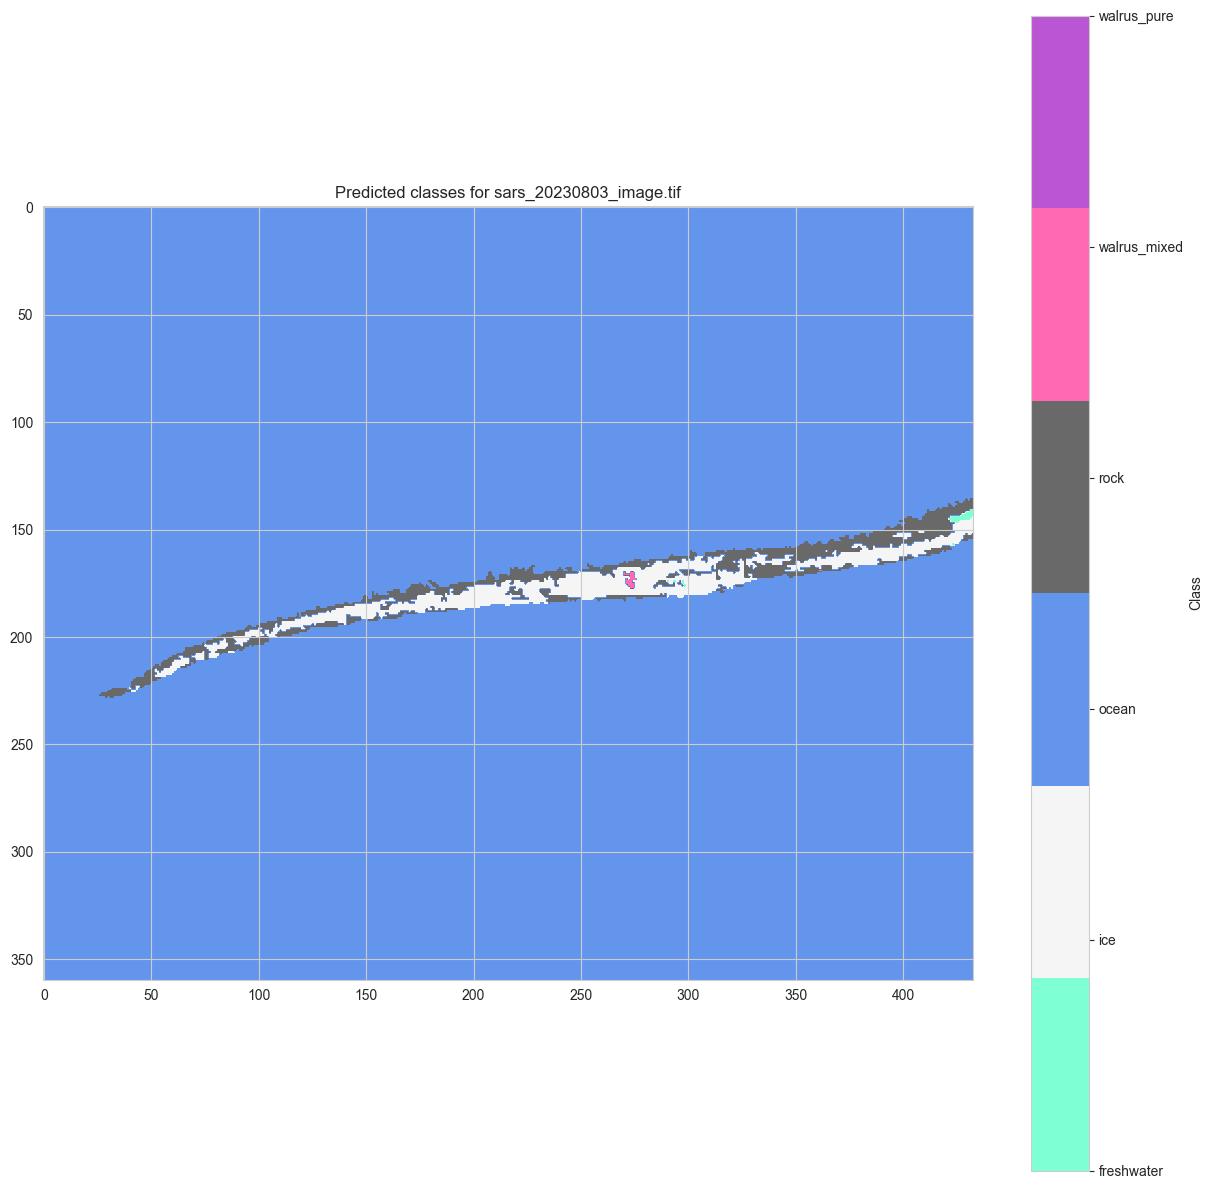


Processing training image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230801_image.tif
Image shape: (8, 421, 495)
Image reshaped for prediction: (208395, 8)
Initial dataframe:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR
0         672   567     570    426     346  254       157   80
1         721   570     558    437     354  246       180   94
2         696   583     573    430     361  213       206   93
3         656   593     574    423     358  224       186   75
4         700   583     549    423     347  234       162   66
Dataframe with advanced features:
   Coast_blue  Blue  Green1  Green  Yellow  Red  Red_edge  NIR  \
0         672   567     570    426     346  254       157   80   
1         721   570     558    437     354  246       180   94   
2         696   583     573    430     361  213       206   93   
3         656   593     574    423     358  224       186   75   
4         700   583     549    423     347  234       

In [ ]:
# add_advanced_features_optimized, best_rf_model, le, file_pairs, unlabeled_image_paths

def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        print(f"Image reshaped for prediction: {image_reshaped.shape}")
        
        df = pd.DataFrame(image_reshaped, columns=['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR'])
        print(f"Initial dataframe:\n{df.head()}")
        df = add_advanced_features_optimized(df)
        print(f"Dataframe with advanced features:\n{df.head()}")
        
        df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        predictions = model.predict(df)
        print(f"Unique predicted classes: {np.unique(predictions)}")
        return predictions.reshape((src.height, src.width))

def post_process(predicted_image, min_area=10):
    processed_image = np.copy(predicted_image)
    for label in np.unique(predicted_image):
        binary_image = (predicted_image == label)
        labeled_array, num_features = ndimage.label(binary_image)
        sizes = ndimage.sum(binary_image, labeled_array, range(num_features + 1))
        for i in range(1, num_features + 1):
            if sizes[i] < min_area:
                region = (labeled_array == i)
                dilated_region = ndimage.binary_dilation(region)
                neighbor_labels = predicted_image[dilated_region & ~region]
                if len(neighbor_labels) > 0:
                    most_common = np.bincount(neighbor_labels).argmax()
                    processed_image[region] = most_common
    return processed_image

def plot_prediction(image_path, processed_image, cmap, le):
    plt.figure(figsize=(15, 15))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(processed_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    plt.show()

# Define color map
label_colors = {
    'ice': 'whitesmoke', 'ocean': 'cornflowerblue', 'rock': 'dimgrey',
    'freshwater': 'aquamarine', 'walrus_pure': 'mediumorchid', 'walrus_mixed': 'hotpink'
}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Process training images
print("Processing training images:")
for image_path in file_pairs.keys():
    try:
        print(f"\nProcessing training image: {image_path}")
        predicted_image = predict_image(image_path, best_rf_model)
        processed_image = post_process(predicted_image)
        unique_labels = np.unique(processed_image)
        print(f"Unique labels in processed image: {unique_labels}")
        present_labels = [le.classes_[i] for i in unique_labels if i != -1]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plot_prediction(image_path, processed_image, cmap, le)
    except Exception as e:
        print(f"Error processing training image {image_path}: {str(e)}")
        traceback.print_exc()


In [ ]:
# Process unlabeled images
print("\nProcessing unlabeled images:")
for image_path in unlabeled_image_paths:
    try:
        print(f"\nProcessing unlabeled image: {image_path}")
        predicted_image = predict_image(image_path, best_rf_model)
        processed_image = post_process(predicted_image)
        unique_labels = np.unique(processed_image)
        print(f"Unique labels in processed image: {unique_labels}")
        present_labels = [le.classes_[i] for i in unique_labels if i != -1]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plot_prediction(image_path, processed_image, cmap, le)
    except Exception as e:
        print(f"Error processing unlabeled image {image_path}: {str(e)}")
        traceback.print_exc()

